rBergomi
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := S_0 \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta \widetilde{W}_t^H - \frac{\eta^2}{2} t^{2H}\right\}, \quad \widetilde{W}_t^H := \sqrt{2H} \int_0^t (t - u)^{-\gamma}  \mathrm{d}W^1_u,$$

$\gamma = \frac{1}{2}- H$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $\widetilde{W}_t^H$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  estimated using the following estimator,

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0),$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563).

Change directory to folder with rBergomi scripts

In [2]:
import os
#os.chdir('/Users/maalejach/Desktop/rough_bergomi/rbergomi')

Import required libraries, classes and functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from rbergomi_cholesky import rBergomi_cholesky
from utils import bsinv, Implied_Vol_dicho
vec_bsinv = np.vectorize(bsinv)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.linear_model import LinearRegression
from math import ceil
import os
import pandas as pd
import time
init_notebook_mode(connected=True)
%matplotlib inline

# Fonctions pour generer les paths rough vol + implied volatility :

In [2]:
def generate_rBergomi_paths(S0, T = 1.0, n=100, N=30000, H = 0.07, rho=-0.9, sigma0 = 0.15, eta = 1.9):
    rB = rBergomi(n = n, N = N, T = T, H = H)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = sigma0**2, eta = eta) 
    S = rB.S(V, dB, S0=S0)
    return S

In [3]:
def find_imp_vols(S, K, T=1.0, r=0):
    ST = S[:,-1][:,np.newaxis]
    call_payoffs = np.maximum(ST - K,0)
    call_prices = np.exp(-r*T)*np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    implied_vols = vec_bsinv(call_prices, S[0][0], np.transpose(K), T)
    return implied_vols

In [4]:
S0=100
start_time = time.time()
S = generate_rBergomi_paths(S0=S0, N=100000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.440644025802612 seconds ---


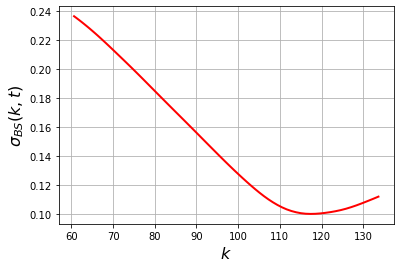

In [6]:
k = np.arange(-0.5, 0.3, 0.01) # moneyness
K = S0*np.exp(k)[np.newaxis,:] # Strikes
implied_vols1 = find_imp_vols(S, K)

plot, axes = plt.subplots()
axes.plot(K[0],implied_vols1, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t)$', fontsize=16)
#title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ H=%.2f $'
#axes.set_title(title%(rB.xi, rB.eta, rB.rho, 0.5+rB.a), fontsize=16)
plt.grid(True)

# Test on our data SPY OPTIONS :

In [7]:
def read_data(date,index="SPY",indicator="impliedV"):
    path = os.path.join("../data",indicator,index,date+"_"+index+"~market__"+indicator+".csv")
    df = pd.read_csv(path)
    return(df)

In [8]:
def get_iv_atm(expiry,df):
    df1 = df[df.expiry == expiry]
    df_bis = df1.drop_duplicates("expiry")
    df_bis["strike"] = df_bis["fwd"]
    df_bis["midImpliedV"] = np.nan
    df1 = df1.append(df_bis,ignore_index=True)
    df1.sort_values("strike",inplace=True)
    df1["midImpliedV"] = df1["midImpliedV"].interpolate()
    return(df1[df1["strike"] == df1["fwd"]]["midImpliedV"].values[0])

def add_iv_atm_col(df):
    def change_iv_atm(r,expiry,v):
        if r["expiry"]==expiry:
            r["IV_ATM"]=v
        return r
    # compute of IV_ATM of each expiry and add it to the column df["IV_ATM"]
    df["IV_ATM"] = np.nan
    for expiry in df.expiry.unique():
        v = get_iv_atm(expiry,df)
        df = df.apply(lambda r: change_iv_atm(r,expiry,v), axis=1)
    return df

In [17]:
#df_iv = read_data("20100204")
#df_iv = read_data("20130814")
df_iv = read_data("20150302")
#df_iv = read_data("20140115")
#df_iv = read_data("20160422")
df_iv["expiry"] = df_iv["expiry"].astype("str")
df_iv["expiry"] = pd.to_datetime(df_iv["expiry"],format="%Y-%m-%d")

In [18]:
df_iv = add_iv_atm_col(df_iv)
df_iv["Moneyness"] = np.log(df_iv["strike"]/df_iv["fwd"])/(np.sqrt(df_iv["tenor"])*df_iv["IV_ATM"])

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
df_iv_groupBy = df_iv.groupby(["tenor","strike","expiry"]).mean()
df_iv_groupBy.reset_index("expiry",inplace=True)

In [20]:
df_iv_groupBy

expiry  cleanExpiry    vTenor        spot         fwd  \
tenor    strike                                                             
0.010959 190.0  2015-03-06     20150306  0.011691  211.944013  211.945000   
         191.0  2015-03-06     20150306  0.011691  211.944013  211.945000   
         192.0  2015-03-06     20150306  0.011691  211.944013  211.945000   
         193.0  2015-03-06     20150306  0.011691  211.944013  211.945000   
         193.5  2015-03-06     20150306  0.011691  211.944013  211.945000   
...                    ...          ...       ...         ...         ...   
0.873973 240.0  2016-01-15     20160115  0.875639  211.944013  209.388395   
         245.0  2016-01-15     20160115  0.875639  211.944013  209.388395   
         250.0  2016-01-15     20160115  0.875639  211.944013  209.388395   
         255.0  2016-01-15     20160115  0.875639  211.944013  209.388395   
         260.0  2016-01-15     20160115  0.875639  211.944013  209.388395   

                 pcIndicator  volume  openInterest  bidPrice  offerPrice  \
tenor    strike                                                            
0.010959 190.0          -1.0  1605.0       38125.0      0.01        0.02   
         191.0          -1.0  2480.0         700.0      0.01        0.02   
         192.0          -1.0     0.0          19.0      0.01        0.02   
         193.0          -1.0     4.0        2404.0      0.01        0.02   
         193.5          -1.0     0.0        6185.0      0.01        0.02   
...                      ...     ...           ...       ...         ...   
0.873973 240.0           1.0     0.0        4022.0      0.70        0.81   
         245.0           1.0     0.0        5856.0      0.35        0.45   
         250.0           1.0    10.0        7658.0      0.19        0.26   
         255.0           1.0     0.0         620.0      0.10        0.17   
         260.0           1.0    11.0         121.0      0.05        0.10   

                 midPrice  bidImpliedV  offerImpliedV  midImpliedV  \
tenor    strike                                                      
0.010959 190.0      0.015     0.380215       0.410444     0.397192   
         191.0      0.015     0.363722       0.392873     0.380092   
         192.0      0.015     0.347252       0.375319     0.363014   
         193.0      0.015     0.330801       0.357779     0.345953   
         193.5      0.015     0.322580       0.349012     0.337428   
...                   ...          ...            ...          ...   
0.873973 240.0      0.755     0.100858       0.104483     0.102727   
         245.0      0.400     0.097102       0.102014     0.099676   
         250.0      0.225     0.096255       0.101414     0.098956   
         255.0      0.135     0.095575       0.103265     0.099795   
         260.0      0.075     0.094866       0.103537     0.099739   

                 criticalSpot    IV_ATM  Moneyness  
tenor    strike                                     
0.010959 190.0           -1.0  0.094234 -11.080058  
         191.0           -1.0  0.094234 -10.547929  
         192.0           -1.0  0.094234 -10.018579  
         193.0           -1.0  0.094234  -9.491978  
         193.5           -1.0  0.094234  -9.229700  
...                       ...       ...        ...  
0.873973 240.0           -1.0  0.156553   0.932301  
         245.0           -1.0  0.156553   1.073186  
         250.0           -1.0  0.156553   1.211223  
         255.0           -1.0  0.156553   1.346528  
         260.0           -1.0  0.156553   1.479205  

[822 rows x 17 columns]

In [21]:
def find_sigma0(df_iv_groupBy,maturity):
    """
    sigma0 for a fixed maturity is the iv at-the-money
    """
    df_min_mat = df_iv_groupBy.loc[maturity].reset_index()
    sigma0 = df_min_mat["IV_ATM"].unique()[0]
    return sigma0

def compute_iv_roughVol_fixedDate(df_iv_groupBy, index_dic_param = 0, tenor_min=0,tenor_max = 1, n=252,
                                  N=100000, params = [ 0.02265572, -0.31538744, 2.48133172]):
    ## get tenor list
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    ## get the parameters from params
    H,rho,eta = params[0],params[1],params[2]
    r = 0.05
    spot = df_iv_groupBy["spot"].values[0]
    print("spot :",spot)
    #sigma0 = find_sigma0(df_iv_groupBy,tenor_list_unique[0])
    #print("sigma0 :",sigma0)
    #sigma0 = 0.12
    #S = generate_rBergomi_paths(S0=spot, n=n, N=N, T = 1.0, H = H, rho=rho, sigma0 = sigma0, eta = eta)
    for tenor in tenor_list_unique:
        if (tenor>=tenor_min) and (tenor<=tenor_max):
            mat_days = int(tenor*n)+1
            print("maturity in days : "+str(mat_days))
            sigma0 = find_sigma0(df_iv_groupBy,tenor)
            print("sigma0 :",sigma0)
            S = generate_rBergomi_paths(S0=spot, n=n, N=N, T = tenor, H = H, rho=rho, sigma0 = sigma0+0.02, eta = eta)
            strike_list = np.array([df_iv_groupBy.loc[tenor].index])
            implied_vols = find_imp_vols(S[:,:mat_days], strike_list, T=tenor)
            df_iv_groupBy.loc[tenor,"simulated_iv_rough_vol_"+str(index_dic_param)] = implied_vols
        elif tenor>=tenor_max:
            break;
    return df_iv_groupBy

### remarques :

- resultats varient un peu d'une simulation à une autre ( N=100000)
- resultats changent quand on fait varier N

### params = [ H, rho, eta]

In [22]:
#params = [ 0.02265572, -0.31538744, 2.48133172] # H,rho,eta
#params = [ 0.22, -0.7,  2.3] # H,rho,eta
#params = [ 0.05, -0.9, 2.3] # H,rho,eta
#params = [ 0.13965069 , -0.8270291, 3.03526396] # tenor = 0.025
#params = [ 0.08782856, -0.84040342,  2.07209507] # tenor = 0.063
#params = [ 0.096831  , -0.72890588,  1.96787099] # tenor = 0.1
#params = [ 0.07212302, -0.77161391,  2.07466641] # tenor = 0.427
#params = [0.07, -0.9, 1.9] # 2014-02-04
params = [ 0.12408347, -0.77516331,  2.58549533] # 2015-03-02
#params = [ 0.08930132, -0.79512602,  2.14441384] # 2013-08_14
#params = [ 0.09057721, -0.77871421,  1.98934386] # 2014-01_15
#params = [ 0.08302674, -0.62278736,  2.09455115] # 2016-04-22
df_iv_groupBy = compute_iv_roughVol_fixedDate(df_iv_groupBy,index_dic_param=0,tenor_min=0, tenor_max=1,
                                              params=params, N=100000)

spot : 211.94401265487218
maturity in days : 3
sigma0 : 0.09423352404457999
maturity in days : 8
sigma0 : 0.09491386464726342
maturity in days : 13
sigma0 : 0.11394727701965476
maturity in days : 18
sigma0 : 0.10736858433023294
maturity in days : 22
sigma0 : 0.10971581585554216
maturity in days : 32
sigma0 : 0.1162283902942775
maturity in days : 52
sigma0 : 0.12372491673408811
maturity in days : 76
sigma0 : 0.13640075464395676
maturity in days : 139
sigma0 : 0.14529726793845216
maturity in days : 201
sigma0 : 0.15627125083270316
maturity in days : 221
sigma0 : 0.1565532750563488


In [25]:
def plot_iv_skew(df_iv_groupBy, index_dic_param=2, tenor_min=0, tenor_max=1):
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    nb_rows = ceil(len(tenor_list_unique)/3)
    fig, axes = plt.subplots(nb_rows,3, figsize=(15,3*nb_rows))
    fig.tight_layout(w_pad=0)
    for i,tenor in  enumerate(tenor_list_unique):
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("tenor")
        df_iv_grouBy_reset_tenor = df_iv_grouBy_reset[(df_iv_grouBy_reset["tenor"]==tenor) & 
                                                      (df_iv_grouBy_reset["simulated_iv_rough_vol_"+str(index_dic_param)]>0.001)]
        df_iv_grouBy_reset_tenor[["midImpliedV"]].plot( style='y*', ax=axes[i//3,i%3])
        df_iv_grouBy_reset_tenor[["bidImpliedV"]].plot( style='b*', ax=axes[i//3,i%3])
        df_iv_grouBy_reset_tenor[["offerImpliedV"]].plot( style='g*', ax=axes[i//3,i%3])
        df_iv_grouBy_reset_tenor[["simulated_iv_rough_vol_"+str(index_dic_param)]].plot(color="red",ax=axes[i//3,i%3])
        axes[i//3,i%3].set_title("Tenor = "+str(round(tenor,3)))
        axes[i//3,i%3].set_xlabel('k', fontsize=12)
        axes[i//3,i%3].set_ylabel(r'$\sigma_{BS}(K,T)$', fontsize=12)
        axes[i//3,i%3].legend()
        axes[i//3,i%3].grid(True)

#### The following results are simulated using the parameters we obtained from the calibration afterwards

### Date : 2010-02-04

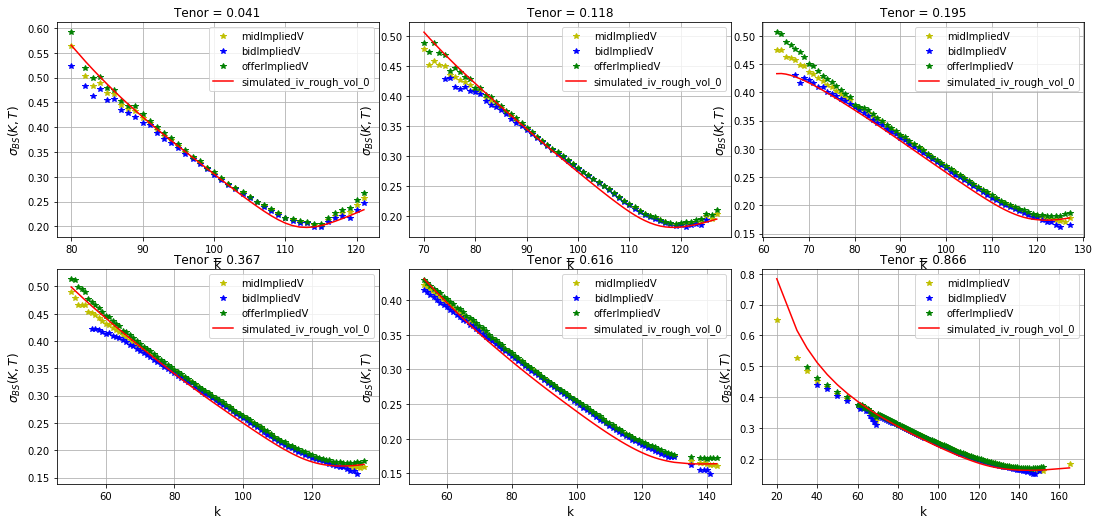

In [188]:
## Date : 2010-02-04
## params = [ 0.07, -0.9,  1.9]
plot_iv_skew(df_iv_groupBy,index_dic_param=0)

### Date : 2013-08-14

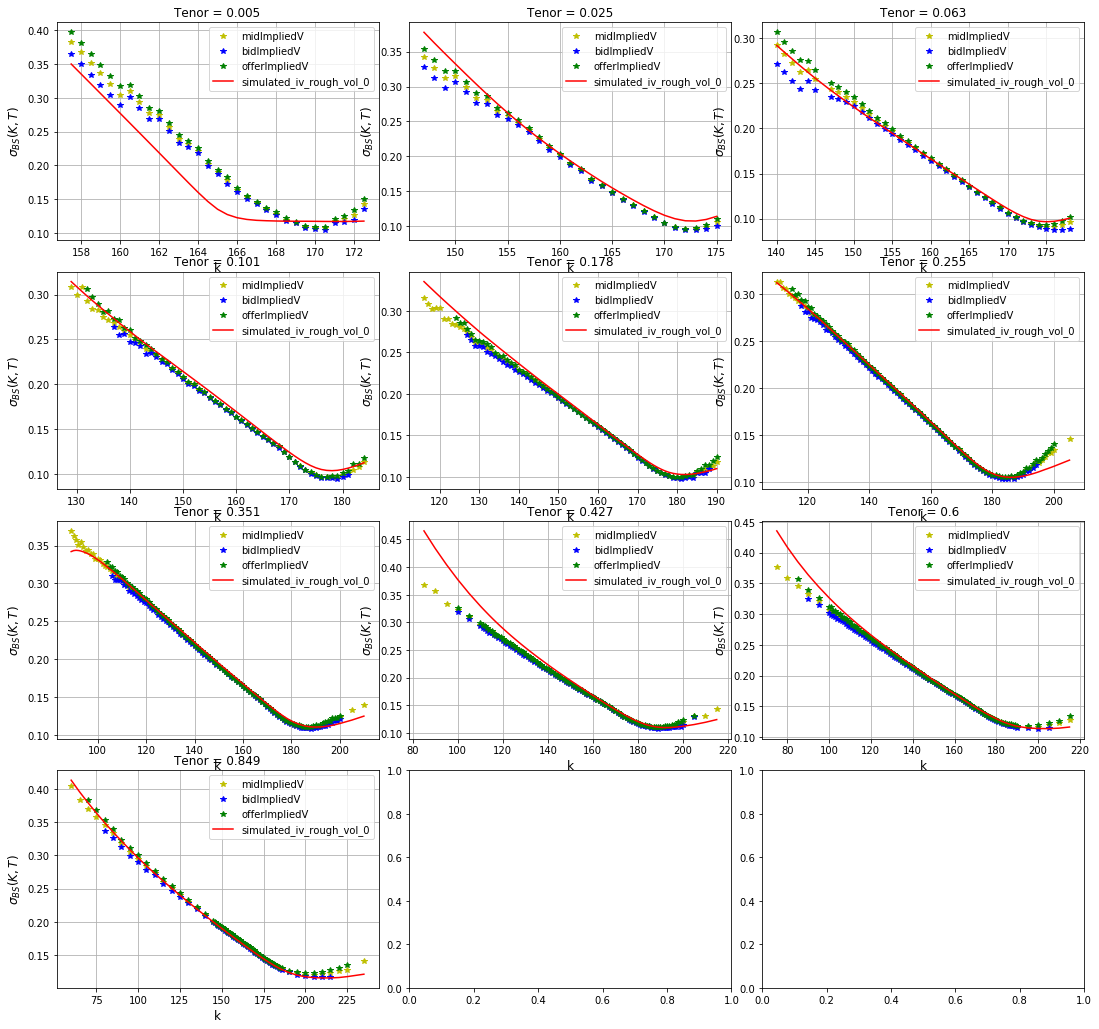

In [16]:
## Date : 2013-08-14
## params = [ 0.08930132, -0.79512602,  2.14441384]
plot_iv_skew(df_iv_groupBy,index_dic_param=0)

### Date : 2015-03-02

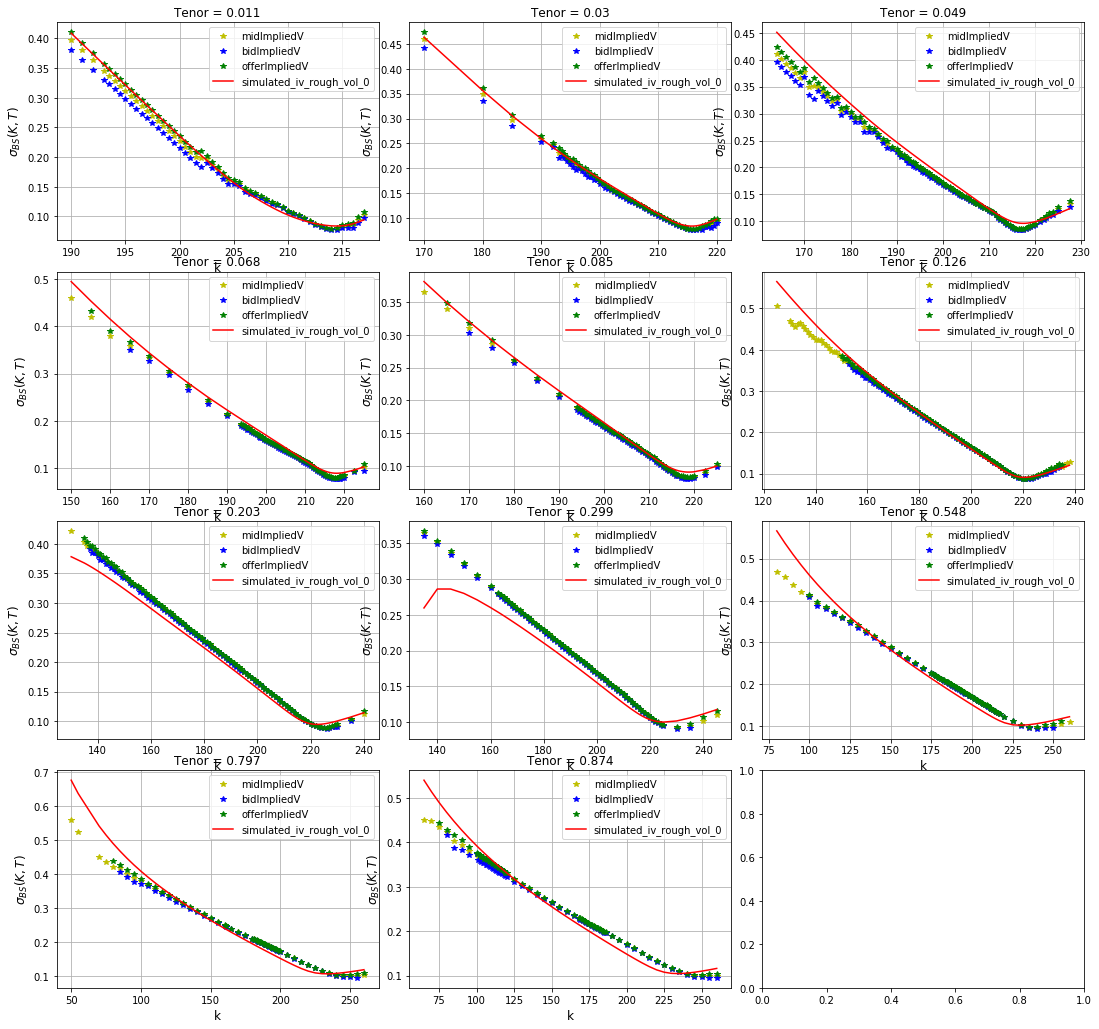

In [24]:
## Date : 2015-03-02
## params = [ 0.12408347, -0.77516331,  2.58549533]
plot_iv_skew(df_iv_groupBy,index_dic_param=0)

### Date : 2014-01-15

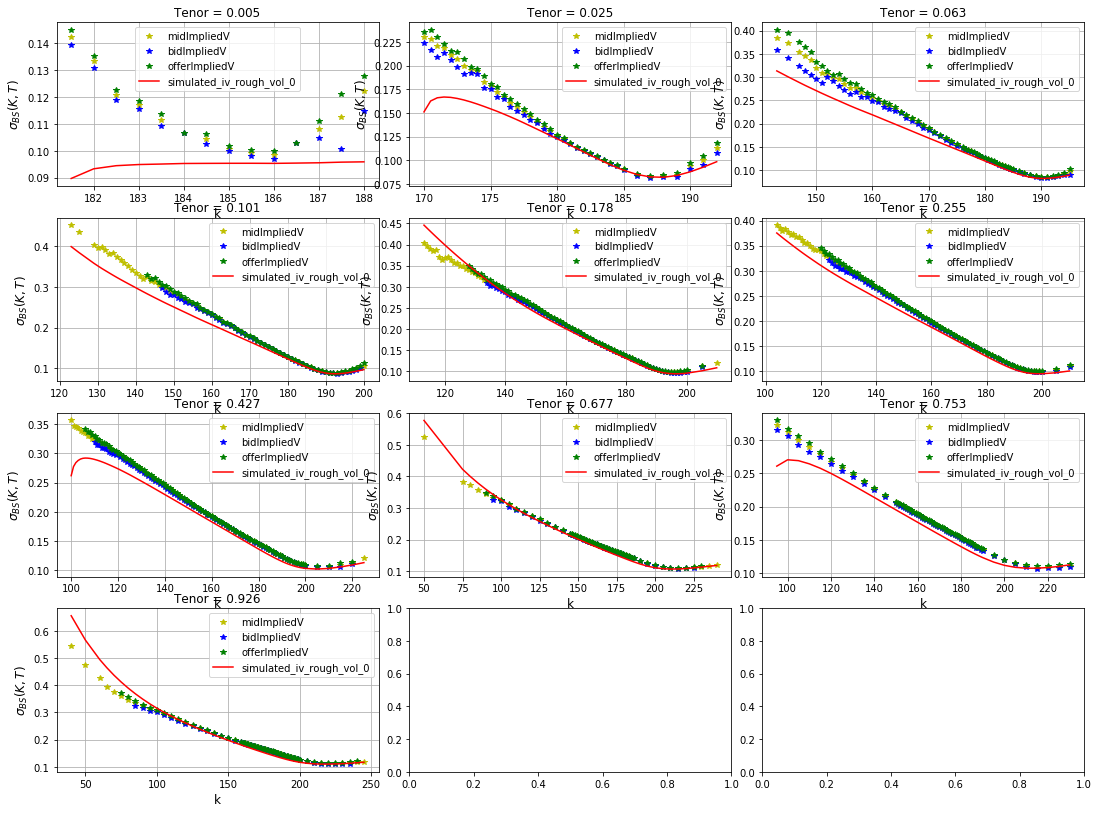

In [408]:
## Date : 2014-01-15
## params = [ 0.09057721, -0.77871421,  1.98934386]
plot_iv_skew(df_iv_groupBy,index_dic_param=0)

### Date : 2016-04-22

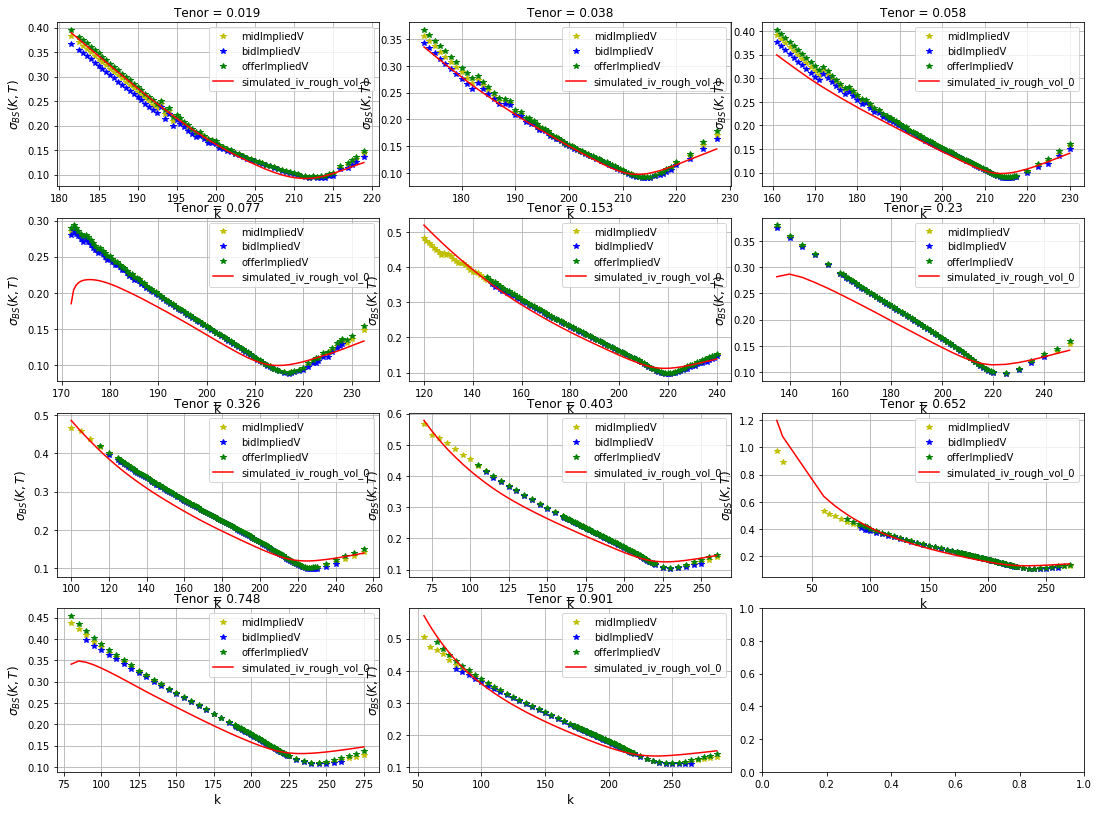

In [572]:
## Date : 2016-04-22
## params = [ 0.08302674, -0.62278736,  2.09455115]
plot_iv_skew(df_iv_groupBy,index_dic_param=0)

### Remarques :

Les résultats présentés ci-dessus sont fait avec un set de paramètres calibrés sur toute la surface de volatilités:
Nous remarquons que le comportement à tenor faible est differents des autres tenor. Le plus mieux serait de calibrer les faibles tenors à part.

### ATM skew term structure :

In [205]:
def plot_atm_skew_term_structure(df_iv_groupBy,index_dic_param = 0):
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    atm_skew_simul_list = []
    atm_skew_real_list = []
    fig = plt.figure(figsize=(9,6))
    for i,tenor in  enumerate(tenor_list_unique):
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("tenor")
        df_iv_grouBy_reset_tenor = df_iv_grouBy_reset[(df_iv_grouBy_reset["tenor"]==tenor) & 
                                                      (df_iv_grouBy_reset["simulated_iv_rough_vol_"+str(index_dic_param)]>0.001)]
        df_iv_grouBy_reset_tenor_monyness_sup0 = df_iv_grouBy_reset_tenor[df_iv_grouBy_reset_tenor["Moneyness"]>0]
        atm_skew_simul = (df_iv_grouBy_reset_tenor_monyness_sup0["simulated_iv_rough_vol_"+str(index_dic_param)].values[5] - 
        df_iv_grouBy_reset_tenor_monyness_sup0["simulated_iv_rough_vol_"+str(index_dic_param)].values[0]) / (df_iv_grouBy_reset_tenor_monyness_sup0["Moneyness"].values[5] - 
        df_iv_grouBy_reset_tenor_monyness_sup0["Moneyness"].values[0])
        atm_skew_real = (df_iv_grouBy_reset_tenor_monyness_sup0["midImpliedV"].values[5] - 
        df_iv_grouBy_reset_tenor_monyness_sup0["midImpliedV"].values[0]) / (df_iv_grouBy_reset_tenor_monyness_sup0["Moneyness"].values[5] - 
        df_iv_grouBy_reset_tenor_monyness_sup0["Moneyness"].values[0])

        atm_skew_simul_list.append(atm_skew_simul)
        atm_skew_real_list.append(atm_skew_real)
    
    fig, ax = plt.subplots(1,2,figsize=(13,6))
    # normal plot
    ax[0].plot(tenor_list_unique,atm_skew_real_list,".-",color="b",label="real data")

    ax[0].plot(tenor_list_unique,atm_skew_simul_list,".-",color="r",label="rough model")

    ax[0].set_title("ATM skew term structure")      
    ax[0].set_ylabel("ATM skew")
    ax[0].set_xlabel("tenor")
    ax[0].legend()
    # loglog plot with linear regressions
    reg_simul = LinearRegression().fit(np.array(np.log(tenor_list_unique[1:])).reshape(-1, 1), 
                             np.array(np.log(np.abs(atm_skew_simul_list[1:]))))
    reg_real = LinearRegression().fit(np.array(np.log(tenor_list_unique[1:])).reshape(-1, 1), 
                             np.array(np.log(np.abs(atm_skew_real_list[1:]))))

    ax[1].plot(np.log(tenor_list_unique[1:]),np.log(np.abs(atm_skew_real_list[1:])),".-",color="b",label="real data")
    ax[1].plot(np.log(tenor_list_unique[1:]),reg_real.coef_[0]*np.array(np.log(tenor_list_unique[1:]))+reg_real.intercept_ , color="g",
           label=str(round(reg_real.coef_[0],3))+"*x+"+str(round(reg_real.intercept_,3)))
    ax[1].plot(np.log(tenor_list_unique[1:]),np.log(np.abs(atm_skew_simul_list[1:])),".-",color="r",label="rough model")
    ax[1].plot(np.log(tenor_list_unique[1:]),reg_simul.coef_[0]*np.array(np.log(tenor_list_unique[1:]))+reg_simul.intercept_ , color="g",
           label=str(round(reg_simul.coef_[0],3))+"*x+"+str(round(reg_simul.intercept_,3)))
    ax[1].set_title("Absolute value of ATM skew term structure in log-log scale")      
    ax[1].set_ylabel("ATM skew")
    ax[1].set_xlabel("tenor")
    ax[1].legend()
        

<Figure size 648x432 with 0 Axes>

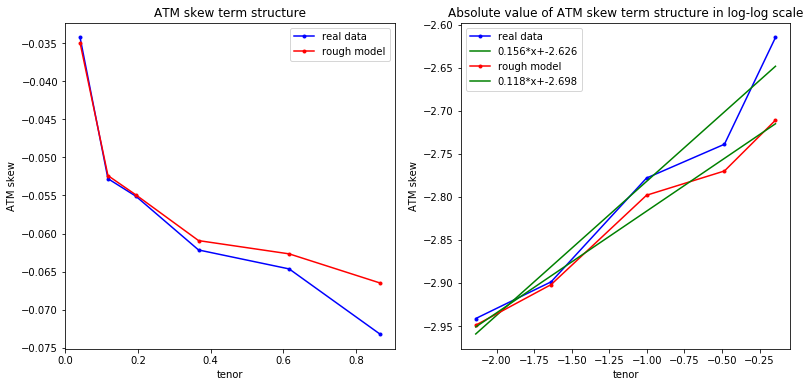

In [206]:
#2013-08-14
plot_atm_skew_term_structure(df_iv_groupBy)

### volatility surface real vs simulated :

In [594]:
def plot_vol_surface(df,date,x_col="tenor",y_col="strike",target_z_col="midImpliedV"):
    df = df.reset_index()
    df = df[df["simulated_iv_rough_vol_0"]>0.001]
    df_pivot_real = df.pivot(index=y_col,columns=x_col,values=target_z_col)
    df_pivot_sim = df.pivot(index=y_col,columns=x_col,values="simulated_iv_rough_vol_0")
    fig = go.Figure(data=[go.Surface(x=df_pivot_real.columns.values,y=df_pivot_real.index ,z=df_pivot_real.values, 
                                connectgaps=True, visible=True, name="realised volatility surface",
                                     colorscale=[[0, 'rgb(0,255,255)'], [1, 'rgb(0,255,0)']], showscale=False),
                         go.Surface(x=df_pivot_sim.columns.values,y=df_pivot_sim.index ,z=df_pivot_sim.values, 
                                     connectgaps=True, visible=True, name="simulated volatility surface",
                                    colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(0,0,255)']], showscale=False)])

    fig.update_layout(title='Simulated volatility surface : '+date, autosize=True,
                      width=800, height=600)

    fig.show()

In [595]:
plot_vol_surface(df_iv_groupBy, date="2013-08-14")

### Ponctual error :

In [596]:
def plot_ponctual_error_surface(df,x_col="tenor",y_col="strike",target_z_col="midImpliedV"):
    df = df.reset_index()
    df = df[df["simulated_iv_rough_vol_0"]>0.001]
    df_pivot_real = df.pivot(index=y_col,columns=x_col,values=target_z_col)
    df_pivot_sim = df.pivot(index=y_col,columns=x_col,values="simulated_iv_rough_vol_0")
    df_pivot_diff = np.abs(df_pivot_real-df_pivot_sim)
    fig = go.Figure(data=[go.Surface(x=df_pivot_diff.columns.values,y=df_pivot_diff.index ,z=df_pivot_diff.values, 
                                connectgaps=True, visible = True, showscale=True)])

    fig.update_layout(title='Ponctual error real vs simulated volatility surface', autosize=True,
                      width=800, height=600)

    fig.show()

In [598]:
plot_ponctual_error_surface(df_iv_groupBy)

# Calibration :

In [26]:
import scipy

In [27]:
spot = df_iv_groupBy["spot"].values[0]
tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
tenor = tenor_list_unique[2]
print("tenor :",tenor)
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])

sigma0 = find_sigma0(df_iv_groupBy,tenor)
print("sigma0 :",sigma0)

tenor : 0.04931506849315069
sigma0 : 0.11394727701965476


## Calibration per tenor :

In [28]:
def func_to_minimize_fixedTenor(x, real_imp_vols, spot, sigma0, tenor, strike_list ,n=252, N=100000, c=0.1, plot=False):
    print(x)
    H,rho,eta = x[0],x[1],x[2]
    S = generate_rBergomi_paths(S0=spot, n=n, N=N, T=tenor, H=H, rho=rho, sigma0=sigma0+0.01, eta=eta)
    implied_vols = np.array(find_imp_vols(S, strike_list, T=tenor)).squeeze(1)
    pts = np.where(implied_vols>0.001)[0]
    if len(pts)>5:
        #res_value = np.mean(np.abs(implied_vols[pts]-real_imp_vols[pts]))
        l2_error = ((implied_vols[pts] - real_imp_vols[pts])**2).mean()
        res_value =  l2_error + c*(1/len(pts))
    else:
        res_value = 100
    print(res_value, l2_error)
    if plot:
        real_bid_imp_vols = np.array(df_iv_groupBy.loc[tenor]["bidImpliedV"])
        real_offer_imp_vols = np.array(df_iv_groupBy.loc[tenor]["offerImpliedV"])
        plot, axes = plt.subplots()
        axes.plot(strike_list[0],real_imp_vols, "y*", label="mid")
        axes.plot(strike_list[0],real_bid_imp_vols, "b*", label="bid")
        axes.plot(strike_list[0],real_offer_imp_vols, "g*", label="offer")
        axes.plot(strike_list[0],implied_vols, color="r",label="rough bergomi simulation")
        axes.set_title("Tenor = "+str(round(tenor,3)))
        axes.set_xlabel(r'$k$', fontsize=13)
        axes.set_ylabel(r'$\sigma_{BS}(k,T)$', fontsize=13)
        plt.legend()
        plt.grid(True)
        plt.show()
    return res_value

### SLSQP :

[ 0.01 -0.5   1.  ]
0.0027798170145219105 0.0008190327007964205


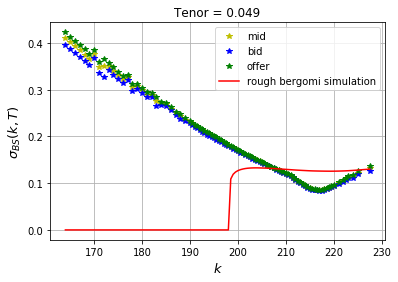

[ 0.01 -0.5   1.  ]
0.0028574843788478485 0.0009706919260176598


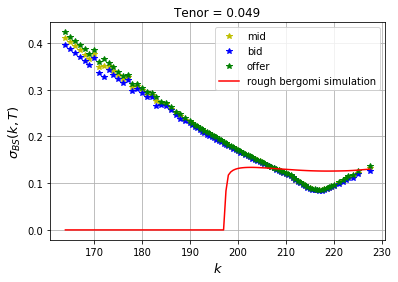

[ 0.01000001 -0.5         1.        ]
0.0027623213209567988 0.00122385978249526


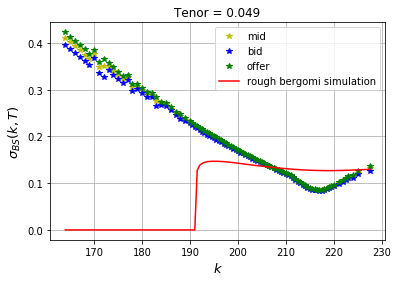

[ 0.01       -0.49999999  1.        ]
0.0018206774581280465 0.0007568476708940039


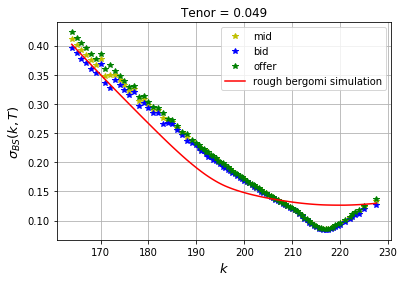

[ 0.01       -0.5         1.00000001]
0.002783150957090052 0.0012446894186285134


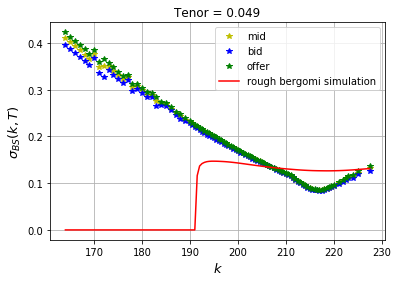

[ 0.5 -0.3  5. ]


/Users/maalej_ach/Desktop/PROJET OMA 3A/rough_volatility_proj3a_oma/rBergomi/utils.py:15: RuntimeWarning:

divide by zero encountered in double_scalars



0.0021741999490632893 0.0007249245867444487


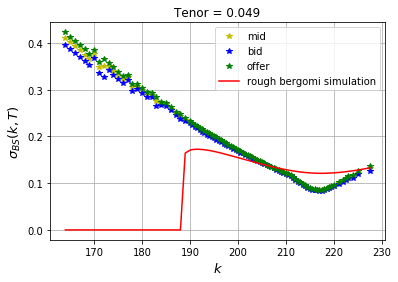

[ 0.255      -0.4         3.00000003]
0.0012170765468400204 0.00015324675960597778


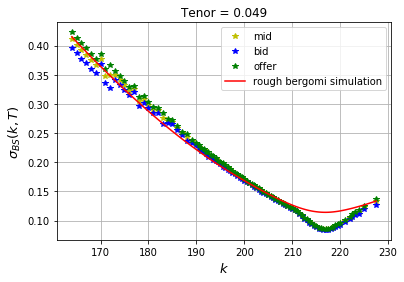

[ 0.13250001 -0.44999999  2.0000001 ]
0.0018959285558899641 0.0004466531935711234


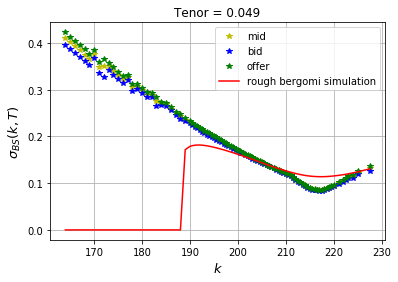

[ 0.07125001 -0.475       1.5000001 ]
0.0021273804326208275 0.0006567921973267098


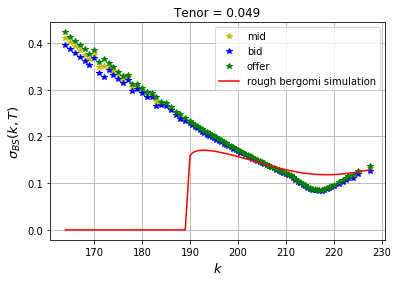

[ 0.04062501 -0.4875      1.25000008]
0.0015949219962298846 0.0005310922089958419


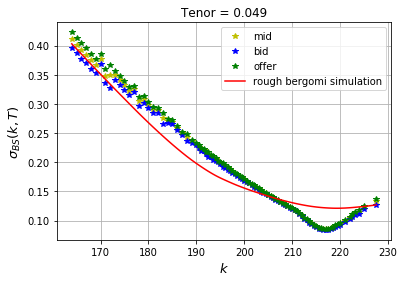

[ 0.02531251 -0.49374999  1.12500011]
0.0018085107358826917 0.0007446809486486492


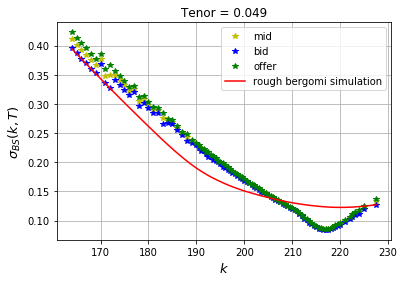

[ 0.01765626 -0.49687499  1.06250011]
0.001557651107826869 0.0004938213205928263


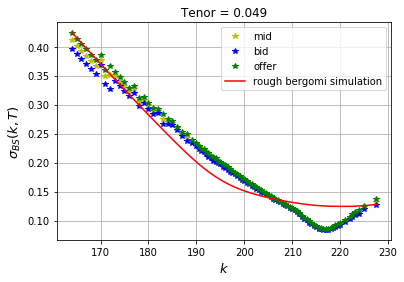

[ 0.01382814 -0.49843749  1.03125012]
0.0026799105250930595 0.0008941962393787738


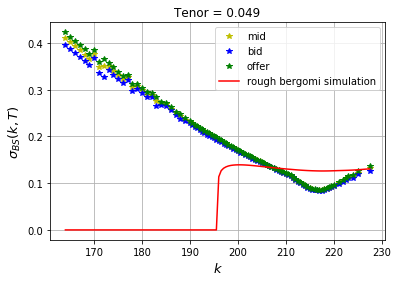

[ 0.01191407 -0.49921875  1.01562506]
0.002755477309719481 0.0012629399962866454


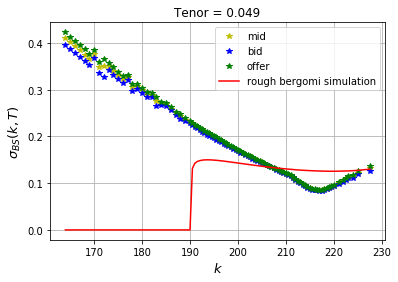

[ 0.01095704 -0.49960937  1.00781253]
0.0027456444980567605 0.000858852045226572


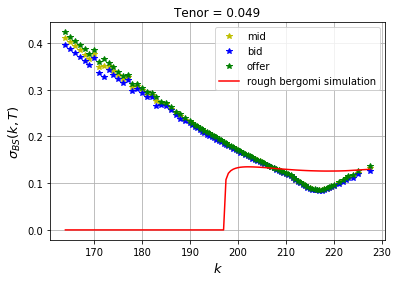

[ 0.01047852 -0.49980469  1.00390627]
0.003504959752973421 0.002441129965739378


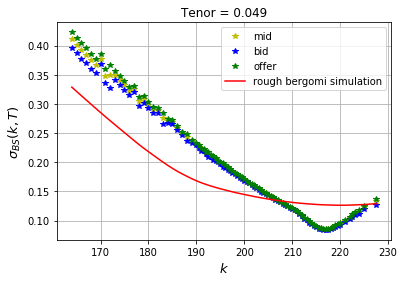

[ 0.01047852 -0.49980469  1.00390627]
0.0018013633289788035 0.0007375335417447609


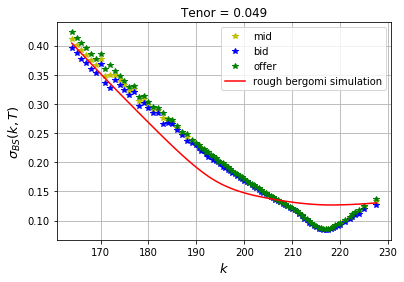

[ 0.01047853 -0.49980469  1.00390627]
0.0026631798718813105 0.0009087939069690297


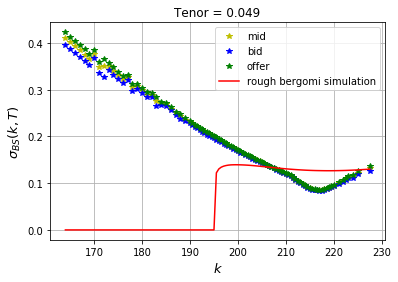

[ 0.01047852 -0.49980467  1.00390627]
0.002689128231227777 0.0010762250054213258


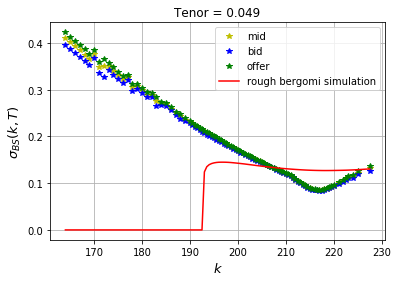

[ 0.01047852 -0.49980469  1.00390628]
0.0015646191599041532 0.0005007893726701107


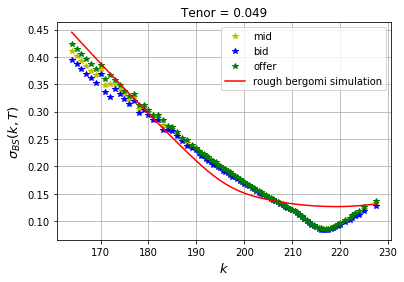

[ 1.e-03 -1.e+00  1.e-03]
0.00299980958484325 0.0010390252711177598


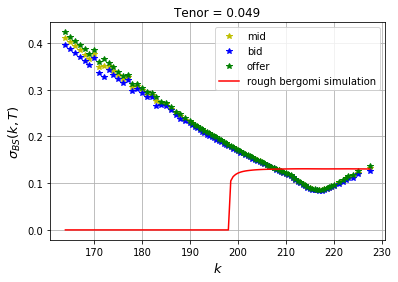

[ 0.00573926 -0.74990235  0.50245312]
0.0016483818568527962 0.0005845520696187537


KeyboardInterrupt: 

In [29]:
from scipy.optimize import fmin_slsqp


res = fmin_slsqp(func_to_minimize_fixedTenor, x0=[0.01, -0.5, 1], acc=0.00001,
                              args=(real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, 100000, 0.1, True),
                              bounds=((0.001,0.5),(-1,-0.3),(0.001,5)))


### COBYLA :

[ 0.1 -0.5  2. ]
0.001997108163286986 0.0006813186896027754


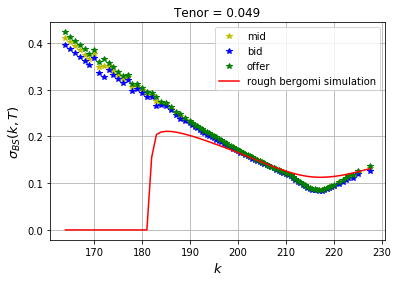

[ 0.2 -0.5  2. ]
0.002080733327444522 0.0005422717889829833


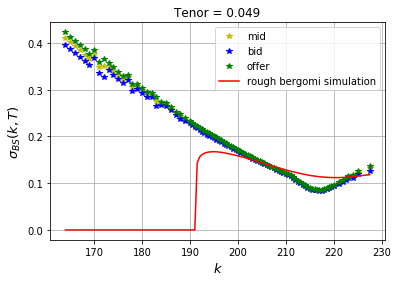

[ 0.1 -0.4  2. ]
0.0019677990422624146 0.0004972108069682969


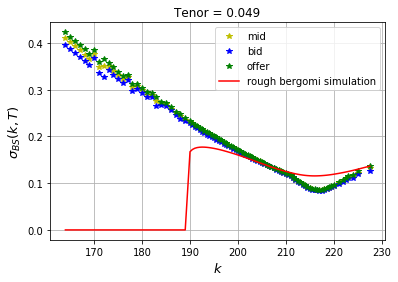

[ 0.1 -0.4  2.1]
0.001884973436841314 0.0004960845479524251


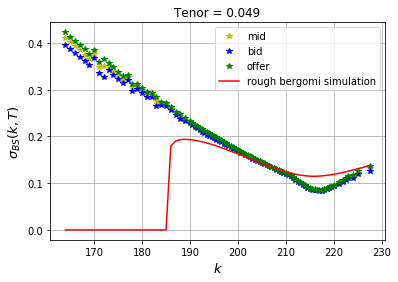

[ 0.0310559  -0.37583633  2.16828491]
0.0012955898699156224 0.00023176008268157986


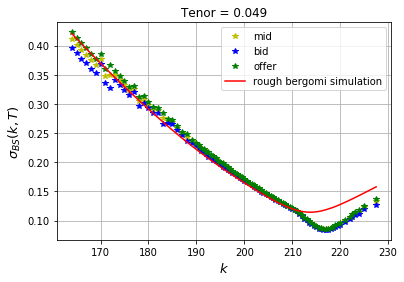

[ 0.01       -0.34322473  2.2604431 ]
0.00212056410197289 0.0007121133977475376


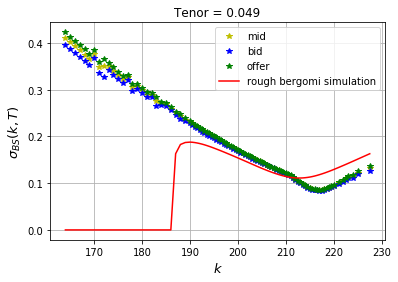

[ 0.0310559  -0.3287005   2.15160517]
0.0013456300704555795 0.0002818002832215369


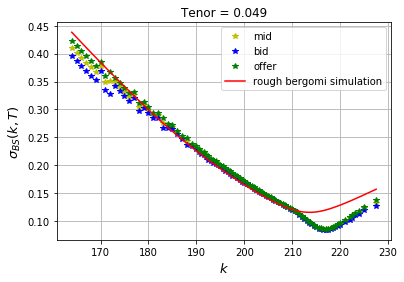

[ 0.01       -0.41527778  2.07883648]
0.0020870941232800574 0.0008966179328038671


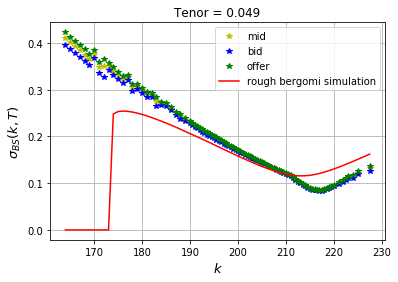

[ 0.0313574  -0.36500154  2.21709594]
0.0019158424022070876 0.000564491050855736


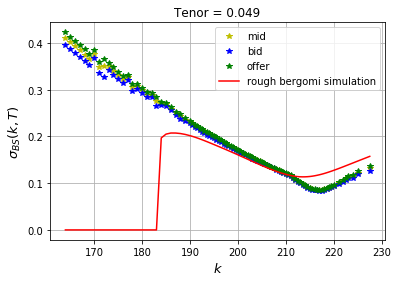

[ 0.01       -0.38133302  2.155979  ]
0.002123596253920993 0.0006950248253495642


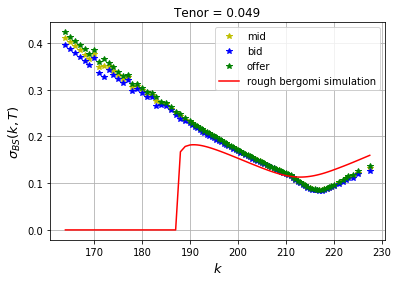

[ 0.05517976 -0.37849635  2.16228793]
0.0019233367518641871 0.0004947653232927585


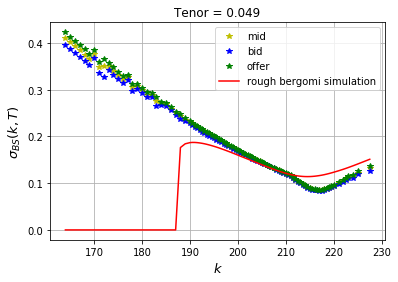

[ 0.03015163 -0.37264494  2.17771875]
0.0020628941569014727 0.0009639930580003734


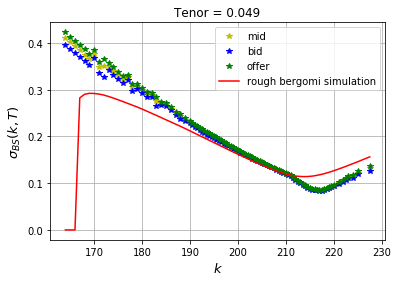

[ 0.03092888 -0.38057481  2.16987572]
0.0019399021184792328 0.0005510132295903437


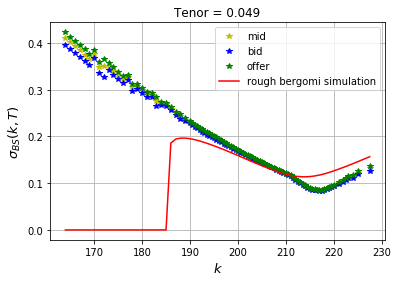

[ 0.02825525 -0.36974382  2.16086617]
0.0015194359730086849 0.0004556061857746423


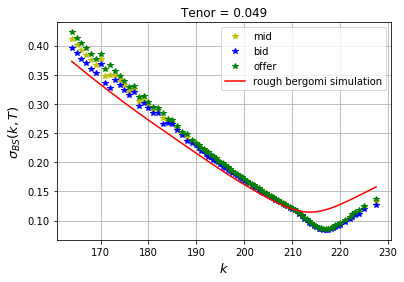

[ 0.03568148 -0.37394798  2.16808948]
0.0014804565587159472 0.0004166267714819046


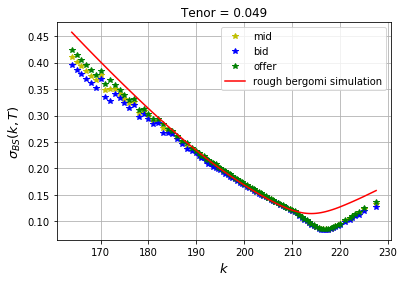

[ 0.03083789 -0.38477349  2.16380388]
0.0020328065620601075 0.0006042351334886787


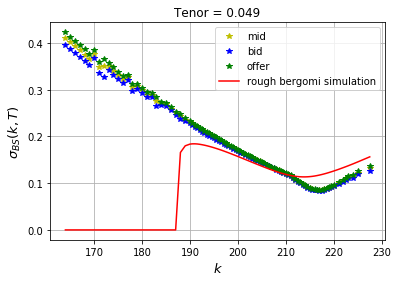

In [30]:
from scipy.optimize import fmin_cobyla



def constr1(x):
    return x[0] - 0.01

def constr2(x):
    return 0.4 - x[0]
    
def constr3(x):
    return x[1]+1

def constr4(x):
    return -0.3 - x[1]

def constr5(x):
    return x[2] - 0.01

def constr6(x):
    return 5 - x[2]

res = fmin_cobyla(func_to_minimize_fixedTenor, x0=[0.1, -0.5 , 2], 
                  cons = [constr1, constr2,constr3,constr4,constr5,constr6], 
                            args=(real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, 100000, 0.1, True), 
                  consargs=(), rhobeg = 0.1, rhoend=0.01, disp=3)


In [162]:
res

array([ 0.25021555, -0.6974563 ,  0.14993942,  2.00078467])

In [144]:
res # tenor[1]

array([ 0.02265572, -0.31538744,  0.07827107,  2.48133172])

In [104]:
res #tenor[10]

array([ 0.22799665, -0.91310494,  0.14952638,  1.99820058])

### Different evolution :

In [31]:
from scipy.optimize import differential_evolution

In [32]:
tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
tenor_list_sample = tenor_list_unique[3::2]

In [33]:
tenor_list_sample

[0.0684931506849315,
 0.12602739726027398,
 0.29863013698630136,
 0.7972602739726028]

In [151]:
best_params_list = []
spot = df_iv_groupBy["spot"].values[0]
start_time = time.time()
for tenor in tenor_list_sample:
    print("tenor = ",tenor)
    strike_list = np.array([df_iv_groupBy.loc[tenor].index])
    real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
    sigma0 = find_sigma0(df_iv_groupBy,tenor)
    N = 100000
    if tenor>0.3:
        N = 30000
    res = differential_evolution(func_to_minimize_fixedTenor, disp = True, workers=-1, maxiter=20,
                              args=(real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N, 0.1, False),
                              bounds=((0.03,0.3),(-0.9,-0.7),(1.5,3.5)))
    best_params_list.append(res.x)
print("--- %s seconds ---" % (time.time() - start_time))

tenor =  0.10136986301369864
[ 0.09518882 -0.87629433  2.6043389 ]
[ 0.10620512 -0.89297301  2.90519231]
[ 0.03822103 -0.81773773  1.94371529]
[ 0.24009244 -0.74254826  1.52892237]
0.0027176201536028097 0.00039203875825397246
[ 0.05071815 -0.7523428   3.3106192 ]
0.0027324423264785446 0.00035148994552616325
[ 0.18067651 -0.78931035  1.94985449]
0.002308991204030733 0.0005232769183164474
[ 0.2154482  -0.82472504  2.55586335]
0.0020709974979137083 0.0002852832121994226
[ 0.19076783 -0.7246856   1.70891493]
0.001887263398857425 0.00010154911314313932
[ 0.11934022 -0.76291373  2.3669478 ]
0.002236228921064787 0.0004505146353505017
[ 0.22859861 -0.76112543  1.57210434]
0.002077285819141849 0.0002915715334275631
[ 0.16219878 -0.72829699  2.74434275]
0.001849478746756678 6.376446104239242e-05
[ 0.21932854 -0.7350113   2.92783609]
0.002722711487406319 0.0005004892651840968
[ 0.10179575 -0.79492625  2.17199506]
0.00199991270237575 0.00011312024954556114
[ 0.23794903 -0.74560572  2.45510528]
0.0

[ 0.1882483  -0.76687514  1.643984  ]
0.0020766086797186704 0.00029089439400438466
[ 0.16060051 -0.79433113  2.06852846]
0.0019720417668285892 0.00018632748111430366
[ 0.23794903 -0.75535065  2.45510528]
0.0019893503081914576 0.00020363602247717178
[ 0.18014806 -0.70431114  2.42744161]
0.001846507715835602 6.0793430121316384e-05
[ 0.09146151 -0.7188485   2.41034898]
0.001964246566185687 0.0001785322804714013
[ 0.24105966 -0.72473747  2.63034119]
0.002058370194273949 0.000272655908559663
[ 0.25915168 -0.77000692  2.80994513]
0.0019567033636361604 0.0001385215454543423
[ 0.26475153 -0.70646117  2.76238204]
0.0021469846752121755 0.0003612703894978899
[ 0.13544855 -0.84201089  2.03278866]
0.0018247363621586798 3.902207644439421e-05
[ 0.23200013 -0.79303215  2.29499694]
0.0022698210886820413 0.0004841068029677558
[ 0.17827767 -0.80908377  2.33572984]
0.0018207458148122306 3.5031529097945026e-05
[ 0.16773358 -0.75903194  1.51660617]
0.002098075480931385 0.00031236119521709925
[ 0.13277138 -0

[ 0.15012563 -0.78445367  1.99291338]
0.002096474473719647 0.0001733975506427236
[ 0.22623757 -0.89533096  3.38891098]
0.0018814329551813142 9.571866946702857e-05
[ 0.20935661 -0.75023083  2.67165439]
0.002014941279308496 0.00022922699359421064
[ 0.14959188 -0.84610413  3.11530423]
0.0018578623896448945 7.214810393060884e-05
[ 0.20554578 -0.80445744  2.34002742]
0.0024139626440094234 0.0006282483582951378
[ 0.23780665 -0.83974616  2.4183829 ]
0.0019288021284520893 0.0001430878427378037
[ 0.29313442 -0.74320765  3.07044909]
0.002418749578632448 0.0006330352929181625
[ 0.2596912  -0.82143325  3.00041863]
0.0019548801874123456 0.0001691659016980601
[ 0.17418763 -0.75745037  3.38564466]
0.002129543284245202 0.00034382899853091606
[ 0.2115057  -0.87314024  2.66559213]
0.0019301213147189305 0.00014440702900464495
0.002097933121074063 0.00031221883535977724
[ 0.29206124 -0.79426053  2.9206729 ]
[ 0.1911352  -0.88436816  1.80902554]
0.0027444343220498287 0.0009587200363355429
[ 0.28392391 -0.7

[ 0.27578962 -0.81366635  2.13216093]
0.0018291637915289565 4.344950581467087e-05
[ 0.28194786 -0.7903599   2.7578959 ]
0.0018307148250197055 4.5000539305419797e-05
[ 0.25857641 -0.74174262  2.85924362]
0.002603217830400644 0.0008175035446863584
[ 0.24326191 -0.82821176  2.59219694]
0.0025604104020345796 0.0007746961163202938
[ 0.06949634 -0.8366687   1.80344403]
0.0021952320652694423 0.00023444775154395225
[ 0.13326725 -0.83059761  2.01122496]
0.0019570115786802693 0.0001712972929659836
[ 0.04599473 -0.75606523  2.25190887]
0.002060209077848201 0.0002744947921339154
[ 0.2099949  -0.83297298  2.26766151]
0.0018854207207001272 9.970643498584152e-05
[ 0.25675931 -0.7729598   2.09561524]
0.001892911663476158 0.00010719737776187239
[ 0.2218649  -0.71798184  2.26753632]
0.002052973635355219 0.00026725934964093344
0.0022315115575211996 0.00023151155752119948
[ 0.29713635 -0.83764487  2.14154778]
0.0020197125329747276 0.0001329200801445388
[ 0.21640637 -0.72905972  2.31198628]
0.0019058266355

[ 0.04058509 -0.71798184  1.84813116]
0.0019067040488548992 0.00012098976314061367
0.002027971147636506 0.00024225686192222033
[ 0.08297304 -0.70914779  2.18884442]
0.001935239008125938 0.00014952472241165225
[ 0.16315476 -0.73847973  3.06993775]
0.0019227441525948167 0.0001370298668805309
[ 0.14517539 -0.73430829  2.64027173]
0.001877864682721126 9.215039700684036e-05
[ 0.09660881 -0.77620668  2.6087485 ]
0.0019809413987614136 0.00019522711304712778
[ 0.1648268  -0.78622839  2.3665027 ]
0.0020068901741034095 0.0002211758883891239
[ 0.11768323 -0.87765291  2.33835168]
0.0021496906085207634 0.0003639763228064776
0.0019546661152246656 0.00016895182951037988
0.001966802578881199 0.00018108829316691374
[ 0.12438651 -0.7246856   2.13720588]
[ 0.16764938 -0.83533352  1.99796997]
[ 0.21658031 -0.88945158  2.05461321]
[ 0.07925105 -0.78739339  2.12943772]
differential_evolution step 8: f(x)= 0.00181207
0.002206542446416767 0.00020654244641676696
[ 0.26504083 -0.74799699  2.44565488]
0.00193478

[ 0.21960013 -0.74262052  2.08635925]
[ 0.17820144 -0.75913568  2.19654202]
[ 0.11839124 -0.73944683  1.71970537]
differential_evolution step 10: f(x)= 0.00181207
0.002012709364284568 0.00022699507857028224
[ 0.18067651 -0.70381142  2.44973746]
0.0020105999991382913 0.0002248857134240054
[ 0.27622737 -0.80300692  2.67426954]
0.0020633412478879226 0.00027762696217363704
[ 0.11692435 -0.71197284  2.03663351]
0.002335707514599272 0.0004489150617690833
[ 0.21363802 -0.76340295  1.83757289]
0.001894615699953341 0.0001089014142390554
[ 0.22879909 -0.84735431  1.6131519 ]
0.0018684678111285276 8.275352541424191e-05
[ 0.1944335  -0.71857074  2.51998036]
0.0018327773296205531 4.70630439062674e-05
[ 0.12643749 -0.76394614  1.82674093]
0.0018439807478263161 5.8266462112030425e-05
[ 0.18833196 -0.70016376  2.17582199]
0.0018448650885421348 5.915080282784909e-05
[ 0.28159352 -0.72931529  2.39472457]
0.0021775405810682416 0.00039182629535395593
[ 0.15986888 -0.71128514  2.01514779]
0.002089243612276

0.0021223612611709925 0.00033664697545670696
[ 0.17938058 -0.72468604  2.20011563]
0.0020433844253873756 0.0002576701396730899
[ 0.17938032 -0.72468566  2.20011282]
0.001819476709786066 3.3762424071780465e-05
[ 0.17938033 -0.72468566  2.20011282]
0.0019558466295473164 0.0001701323438330306
[ 0.17938032 -0.72468565  2.20011282]
0.0018622009500711392 7.648666435685355e-05
[ 0.17938032 -0.72468566  2.20011283]
0.0018231707119315528 3.745642621726719e-05
[ 0.17938028 -0.72468567  2.2001127 ]
0.002080683035644538 0.0002949687499302522
[ 0.17938029 -0.72468567  2.2001127 ]
0.0018182439165971072 3.252963088282153e-05
[ 0.17938028 -0.72468566  2.2001127 ]
0.0020787224020663467 0.00029300811635206084
[ 0.17938028 -0.72468567  2.20011271]
0.0020380317844158483 0.00018617993256399653
[ 0.17938031 -0.72468566  2.20011277]
0.0019260810598437548 0.00014036677412946906
[ 0.17938032 -0.72468566  2.20011277]
0.0018518848447557305 6.617055904144485e-05
[ 0.17938031 -0.72468565  2.20011277]
0.00191731112

[ 0.16478371 -0.73772504  1.61618358]
0.0019369083672214021 0.0008499518454822717
[ 0.26501139 -0.89703805  2.29396412]
0.0018677468321662005 0.0007807903104270701
[ 0.27150656 -0.72157519  2.52254448]
0.0011512047919178675 6.424827017873716e-05
[ 0.1709083  -0.89008054  2.49338527]
0.0011939164753979729 0.00010695995365884245
[ 0.22249792 -0.73637164  2.36111151]
0.0020883989498299274 0.0009894978509288283
[ 0.21693462 -0.8440718   2.68173979]
0.00218041991142331 0.0010934633896841795
[ 0.14469664 -0.80676571  2.41540471]
0.001671189701377738 0.0005842331796386075
[ 0.11126264 -0.75395317  2.50341347]
0.0012108767504970318 0.00012392022875790134
[ 0.13079898 -0.72449942  1.95764453]
0.0019366951450843794 0.000849738623345249
[ 0.27828918 -0.81399392  1.57793657]
0.0015022641191227639 0.00041530759738363335
[ 0.1399291  -0.79659101  2.17875699]
0.001296612966764626 0.00020965644502549553
[ 0.24680095 -0.88902928  2.07582919]
0.0011031787618669378 1.6222240127807295e-05
[ 0.21463056 -0.

[ 0.25114309 -0.80602921  2.89234437]
0.001384049986273651 0.00029709346453452056
[ 0.1399291  -0.70672801  1.72748976]
0.0011788914999476812 9.193497820855079e-05
[ 0.09093345 -0.76705353  2.05217503]
0.001738277399738855 0.0006513208779997245
[ 0.03724116 -0.7909004   2.13415568]
0.0015180504596477135 0.0002834825584131457
[ 0.24881231 -0.78279049  2.30121141]
0.0019705697248937957 0.0008836132031546654
[ 0.09840317 -0.70890649  1.73643059]
0.0011004392543220206 1.348273258289015e-05
[ 0.08767482 -0.75271995  2.02718098]
0.0016388585876001907 0.0004760678899257721
[ 0.16266201 -0.76319301  2.25997105]
0.0012596335732426198 0.00017267705150348948
[ 0.18418973 -0.85434311  2.15274213]
0.001690808125543287 0.0006038516038041566
[ 0.10253497 -0.79351352  2.25663502]
0.0012164446999187535 0.00012948817817962313
[ 0.052314   -0.80315009  2.66308989]
0.0012426889390269769 0.00015573241728784632
[ 0.07752239 -0.73836333  2.61483866]
0.001330912368784488 0.00024395584704535762
[ 0.24578654 -0

[ 0.10253497 -0.77361896  1.97191272]
0.00158613506518668 0.0004872339662855809
[ 0.16412732 -0.80315009  2.19137942]
0.001186020811705052 9.90642899659216e-05
[ 0.05213455 -0.75921771  1.82631312]
0.0012547955812197641 0.00016783905948063364
[ 0.09357249 -0.80151945  2.09946873]
0.0011052857949754105 1.8329273236280058e-05
[ 0.11869662 -0.73918274  2.05886926]
0.0011666722074132928 7.971568567416238e-05
[ 0.03336847 -0.77968906  2.30360864]
0.0011934649739812734 0.000106508452242143
0.0012053601313480806 0.00011840360960895016
[ 0.09713478 -0.74963307  1.71744649]
0.0012891213039967924 0.00020216478225766195
[ 0.1073989  -0.75741851  2.18575792]
0.0014359786008592346 0.0003490220791201041
[ 0.07531913 -0.7556743   1.94092251]
0.001664212748709303 0.0002943497350106729
[ 0.12237551 -0.72365073  1.94484023]
0.001203168354994469 0.00011621183325533865
[ 0.11531348 -0.77406697  2.01561569]
0.0011181540570853938 3.1197535346263386e-05
[ 0.04485125 -0.75111859  2.04718768]
0.001369904696649

0.0012266568410935993 0.00013970031935446885
[ 0.20141027 -0.81601621  2.04412451]
0.0015353686469329166 0.000344892456456726
[ 0.0640915  -0.81084597  1.86152268]
0.0011434708756330528 5.6514353893922374e-05
[ 0.17497873 -0.79356593  1.8091726 ]
0.0012473879093452477 0.00016043138760611736
0.0011753168916108856 8.836036987175517e-05
0.0011767814213006797 8.982489956154927e-05
[ 0.15831112 -0.76185091  2.54857476]
[ 0.11074119 -0.81464184  2.26700963]
[ 0.13891529 -0.81660813  1.72639856]
[ 0.05929952 -0.80017512  2.31044067]
differential_evolution step 7: f(x)= 0.00110044
0.001369993989922361 0.00028303746818323045
[ 0.16762292 -0.76069883  1.87336508]
0.00121483079410152 0.0001278742723623897
[ 0.0446175  -0.79307908  2.03821508]
0.0012458447696143693 0.00015888824787523877
[ 0.11497892 -0.72121517  2.00597231]
0.0013241380458865137 0.00022523694698541453
[ 0.09896269 -0.79838134  1.69799817]
0.001167950399380862 8.099387764173151e-05
[ 0.12223389 -0.80515001  2.23635134]
0.001152974

[ 0.13102621 -0.74407881  1.56702162]
0.0013386153007283268 0.0002516587789891965
[ 0.12053818 -0.81689183  2.3093089 ]
0.0013475273820580625 0.0002605708603189321
[ 0.14969961 -0.84888614  1.91272591]
0.0011974072044310803 0.00011045068269194983
[ 0.07725357 -0.74504703  2.29649656]
0.001288454794001709 0.0002014982722625786
[ 0.12128602 -0.72724522  2.46493561]
0.0011254160321077869 3.845951036865653e-05
[ 0.1288162  -0.88598812  2.44052094]
0.0012039352707110744 0.00011697874897194385
[ 0.06705149 -0.80340373  2.36956428]
0.001199956722851183 0.00011300020111205265
[ 0.07632743 -0.73336497  2.06745654]
0.0017266598860003638 0.0006397033642612333
[ 0.0944861  -0.71693739  1.98235442]
0.0012392826519940692 0.00015232613025493877
0.0011283566866982248 4.140016495909436e-05
[ 0.12246932 -0.74687229  2.05882408]
[ 0.10065614 -0.78395365  1.93306559]
0.0011129955755597137 2.6039053820583206e-05
[ 0.08611235 -0.82039947  2.28376013]
0.0013441796429921327 0.0002572231212530021
0.00138399641

0.0012467306837384592 0.00015977416199932878
[ 0.099434   -0.77187109  2.04248794]
0.0010994813830861904 1.2524861347059993e-05
[ 0.12536683 -0.84836225  2.20256748]
0.0011644827967851865 7.752627504605603e-05
[ 0.05612357 -0.73650416  1.95108376]
0.0014155328853561065 0.0003285763636169761
0.0011243983082938234 3.7441786554693e-05
[ 0.15771365 -0.72845197  1.96027802]
[ 0.03578879 -0.75121986  2.11951445]
0.0012162455412736044 0.00010513443016249326
[ 0.06218683 -0.83509184  2.03355862]
0.001483912495453218 0.00027909321834478405
[ 0.13303716 -0.82995887  2.00034438]
0.001237247154361978 0.0001502906326228476
[ 0.18879996 -0.80093744  2.35966117]
0.0014348797764437344 0.00034792325470460407
[ 0.07107471 -0.78671839  1.72554621]
0.0011323204936913756 4.53639719522451e-05
[ 0.28737625 -0.83324564  1.9219662 ]
0.001430395248392581 0.00034343872665345036
[ 0.1251412  -0.80708078  2.1915464 ]
0.0016044773704169562 0.0003699094691823884
[ 0.1399291  -0.75476741  2.09772072]
0.00157964920693

0.0012910037342478945 0.00020404721250876406
[ 0.1497421  -0.72778055  1.84587443]
0.001444581107602539 0.00035762458586340853
[ 0.12146838 -0.7359281   1.85968587]
0.001385014857245532 0.0002980583355064017
[ 0.21875778 -0.70633573  2.09591077]
0.0013383455417293538 0.00025138901999022326
[ 0.06518117 -0.72449942  1.95764453]
0.001124497223547726 3.754070180859554e-05
[ 0.05458801 -0.782196    1.96872239]
0.0011438258566750913 5.686933493596096e-05
[ 0.16189427 -0.72951223  2.00357135]
0.0015261650601989716 0.00043920853845984124
[ 0.07028635 -0.77124086  1.99092945]
0.0011337231478863105 4.6766626147179976e-05
[ 0.06829712 -0.75305659  1.9796758 ]
0.001139856669332636 5.290014759350565e-05
[ 0.10390379 -0.79531974  2.25997105]
0.0013678081900771882 0.0002808516683380578
[ 0.19549588 -0.76016643  2.17645907]
0.0015633632806583714 0.0003133632806583713
[ 0.13382687 -0.72055628  2.03328503]
0.0015293747127514453 0.0002635519279413188
[ 0.07017657 -0.81051546  2.03325726]
0.0013653507647

[ 0.24824101 -0.83901445  2.27727034]
0.0013082240440809025 0.00022126752234177208
[ 0.04881666 -0.85118392  2.00114102]
0.0011933114871136624 0.00010635496537453195
[ 0.1431651  -0.74057671  2.01121098]
0.0011229136093196081 3.595708758047773e-05
[ 0.1119117  -0.76597696  2.14987607]
0.0013715555049467571 0.0002845989832076268
[ 0.19454059 -0.75510722  2.03325726]
0.0014447096991548375 0.000357753177415707
[ 0.07032175 -0.79218576  1.9403341 ]
0.001118406604447901 3.145008270877044e-05
0.0011679011350839244 8.094461334479382e-05
[ 0.07198089 -0.82086267  1.91536036]
[ 0.0559857  -0.76844255  1.80305988]
0.0012809795755316727 0.00019402305379254232
0.0016353919658228236 0.0003196024921386131
[ 0.13950458 -0.74700689  1.94092251]
0.001111954273658031 2.4997751918900497e-05
[ 0.07345422 -0.72491293  1.70823661]
0.0011330830522417973 4.6126530502666764e-05
[ 0.0794161  -0.80377694  2.14933395]
0.0011348149543458582 4.785843260672782e-05
[ 0.11841498 -0.8157706   2.2659864 ]
0.001532305120

[ 0.13056991 -0.77680984  2.24924166]
0.0014408672231168971 0.00035391070137776655
[ 0.04888235 -0.83837256  2.26625631]
0.0014223384577764892 0.00024586786954119505
[ 0.08637342 -0.78565838  1.62527966]
0.0012475592132307834 0.00016060269149165298
[ 0.07540914 -0.75973486  2.04412451]
0.0015979368646098268 0.0005109803428706962
[ 0.0657664  -0.78588669  2.07070014]
0.0013611153081514644 0.0002622142092503652
[ 0.09565777 -0.73694961  2.17015285]
0.0013953573802713173 0.0002048811897951268
0.0013635981586164374 0.00020080746094201885
0.0011255942693139329 3.863774757480252e-05
[ 0.14275628 -0.77593148  1.92318125]
[ 0.11692479 -0.81503756  2.04545293]
[ 0.09212635 -0.7814437   2.11428972]
[ 0.18043377 -0.76366084  2.07591935]
differential_evolution step 18: f(x)= 0.00109948
0.0013262567418788156 0.00016346604420439708
[ 0.07250268 -0.82181037  2.06087709]
0.0014376314822603445 0.0003506749605212141
[ 0.06003042 -0.81066796  2.27115431]
0.0012267871601416515 0.00013983063840252095
0.001

0.0011665509075506502 7.959438581151972e-05
[ 0.08883985 -0.77593147  2.11028948]
0.0011123271697333844 2.537064799425392e-05
[ 0.08883985 -0.77593148  2.11028949]
0.001098957340868888 1.2000819129757598e-05
[ 0.03 -0.7   3.5 ]
0.002328290569972626 0.0012413340482334957
[ 0.03000001 -0.7         3.5       ]
0.0020009122014117402 0.00091395567967261
[ 0.03       -0.69999999  3.5       ]
0.001900500333830218 0.0008135438120910875
[ 0.03       -0.7         3.50000001]
0.0018524278453276354 0.0007654713235885049
[ 0.08543024 -0.77153145  2.1908195 ]
0.001200711076619241 0.0001137545548801106
[ 0.08543025 -0.77153145  2.1908195 ]
0.0012119357487930802 0.000100824637681969
[ 0.08543024 -0.77153144  2.1908195 ]
0.0013024083955975496 0.00016604475923391322
[ 0.08543024 -0.77153145  2.19081951]
0.0011192841207376485 3.232759899851816e-05
[ 0.0881615  -0.77505609  2.12631101]
0.0011448076286289818 5.7851106889851387e-05
[ 0.08816151 -0.77505609  2.12631101]
0.0012066135909320132 0.00011965706919

[ 0.15347949 -0.86104872  1.96161234]
0.0017193635618581787 0.0007092625517571685
[ 0.07767404 -0.83822638  3.49194597]
0.0014950924684704666 0.0004849914583694563
[ 0.27794828 -0.71072565  1.81239675]
0.002139679969727681 0.0011295789596266709
[ 0.24611002 -0.79719922  2.67216631]
0.0012930685906033773 0.000282967580502367
0.0020688006885723315 0.0010586996784713212
[ 0.29613705 -0.89386093  1.58647141]
0.0012953634847965427 0.00023153369756250005
[ 0.18341122 -0.72960575  3.23457838]
0.001260479828555417 0.0002503788184544068
[ 0.25655392 -0.80826998  3.33246862]
0.001260936538667797 0.0001856677214634957
[ 0.11191333 -0.81294463  2.30137838]
0.0017384241042942739 0.0007283230941932636
[ 0.10354127 -0.7613083   2.1321387 ]
0.0017925363844574786 0.0007824353743564683
[ 0.18915103 -0.8897987   2.47857505]
0.001763924194937891 0.0007538231848368805
0.0016119282511159261 0.0006018272410149159
0.00208618069984148 0.0010760796897404698
[ 0.10012764 -0.87938803  2.03200829]
[ 0.29568231 -0.

[ 0.13307405 -0.74229241  2.3357953 ]
0.0018072723794889999 0.0006167961890128093
0.0011907362779295047 0.00013810469898213625
0.0011444801073672481 0.00013437909726623785
[ 0.0859155  -0.7777961   1.94574736]
[ 0.23668762 -0.84257855  2.10391708]
[ 0.10036521 -0.76483258  1.95422236]
[ 0.07187445 -0.87234277  2.23873619]
differential_evolution step 2: f(x)= 0.00103417
0.0012915461754251577 0.0002389145964777893
[ 0.1180541  -0.88643401  2.0041751 ]
0.0014891366673518362 0.00047903565725082586
[ 0.0835357  -0.88776757  2.3298733 ]
0.0010236044236692026 1.350341356819229e-05
[ 0.04921031 -0.87923762  1.73296859]
0.0013474540184984266 0.000283624231264384
[ 0.11010901 -0.72321533  2.62856972]
0.001340691417729756 0.00033059040762874566
[ 0.13917893 -0.87338943  1.91860615]
0.0010697240873239688 5.962307722295854e-05
[ 0.1075643  -0.76757258  2.22335842]
0.001424646591813257 0.0003608168045792144
[ 0.15547715 -0.87333728  2.93748404]
0.0011129496880473459 0.00010284867794633549
[ 0.110202

[ 0.06987956 -0.79909691  2.09190611]
0.001242257658843184 0.00023215664874217371
[ 0.11143068 -0.71714441  2.05664265]
0.0011416022040006192 0.00013150119389960876
[ 0.1818783  -0.72340757  1.71562394]
0.0014213356797286283 0.00041123466962761796
[ 0.24448448 -0.71358436  1.76692513]
0.0015832516028397282 0.0005731505927387178
[ 0.10516472 -0.76060664  2.44705706]
0.0012529674803254166 0.00024286647022440632
[ 0.10607624 -0.76680865  1.80346949]
0.0015140742518543887 0.0004029631407432776
[ 0.09246271 -0.82056594  2.17373099]
0.0010749865571171532 4.405872206560688e-05
[ 0.29206686 -0.85464721  1.94404264]
0.0011253083245882133 7.26767456408449e-05
[ 0.06075242 -0.78159006  1.75894072]
0.0016145107985325066 0.0006044097884314964
[ 0.2008934  -0.80456959  1.60833324]
0.0011001950402197824 5.8528373553115625e-05
[ 0.090833   -0.7961497   2.09565866]
0.0018201382564734386 0.0007892104214218923
[ 0.10657746 -0.79585939  2.22238875]
0.0012465121992011738 0.0001938806202538054
[ 0.0960191  

[ 0.21227277 -0.80205297  2.04969541]
0.0013452997860676282 0.0003036331194009616
[ 0.08748216 -0.82035386  2.22238875]
0.001097925883156339 8.782487305532875e-05
[ 0.07988821 -0.77579343  2.59538934]
0.001241750902807226 0.00023164989270621565
[ 0.24324391 -0.71264346  1.84418106]
0.0011570473958687206 0.00014694638576771024
[ 0.20752773 -0.76572228  1.83227208]
0.0013399632152034874 0.00032986220510247704
[ 0.20736728 -0.79098724  1.63684674]
0.0013525338572047548 0.0003424328471037445
[ 0.10649595 -0.89005353  2.10541101]
0.0015257707000355214 0.00038940706367188475
[ 0.12577778 -0.70419013  2.33353963]
0.0011590949506057895 0.0001489939405047792
0.0010630421725678718 5.2941162466861436e-05
[ 0.06146362 -0.76700793  2.16731424]
[ 0.11666456 -0.80120547  1.82077596]
0.0013428385789752857 0.0002790087917412431
[ 0.1316118  -0.76689041  2.97286729]
0.001774647889262296 0.0007645468791612858
[ 0.03407754 -0.77019413  2.00898441]
0.0014797443327820411 0.0004696433226810308
[ 0.20889372 -

[ 0.18020857 -0.74747545  2.12573159]
0.0015082370185481586 0.0004981360084471484
[ 0.14126171 -0.87819519  2.54332027]
0.0010628354299735713 5.2734419872560995e-05
[ 0.11514082 -0.81518226  2.52055512]
0.0011141802793750296 0.00010407926927401922
0.0013319881180365667 0.00026815833080252427
[ 0.05166728 -0.74292117  2.18591124]
[ 0.11193392 -0.74880604  1.80870212]
0.0015572060772316672 0.0005471050671306569
[ 0.20889372 -0.774113    2.19195061]
0.0016202258727146188 0.0006101248626136086
[ 0.18216845 -0.75783214  2.28977405]
0.0012415735936769764 0.000188942014729608
0.001241595971469348 0.0002314949613683376
[ 0.08344995 -0.89039147  1.87427048]
[ 0.09801917 -0.74361176  2.80298759]
0.0016879292245386504 0.0006778282144376401
[ 0.11795013 -0.89304546  1.7696285 ]
0.0014155683284284837 0.00040546731832747344
[ 0.13361134 -0.83877672  2.18451522]
0.001528621205355813 0.0005185201952548026
[ 0.21381033 -0.70273057  1.61221116]
0.0013430781111836224 0.000332977101082612
[ 0.04585669 -0.

[ 0.17756141 -0.7263207   1.59452437]
0.0011692577982133974 0.0001166262192660291
[ 0.05333549 -0.81551841  1.89144507]
0.0014044020751376293 0.0003627354084709627
[ 0.08931494 -0.72781409  2.85396262]
0.0012275370351332972 0.00017490545618592892
[ 0.0344078  -0.8293187   2.25150831]
0.0012332595611361412 0.0001806279821887729
0.0016705858085740146 0.0006604847984730042
[ 0.13423813 -0.73714949  2.34970089]
0.0011997727240675167 0.00016884488901597027
[ 0.03539788 -0.76152098  2.18129363]
0.001554464584329114 0.0005443635742281037
[ 0.10041317 -0.75125172  1.7085057 ]
0.0010764293969593756 6.632838685836528e-05
[ 0.03642534 -0.74669027  2.16369834]
0.00159721806122157 0.0005871170511205596
[ 0.14477523 -0.74934286  2.09113263]
0.0011236483641332534 8.198169746658674e-05
[ 0.05118853 -0.74986335  2.18763382]
0.0013310108021747152 0.0003000829671231687
0.0011651883766264646 0.0001447802133611585
0.0010765309514043982 6.642994130338799e-05
[ 0.04878399 -0.73675105  1.90525662]
[ 0.1923600

0.0013051039740861407 0.00029500296398513043
[ 0.16273719 -0.76743735  2.18763382]
0.001233544554682353 0.00022344354458134276
0.0012441445956572152 0.00023404358555620478
0.0015005622202255136 0.0004904612101245032
[ 0.19236002 -0.7907006   1.87605839]
[ 0.10137283 -0.73675105  2.06756325]
[ 0.03671707 -0.7913345   1.87480845]
[ 0.19418448 -0.74635785  1.63324439]
differential_evolution step 13: f(x)= 0.00102333
0.0012226782094434895 0.00021257719934247927
0.0016846087015946448 0.0006207789143606022
[ 0.15499884 -0.72321533  1.78559125]
[ 0.13036999 -0.7109581   1.86946499]
0.0011624260156109152 0.0001523250055099049
[ 0.03414874 -0.86551974  1.80127246]
0.0010830630758565506 7.29620657555403e-05
[ 0.10464632 -0.82696076  1.94193225]
0.001099850448427311 5.8183781760644347e-05
[ 0.14774183 -0.80767291  2.00750421]
0.0010247186885337658 1.4617678432755445e-05
[ 0.27887113 -0.7500518   2.34576502]
0.0010671822618005472 3.625442674900091e-05
[ 0.03285782 -0.77543149  1.76692513]
0.001159

0.0014394424260793623 0.0003756126388453197
[ 0.22327999 -0.74676685  1.70682639]
0.0010678354975061453 5.7734487405134854e-05
[ 0.11273633 -0.73062183  2.04036042]
0.0010482579395313478 3.815692943033746e-05
[ 0.09905354 -0.73692427  2.1039813 ]
0.0013745407236839067 0.00036443971358289626
[ 0.11559231 -0.74884931  2.16704262]
0.0011742025530042674 0.00014327471795272102
[ 0.0968431  -0.78213664  2.05876544]
0.0010366905037601129 2.6589493659102544e-05
0.0010794979796835062 6.939696958249579e-05
0.001234828288095871 0.00022472727799486072
[ 0.12936704 -0.81529174  2.15686692]
[ 0.17120108 -0.75944521  1.80709987]
[ 0.03128403 -0.74821213  2.18140077]
0.001169763774639409 0.0001596627645383985
[ 0.04465314 -0.71139968  2.286842  ]
0.0017854513503778795 0.0007753503402768691
[ 0.15051322 -0.73194786  1.93218782]
0.0018839185777854667 0.0008738175676844562
0.0013571537744594584 0.0003470527643584481
[ 0.16108273 -0.70681784  1.6152331 ]
[ 0.08129679 -0.76574452  2.14806716]
0.00140199025

0.001123091966617474 9.21641315659277e-05
[ 0.14955989 -0.72605303  1.6775965 ]
0.00102760624542232 1.7505235321309584e-05
0.001035153482198359 2.5052472097348678e-05
[ 0.19660462 -0.70508241  1.77420497]
[ 0.16592674 -0.72880143  2.00944465]
0.0012314611722627734 0.00022136016216176303
[ 0.1253187  -0.71774691  1.81687471]
0.0011957418941917022 0.00018564088409069192
[ 0.12255701 -0.76515102  1.95239927]
0.001117246217094187 0.00010714520699317669
[ 0.11240802 -0.74600515  2.10541101]
0.001203189900242294 0.00019308889014128366
[ 0.13050425 -0.75688954  1.80501386]
0.0011069485843928286 9.68475742918183e-05
[ 0.04681503 -0.73783602  1.94213544]
0.0011165580052382093 0.00010645699513719891
[ 0.14280677 -0.73675105  1.94790937]
0.0013783143966807987 0.0002913578749416683
[ 0.15675365 -0.76447093  1.90563336]
0.0011137212701352217 0.00010362026003421133
[ 0.08177721 -0.77522393  1.91530714]
0.001290537787450469 0.00025960995239892253
[ 0.14697223 -0.78356266  1.84378805]
0.00122676786182

0.0012132339169242624 0.0002031329068232521
[ 0.07765403 -0.82461646  2.21281835]
0.0012468232869769804 0.00018299349974293784
[ 0.23178505 -0.71292162  1.63236917]
0.0011446984343283439 0.0001030317676616772
[ 0.13471473 -0.80639378  1.74472867]
0.0011642753230307293 0.00011164374408336097
[ 0.15695938 -0.72404031  1.59257909]
0.0014288989007882227 0.00041879789068721246
[ 0.21136677 -0.77802406  1.50445674]
0.0010651851017254295 5.508409162441913e-05
[ 0.11899948 -0.74980996  1.63220448]
0.0015487647295534255 0.0004376536184423144
[ 0.19205726 -0.85232512  1.72311416]
0.0016427486152508573 0.00045227242477466665
[ 0.16728089 -0.78910791  1.8052547 ]
0.0017070239696451422 0.0006969229595441318
[ 0.10180096 -0.86658816  2.1312632 ]
0.0017394334711190577 0.0007293324610180473
[ 0.10094904 -0.78711896  1.83250877]
0.0011243819360291264 0.00010397377276382053
[ 0.05737074 -0.82509089  1.70690735]
0.001075259396179863 5.4851232914557115e-05
[ 0.27794828 -0.75457573  1.79588401]
0.001273025

0.00127120406293294 0.00021857248398557175
[ 0.14550376 -0.70979479  1.8661679 ]
0.0014767792634853279 0.00037787816458422884
[ 0.14550376 -0.70979479  1.86616789]
0.0012468301179197358 0.00018300033068569324
[ 0.14550377 -0.70979479  1.86616789]
0.0014131362887488562 0.0002895407831308785
[ 0.14550376 -0.70979478  1.86616789]
0.0010375052287835652 2.740421868255487e-05
[ 0.14550376 -0.70979479  1.8661679 ]
0.00122484469363683 0.00021474368353581965
tenor =  0.8493150684931506
[ 0.25884596 -0.89281187  3.20590591]
[ 0.18053879 -0.72221997  2.41842389]
[ 0.21278649 -0.78358101  2.35308925]
[ 0.29571278 -0.80824101  3.47871825]
0.0021400880331638515 0.000669499797869734
[ 0.09007389 -0.84645611  3.33080483]
0.002018151216397327 0.0005475629811032093
0.003819736525751701 0.0023491482904575835
0.003797750849176537 0.0023271626138824195
[ 0.25717591 -0.73372022  1.64190206]
[ 0.18732539 -0.74035248  3.2380066 ]
[ 0.27930418 -0.82967637  1.90192176]
0.0033648401967433764 0.001894251961449258

0.002057420877141871 0.0005868326418477535
[ 0.11225589 -0.85554007  1.62600867]
[ 0.03882623 -0.78802348  2.71569669]
[ 0.09007389 -0.87451808  3.42166109]
0.0018776469683186292 0.00040705873302451166
[ 0.22992576 -0.82451364  2.13972104]
0.0032429850363485373 0.00177239680105442
[ 0.15115982 -0.83078621  1.71707387]
0.0015533468758336456 8.275864053952795e-05
[ 0.2167262  -0.76691167  1.59710806]
0.002120494783310701 0.0006499065480165836
[ 0.10225915 -0.85303726  2.31636707]
0.0018758157130884193 0.0002629124872819678
0.00243520175142935 0.0009646135161352322
[ 0.17051704 -0.89393042  2.70981907]
[ 0.07327836 -0.75744285  2.05514137]
0.0020177602266232956 0.00045526022662329557
[ 0.07537089 -0.86828334  1.92781007]
0.00262270140549841 0.0011521131702042922
[ 0.29061546 -0.75531123  2.25555122]
0.0029275266521363178 0.0014569384168422004
0.001655121446305403 9.262144630540301e-05
0.0017024935667513316 0.00013999356675133162
[ 0.22595898 -0.85376723  2.14359987]
[ 0.17135245 -0.796124

[ 0.29061546 -0.87024961  2.22053546]
0.0015289433166030648 5.835508130894721e-05
[ 0.06399396 -0.83691691  1.878747  ]
0.0016297408670813765 0.00015915263178725898
[ 0.26045956 -0.81742936  2.24091311]
0.0025848704295330562 0.0011142821942389388
[ 0.08500809 -0.76365217  1.59245175]
0.002527109465425812 0.0010565212301316947
[ 0.23472438 -0.75128011  1.5699054 ]
0.0016735503665213686 0.00015839885136985322
[ 0.15499931 -0.85015697  1.56609824]
0.0018121507415444365 0.0002248491542428492
[ 0.27342086 -0.88495511  1.85881718]
0.0016038472429979764 0.00011130992956514049
[ 0.14371991 -0.71932286  3.0873885 ]
0.002022714140014168 0.0005521259047200501
[ 0.07417302 -0.8441768   2.36056115]
0.0015902150103613063 9.767769692847051e-05
[ 0.05054632 -0.85811323  2.56405062]
0.001815301949015259 0.0003447137137211414
[ 0.26684687 -0.79438745  1.63772612]
0.002473665072473882 0.0010030768371797642
[ 0.06213281 -0.70279761  2.23743383]
0.0016139241947391576 0.00014333595944503988
[ 0.05767264 -0.

[ 0.12220245 -0.77901784  1.6752824 ]
0.0016878737778436635 0.00021728554254954596
[ 0.11163623 -0.74656133  1.84858013]
0.0016578968091449707 0.000187308573850853
[ 0.11999056 -0.70021856  1.511026  ]
0.001588572022756055 0.00011798378746193728
[ 0.11358166 -0.71305498  1.78959257]
0.0018121309099945993 0.00034154267470048165
[ 0.18053879 -0.78965097  2.07808238]
0.0018009099968354517 0.0003303217615413341
[ 0.22198846 -0.75432793  1.77354162]
0.001826436681333782 0.0003558484460396643
[ 0.10755195 -0.70318851  2.95646477]
0.001816774383288332 0.00034618614799421444
[ 0.1012695  -0.71616632  1.82296517]
0.0022697994304113358 0.0007992111951172183
[ 0.16993157 -0.70804319  1.69426151]
0.0021102243543954314 0.0006396361191013137
[ 0.12760241 -0.80071577  2.14933757]
0.00237639068323149 0.0009058024479373725
[ 0.09869766 -0.77741001  2.0535733 ]
0.0014895968895773087 1.9008654283190938e-05
[ 0.12135394 -0.88813649  1.79143723]
0.0015344032040019826 4.186589056914682e-05
[ 0.14601898 -0.7

0.0017225643454558052 0.0002519761101616876
[ 0.29448256 -0.80071577  1.59009964]
[ 0.10777663 -0.74793336  2.91140297]
0.0015028092628659904 3.2221027571872854e-05
[ 0.14447485 -0.76029458  1.85704293]
0.0017484854326533855 0.0002559481192205496
[ 0.22629192 -0.88023716  2.02452101]
0.0029532394286369695 0.0014826511933428517
[ 0.21929453 -0.87267512  1.58200811]
0.0017114357976158478 0.0002408475623217302
0.001943582471208636 0.0004729942359145184
[ 0.11152303 -0.85849059  1.88016451]
0.0024450278942634075 0.0009524905808305715
[ 0.11657061 -0.84403498  2.16270261]
0.0019418855420965996 0.00047129730680248194
[ 0.14546818 -0.83904646  1.84688338]
0.0016198190475874197 0.00014923081229330202
[ 0.20643742 -0.89059564  1.60602252]
0.001912535119854472 0.0004419468845603543
[ 0.19907676 -0.86164437  1.58833559]
0.001783542066713929 0.00026839055156241366
[ 0.14702282 -0.76764426  1.86453969]
0.0017946752786209613 0.00023217527862096117
[ 0.11421245 -0.73289375  1.60831401]
0.001654014046

0.0014849670182213051 1.4378782927187397e-05
[ 0.08339113 -0.77373627  1.80709218]
0.001671908837811834 0.0001334472993502953
[ 0.26386999 -0.84397398  1.60831401]
0.0024713875255930307 0.001000799290298913
[ 0.24791356 -0.84658535  1.7663202 ]
0.002181537047336305 0.0007109488120421873
0.0016217620472348112 0.00012922473380197545
0.0021271468078321145 0.0006565585725379971
[ 0.06910585 -0.75077996  1.6612388 ]
[ 0.12463303 -0.75350483  1.71277619]
[ 0.11426006 -0.77903587  1.80271558]
[ 0.19729325 -0.7659153   1.62916497]
differential_evolution step 10: f(x)= 0.00147866
0.0016232642174640914 8.480267900255273e-05
[ 0.09518492 -0.80749168  1.89277085]
0.0022607147891759265 0.0007901265538818091
[ 0.09263825 -0.80236079  1.88657452]
0.0016312944314987397 0.00011614291634722428
[ 0.10619896 -0.78736306  1.6997387 ]
0.001652789900358397 0.00016025258692556107
[ 0.06710142 -0.74310177  2.01174843]
0.001822391968461966 0.00023509038116037868
[ 0.07810242 -0.80436949  1.77966553]
0.001896100

0.001987519163288888 0.0005169309279947705
[ 0.18195033 -0.74395508  1.61214591]
0.0016349008234393672 0.00016431258814524944
[ 0.07196646 -0.7172628   1.6943609 ]
0.0016028394475647355 0.00013225121227061786
[ 0.07852287 -0.77770081  1.65061762]
0.0019003310477261367 0.00020541579348884846
[ 0.0680802  -0.72494858  1.79837272]
0.0018094227786015838 0.00024692277860158366
[ 0.18748535 -0.87233015  1.88734825]
0.0017358928023944065 0.00026530456710028894
[ 0.07810242 -0.71518449  1.77966553]
0.001898715129091894 0.0002858119032854423
0.0017807700704069729 0.00019346848310538547
[ 0.11135451 -0.78387071  1.61683625]
[ 0.10294684 -0.77970555  1.72201824]
0.00175205698819137 0.00016475540088978273
[ 0.19494917 -0.72229798  1.8408587 ]
0.002148982552118075 0.0006783943168239574
[ 0.06960153 -0.70880651  1.53820892]
0.0015916142782778614 0.00012102604298374376
[ 0.14840626 -0.81388199  2.02585744]
0.0015044738031528833 3.38855678587657e-05
[ 0.12764036 -0.7656154   1.81619073]
0.001954026339

[ 0.05524967 -0.81465602  1.79570704]
0.0017244009726097545 0.00025381273731563695
[ 0.09255639 -0.77524689  1.53820892]
0.0016333119929219494 0.0001627237576278319
[ 0.06766898 -0.75794353  1.57741741]
0.0018436897655461865 0.00028118976554618644
0.0015509901406176225 8.040190532350498e-05
[ 0.12764036 -0.80386716  1.75313038]
[ 0.09529282 -0.79639983  1.98922335]
0.0017713237212248901 0.0001840221339233029
[ 0.1065098  -0.77748056  1.59776513]
0.0018737327438567 0.00033527120539516127
[ 0.10882813 -0.7726385   1.7168762 ]
0.0017033189536841285 0.00014081895368412835
0.0018344618934857614 0.0001951176311906792
[ 0.09832958 -0.80446699  1.60316702]
[ 0.11621903 -0.74789409  1.68334824]
0.0017336545703325163 0.00012075134452606474
[ 0.13459203 -0.77982118  1.68145648]
0.0022131007192723365 0.0007425124839782189
[ 0.07847964 -0.83047799  1.65737185]
0.0016819061892394507 0.0001194061892394506
[ 0.07659568 -0.80905176  1.79588181]
0.0015016852508271145 3.109701553299692e-05
[ 0.22825248 -

[ 0.21979553 -0.8544621   1.81871163]
0.0018280100297771852 0.00018866576748210307
[ 0.07844843 -0.83588476  1.66717621]
0.001680402396467564 0.00020981416117344637
[ 0.07893137 -0.76523206  1.82012914]
0.001764409638221082 0.00015150641241463056
[ 0.07035712 -0.79352474  1.78742067]
0.0019039928508937198 0.0003414928508937198
[ 0.11904013 -0.74768181  1.68987143]
0.002043704741122744 0.000377038074456077
[ 0.03703117 -0.77446058  1.94273875]
0.0017433040011137241 0.00015600241381213685
[ 0.17115946 -0.71280952  1.60675672]
0.0018634271782671289 0.00039283894297301126
[ 0.10333696 -0.79334705  1.78565339]
0.0017130015402315665 0.000100098314425115
[ 0.1012695  -0.77902132  1.60793544]
0.0018963522951033727 0.0003578907566418342
[ 0.07767314 -0.76170023  1.6629714 ]
0.001669410803299172 0.00010691080329917207
[ 0.07223991 -0.79633398  1.71862684]
0.001653357809625944 0.00018276957433182645
[ 0.07876534 -0.77741001  1.76705499]
0.001746493565942681 0.00015919197864109374
[ 0.08065323 -0.

[ 0.12917341 -0.72963826  1.75923249]
0.0019923550739302308 0.0002974398196929424
[ 0.05128897 -0.7551689   1.7962776 ]
0.0017682008018882005 0.0001552975760817489
[ 0.0525063  -0.84098151  1.86170191]
0.0016171550443590367 0.00010200352920752133
[ 0.14481314 -0.75491933  1.59731214]
0.0014949674219052128 2.4379186611095264e-05
[ 0.14481314 -0.75491933  1.59731214]
0.0024144861467541596 0.0009438979114600422
[ 0.14088166 -0.74391905  1.5584018 ]
0.0015659640014868326 9.5375766192715e-05
[ 0.06622458 -0.75320342  1.88509008]
0.0017689746348530083 0.00029838639955889057
0.0016777957610042131 0.00020720752571009552
[ 0.12860771 -0.8505383   1.92976012]
0.0016209390719378628 8.247753347632422e-05
[ 0.10259025 -0.75813929  1.74268573]
0.0015176240216069677 4.7035786312850165e-05
[ 0.03880638 -0.78834013  1.86242415]
0.0019401922710092622 0.0004696040357151447
[ 0.08394026 -0.8020365   1.80584031]
0.0015757194405837387 8.318212715090282e-05
[ 0.07551369 -0.7201018   1.85049977]
0.00208547314

0.0015274423158078145 5.685408051369698e-05
[ 0.10282811 -0.77297045  1.69868757]
0.0017079095237735658 0.0001454095237735658
[ 0.10282812 -0.77297045  1.69868757]
0.0017181765528427309 0.00010527332703627932
[ 0.10282811 -0.77297044  1.69868757]
0.0020473118996298615 0.0005767236643357439
[ 0.10282811 -0.77297045  1.69868758]
0.0017178129969786914 0.00017935145851715272
[ 0.1028294  -0.7729682   1.69869109]
0.0020043297421815064 0.000533741506887389
[ 0.10282941 -0.7729682   1.69869109]
0.00163083557662596 0.00016024734133184246
[ 0.1028294  -0.77296819  1.69869109]
0.0017271688057967547 0.00025658057050263706
[ 0.1028294 -0.7729682  1.6986911]
0.0018150791800768504 0.0002525791800768503
[ 0.1028296  -0.77296785  1.69869164]
0.0014811552837305927 1.0567048436475123e-05
[ 0.10282961 -0.77296785  1.69869164]
0.0015894820482556988 0.00011889381296158114
[ 0.1028296  -0.77296784  1.69869164]
0.0018264393397576847 0.00021353611395123314
[ 0.1028296  -0.77296785  1.69869165]
0.0018493321100

### 2015-03-02

In [88]:
tenor_list_sample

[0.030136986301369864,
 0.08493150684931508,
 0.29863013698630136,
 0.873972602739726,
 0.547945205479452]

In [89]:
best_params_list

[array([ 0.138426  , -0.81658459,  2.65306668]),
 array([ 0.18531902, -0.761033  ,  3.08555865]),
 array([ 0.15545168, -0.84000553,  2.3363784 ]),
 array([ 0.12868358, -0.88505979,  1.92031159]),
 array([ 0.22591556, -0.87581152,  1.78607912])]

[ 0.138426   -0.81658459  2.65306668]
0.0017102366179043578 4.356995123769112e-05


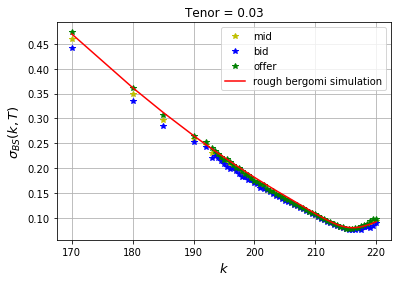

0.0017102366179043578

In [72]:
tenor = tenor_list_sample[0]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[0],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[ 0.18531902 -0.761033    3.08555865]
0.0016270063760200338 1.410315021358224e-05


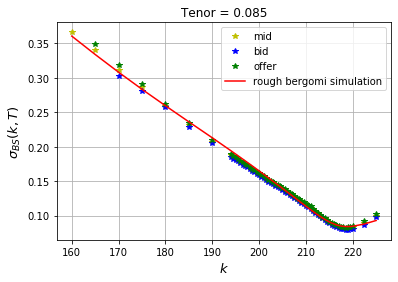

0.0016270063760200338

In [73]:
tenor = tenor_list_sample[1]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[1],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[ 0.15545168 -0.84000553  2.3363784 ]
0.001325656895274944 7.565689527494368e-05


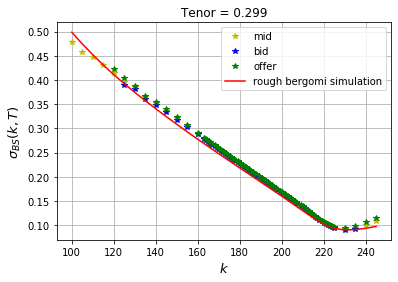

0.001325656895274944

In [75]:
tenor = tenor_list_sample[2]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[2],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[ 0.12868358 -0.88505979  1.92031159]
0.0015434147722867345 0.0001349640680613823


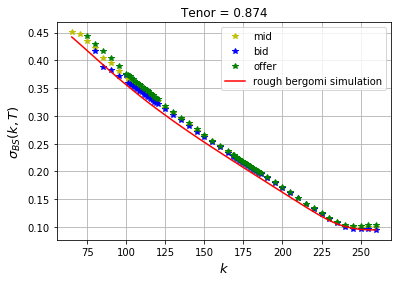

0.0015434147722867345

In [71]:
tenor = tenor_list_sample[3]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[3],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

### 2013-08-14

In [ ]:
#params = [ 0.13965069 , -0.8270291, 3.03526396] # tenor = 0.025
#params = [ 0.08782856, -0.84040342,  2.07209507] # tenor = 0.063
#params = [ 0.096831  , -0.72890588,  1.96787099] # tenor = 0.1
#params = [ 0.07212302, -0.77161391,  2.07466641] # tenor = 0.427

In [152]:
tenor_list_sample

[0.10136986301369864,
 0.2547945205479452,
 0.4273972602739726,
 0.8493150684931506]

In [153]:
best_params_list

[array([ 0.17938028, -0.7246856 ,  2.20011239]),
 array([ 0.08883985, -0.77593148,  2.11028948]),
 array([ 0.14550376, -0.70979479,  1.86616789]),
 array([ 0.10282982, -0.77296747,  1.69869223])]

[0.13965069, -0.8270291, 3.03526396]
0.003508190109593585 5.991424752461955e-05


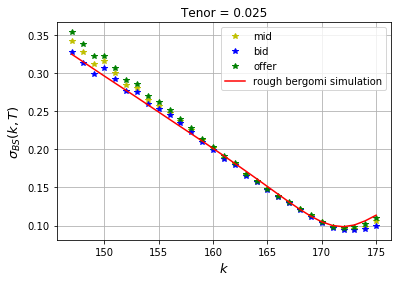

0.003508190109593585

In [107]:
tenor = 0.024657534246575345
params = [ 0.13965069 , -0.8270291, 3.03526396]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(params,real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[0.08782856, -0.84040342, 2.07209507]
0.0026530591918995055 2.1480244531084452e-05


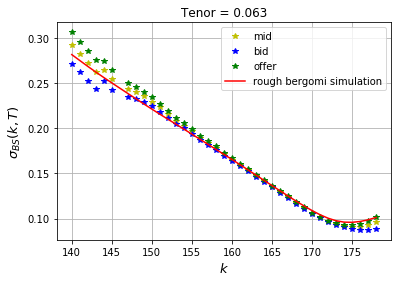

0.0026530591918995055

In [112]:
tenor = 0.06301369863013699
params = [ 0.08782856, -0.84040342,  2.07209507]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(params,real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[0.096831, -0.850588, 1.96787099]
0.0018738484979092039 8.813421219491819e-05


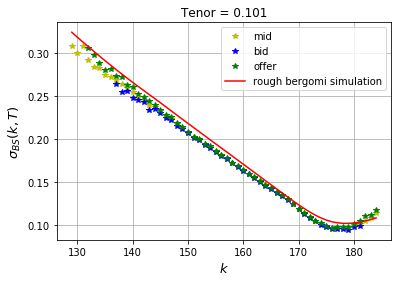

0.0018738484979092039

In [130]:
tenor = 0.10136986301369864
params = [ 0.096831  , -0.850588,  1.96787099]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(params,real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[ 0.14550376 -0.70979479  1.86616789]
0.001020904367760838 1.0803357659827752e-05


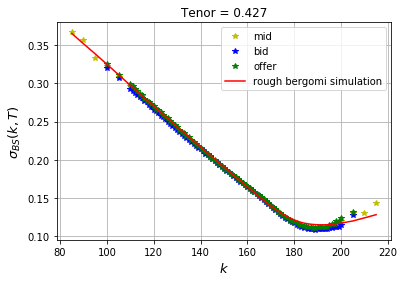

0.001020904367760838

In [170]:
tenor = tenor_list_sample[2]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[2],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

[ 0.10282982 -0.77296747  1.69869223]
0.0014847371471457943 1.4148911851676652e-05


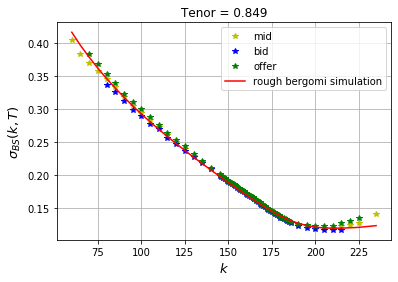

0.0014847371471457943

In [172]:
tenor = tenor_list_sample[3]
strike_list = np.array([df_iv_groupBy.loc[tenor].index])
real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
sigma0 = find_sigma0(df_iv_groupBy,tenor)
func_to_minimize_fixedTenor(best_params_list[3],real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, N=100000, 
                            c=0.1, plot=True)

### Basin hoppin algo :

[ 0.1 -0.7  2. ]
0.0016692468608753637


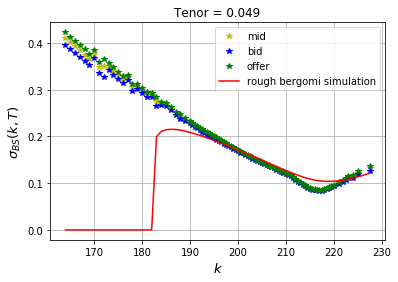

[ 0.10000001 -0.7         2.        ]
0.0016726933477466868


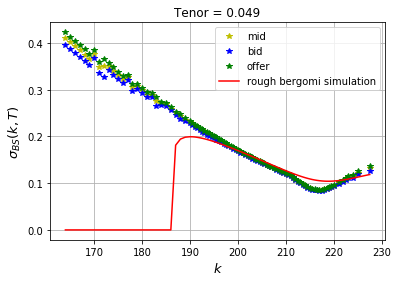

[ 0.1        -0.69999999  2.        ]
0.0017339549909941789


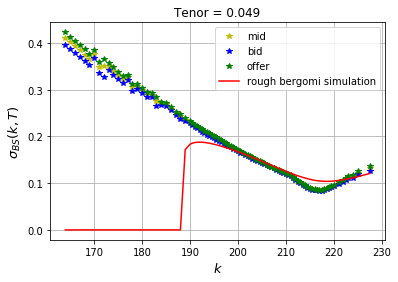

[ 0.1        -0.7         2.00000001]
0.0016221107406854903


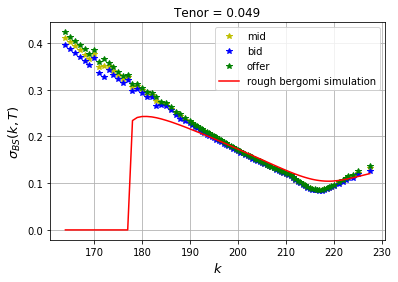

[ 0.1 -0.7  2. ]
0.0013603155462494443


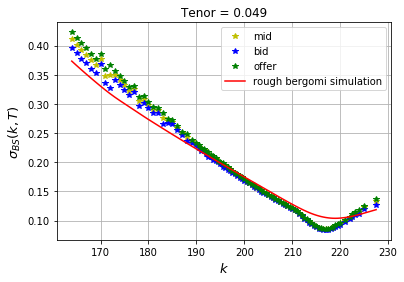

[ 0.05655875 -1.51561367  2.59412726]
100


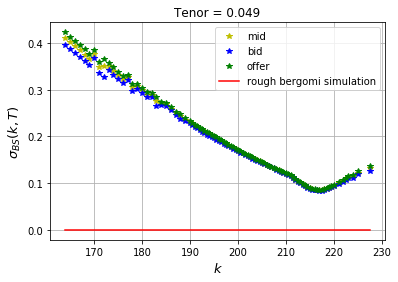

[ 0.05655875 -1.51561367  2.59412726]
100


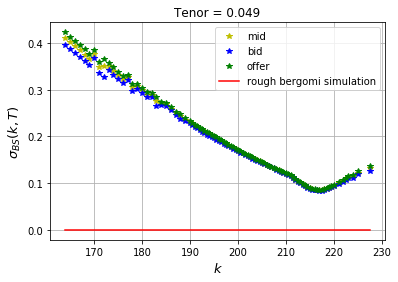

[ 0.05655877 -1.51561367  2.59412726]
100


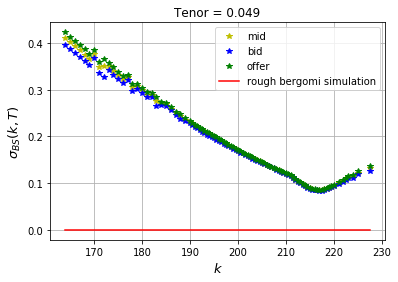

[ 0.05655875 -1.51561365  2.59412726]
100


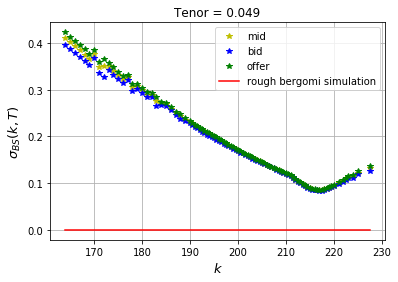

[ 0.05655875 -1.51561367  2.59412727]
100


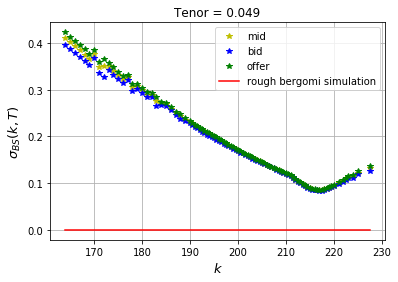

[ 0.08603387 -0.96221549  2.19100878]
0.0015014469039352396


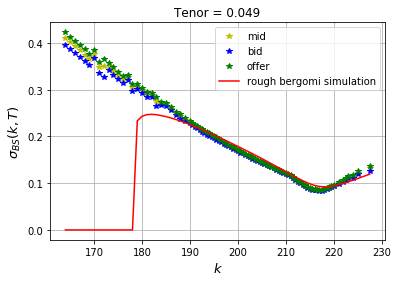

[ 0.08603387 -0.96221549  2.19100878]
0.0016033502804150392


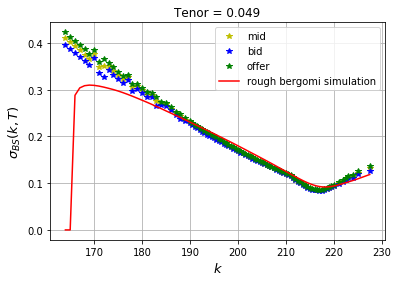

[ 0.08603388 -0.96221549  2.19100878]
0.001505692316629595


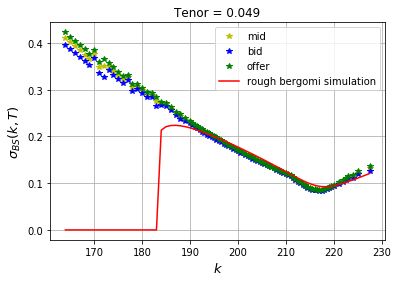

[ 0.08603387 -0.96221547  2.19100878]
0.0014883554040061161


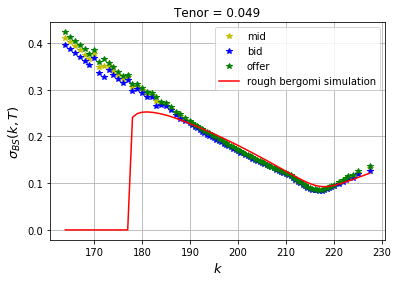

[ 0.08603387 -0.96221549  2.19100879]
0.0015011340057726895


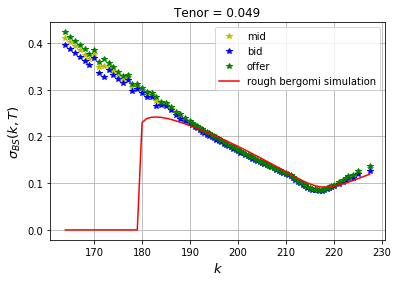

[ 0.09419522 -0.80898539  2.07938954]
0.0014621024874070195


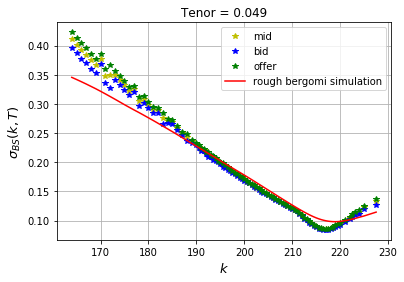

[ 0.09419522 -0.80898539  2.07938954]
0.0017031261166963651


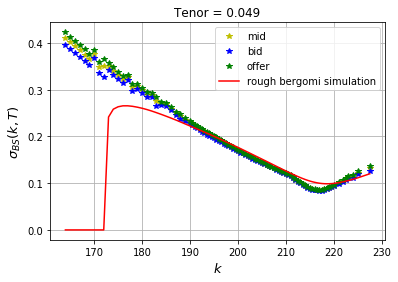

[ 0.09419523 -0.80898539  2.07938954]
0.00115075271485719


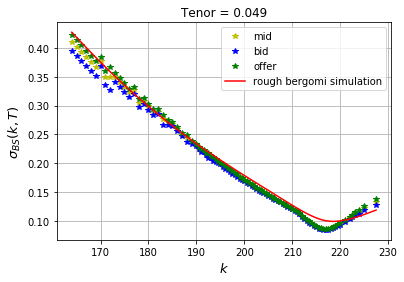

[ 0.09419522 -0.80898538  2.07938954]
0.0016719000785514666


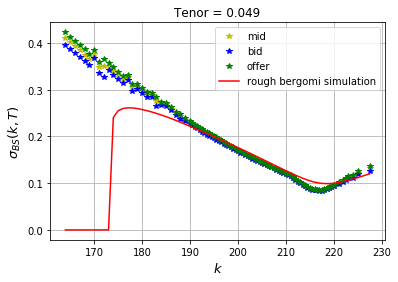

[ 0.09419522 -0.80898539  2.07938955]
0.0011975493159017124


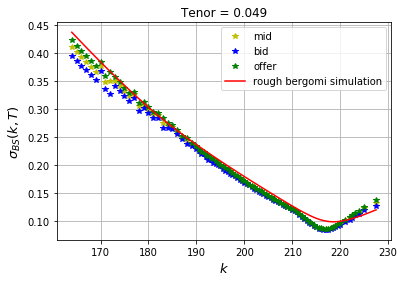

[ 0.09934061 -0.71238003  2.00901813]
0.0011466357330972238


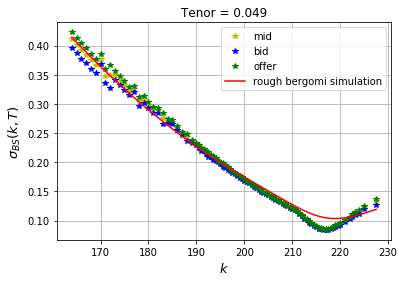

[ 0.09934061 -0.71238003  2.00901813]
0.0012133016828677929


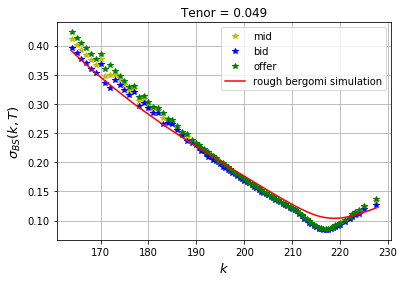

[ 0.09934063 -0.71238003  2.00901813]
0.0011918186092664258


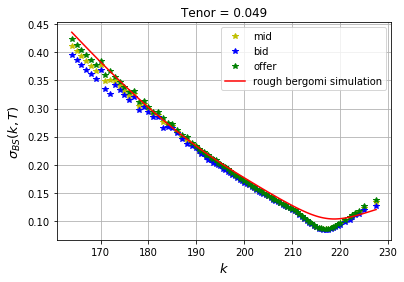

[ 0.09934061 -0.71238002  2.00901813]
0.0017337748440651509


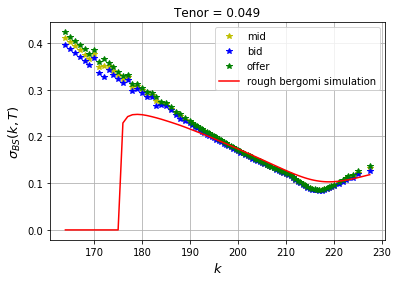

[ 0.09934061 -0.71238003  2.00901815]
0.0016905537986307705


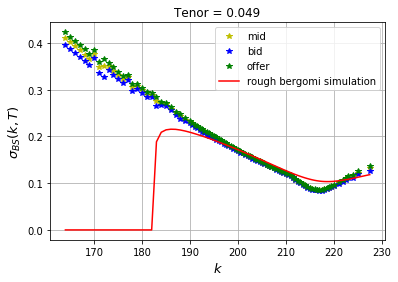

[ 0.09989232 -0.70202179  2.00147275]
0.001681778940268783


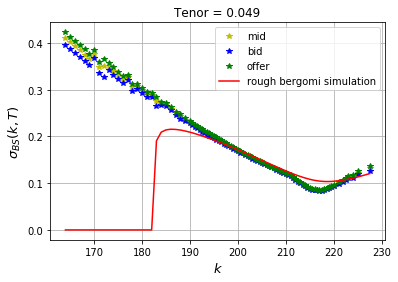

[ 0.09989232 -0.70202179  2.00147275]
0.0011480957064140098


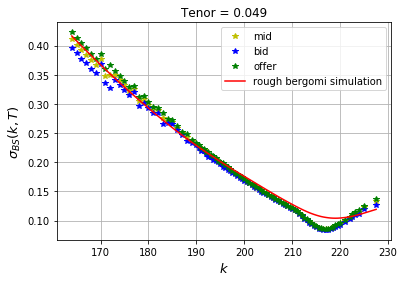

[ 0.09989233 -0.70202179  2.00147275]
0.0011687360236370017


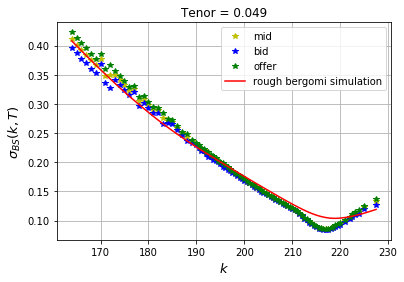

[ 0.09989232 -0.70202177  2.00147275]
0.0011604813144348723


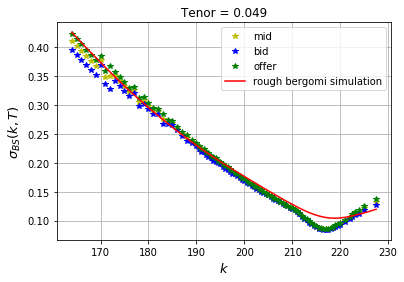

[ 0.09989232 -0.70202179  2.00147277]
0.0013188206932791833


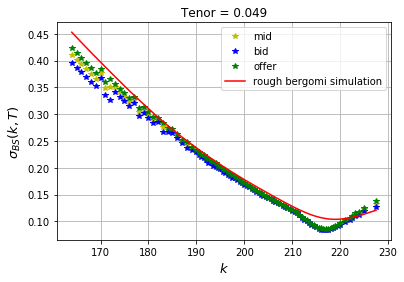

[ 0.09994541 -0.70102485  2.00074654]
0.001159686038065167


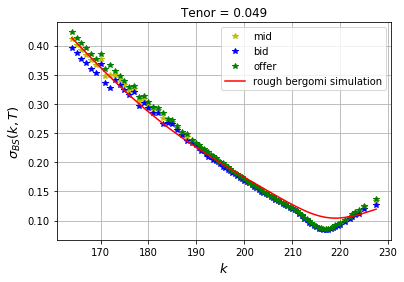

[ 0.09994541 -0.70102485  2.00074654]
0.0016897459945733684


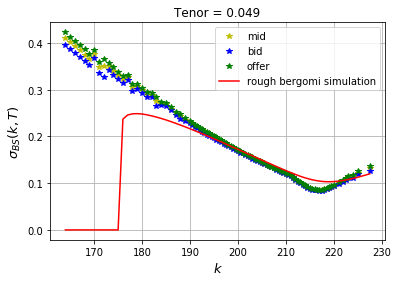

[ 0.09994543 -0.70102485  2.00074654]
0.0013184584406316419


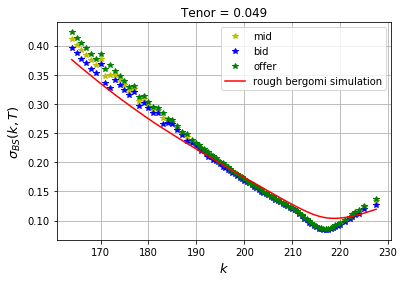

[ 0.09994541 -0.70102483  2.00074654]
0.0011623092741302934


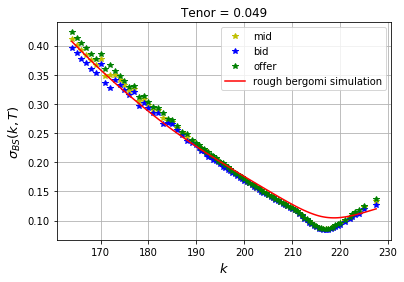

[ 0.09994541 -0.70102485  2.00074656]
0.0014183059698799337


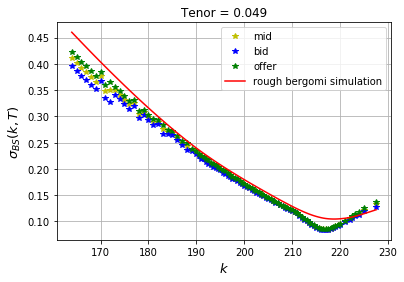

[ 0.09996952 -0.70057218  2.0004168 ]
0.0016373324410104272


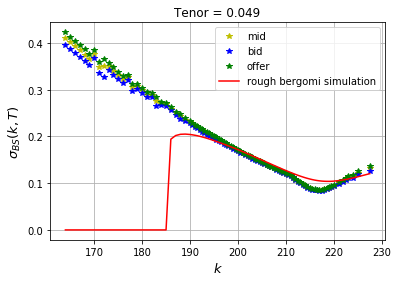

[ 0.09996952 -0.70057218  2.0004168 ]
0.001696030169386011


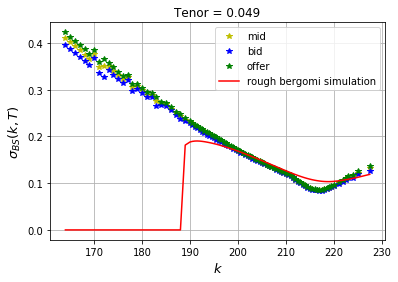

[ 0.09996954 -0.70057218  2.0004168 ]
0.001669343007174465


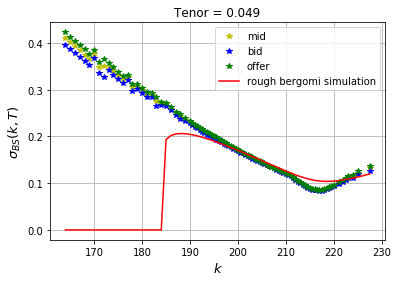

[ 0.09996952 -0.70057216  2.0004168 ]
0.0016822632361686222


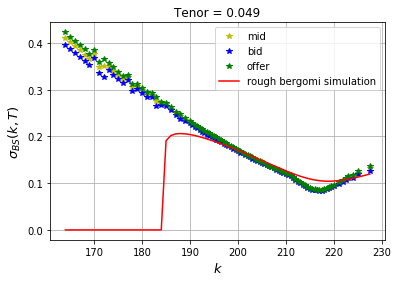

[ 0.09996952 -0.70057218  2.00041681]
0.0011672587843961219


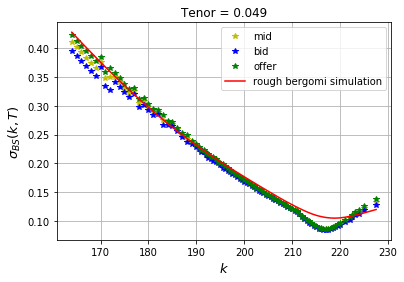

[ 0.09999697 -0.70005696  2.00004149]
0.0013928850432527171


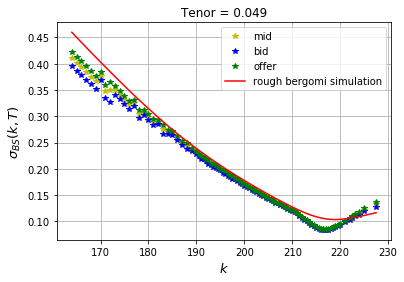

[ 0.09999697 -0.70005696  2.00004149]
0.0011548652206638255


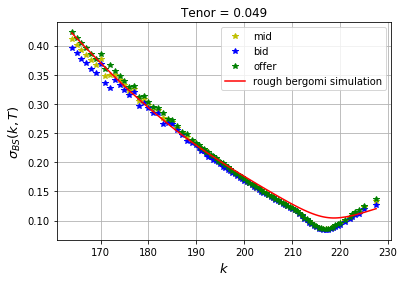

[ 0.09999698 -0.70005696  2.00004149]
0.0016218273863425102


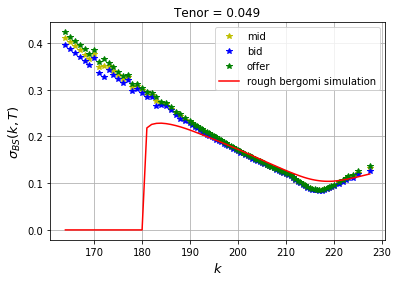

[ 0.09999697 -0.70005694  2.00004149]
0.001629241281139549


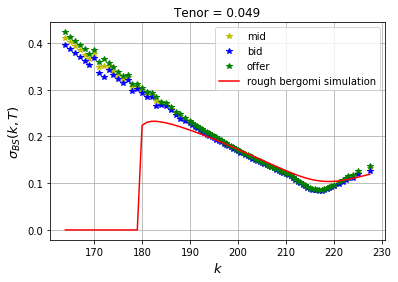

[ 0.09999697 -0.70005696  2.00004151]
0.001661722459224218


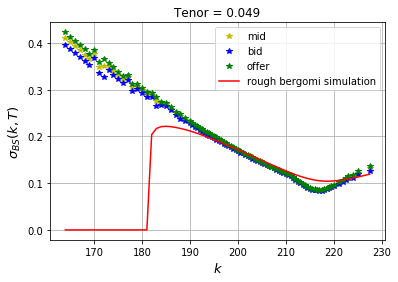

[ 0.09999943 -0.70001071  2.0000078 ]
0.0012524641131658222


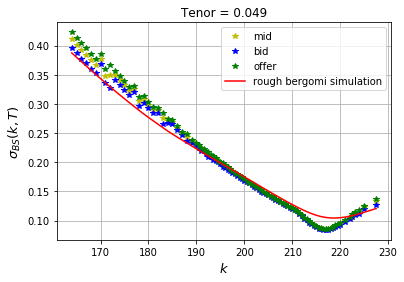

[ 0.09999943 -0.70001071  2.0000078 ]
0.0018490770289565318


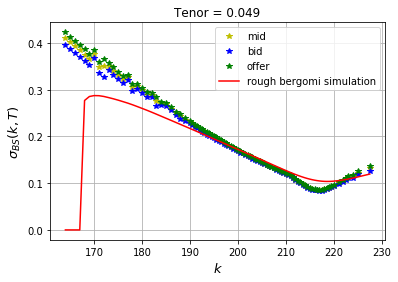

[ 0.09999944 -0.70001071  2.0000078 ]
0.0011635321552387742


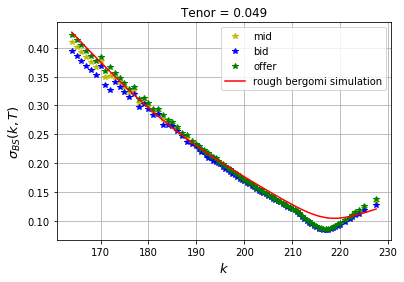

[ 0.09999943 -0.7000107   2.0000078 ]
0.001694464452110512


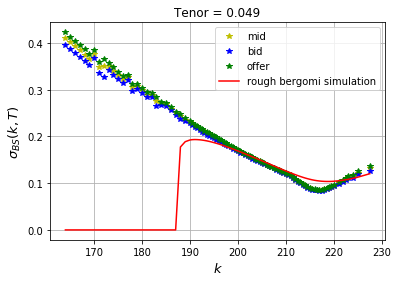

[ 0.09999943 -0.70001071  2.00000782]
0.001371749708359532


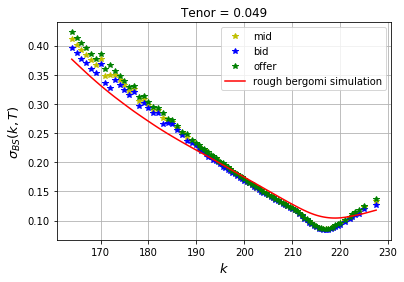

[ 0.09999887 -0.70002117  2.00001542]
0.00137363297886002


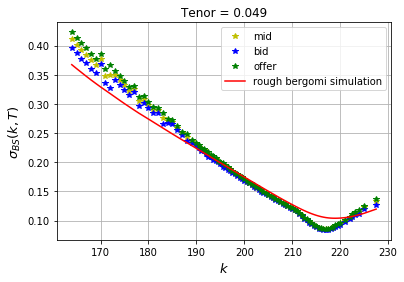

[ 0.09999887 -0.70002117  2.00001542]
0.0012767269751987145


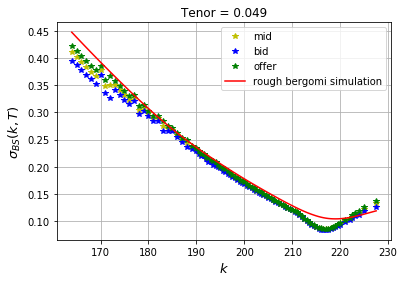

[ 0.09999889 -0.70002117  2.00001542]
0.0011558532543329268


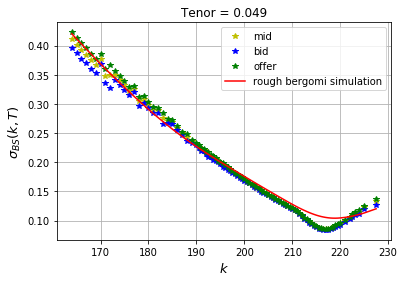

[ 0.09999887 -0.70002116  2.00001542]
0.0011625445297118121


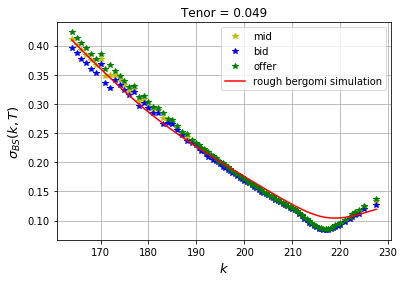

[ 0.09999887 -0.70002117  2.00001544]
0.0018146913351553022


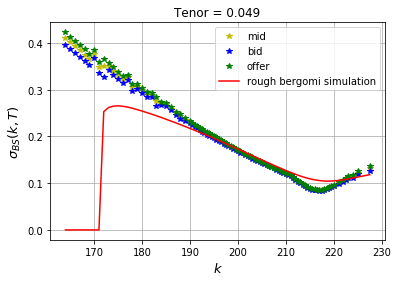

[ 0.09999912 -0.70001653  2.00001204]
0.001724935800115329


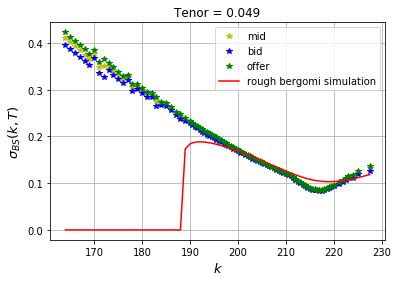

[ 0.09999912 -0.70001653  2.00001204]
0.0016980839256780077


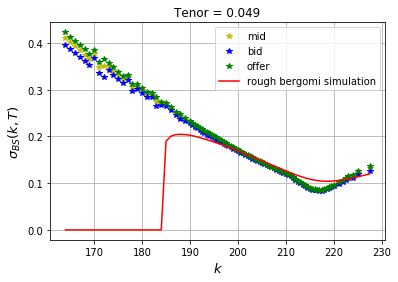

[ 0.09999913 -0.70001653  2.00001204]
0.0011680113737199804


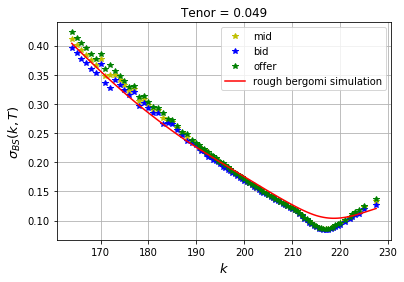

[ 0.09999912 -0.70001651  2.00001204]
0.002116360841799837


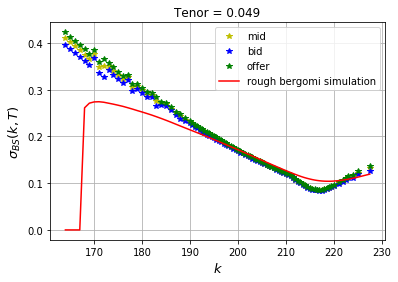

[ 0.09999912 -0.70001653  2.00001205]
0.0011514240114244522


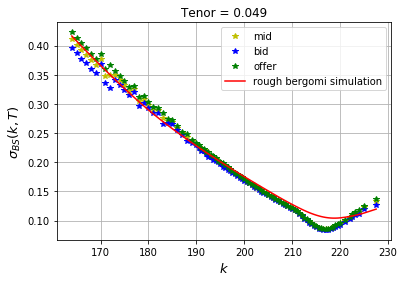

[ 0.09999941 -0.70001117  2.00000814]
0.0015149775912050576


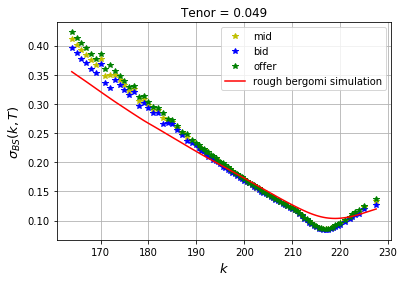

[ 0.09999941 -0.70001117  2.00000814]
0.0018939559136093396


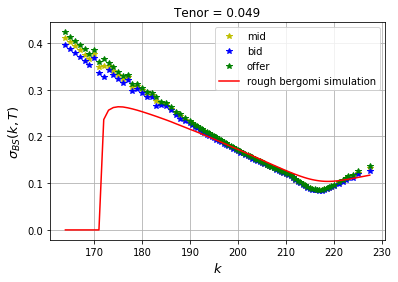

[ 0.09999942 -0.70001117  2.00000814]
0.0016463536879795506


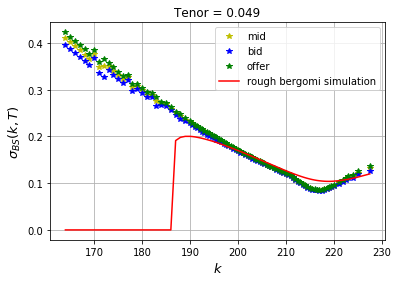

[ 0.09999941 -0.70001115  2.00000814]
0.0017002261541838799


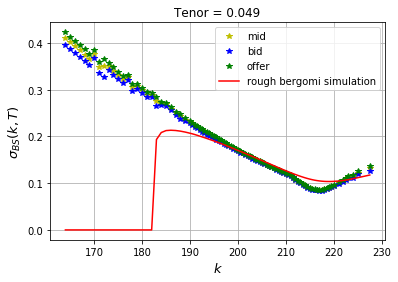

[ 0.09999941 -0.70001117  2.00000815]
0.0015008979862992365


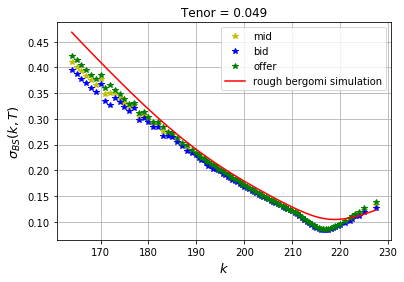

[ 0.09999942 -0.70001082  2.00000788]
0.001192824112109602


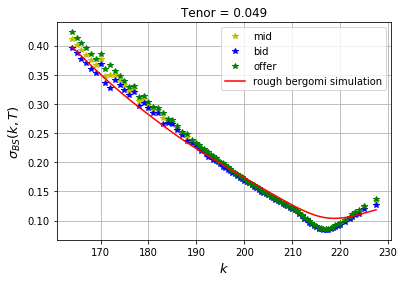

[ 0.09999942 -0.70001082  2.00000788]
0.001633911320706903


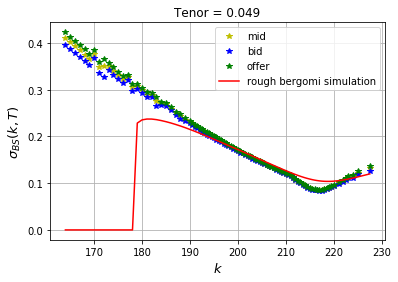

[ 0.09999944 -0.70001082  2.00000788]
0.001764787598869386


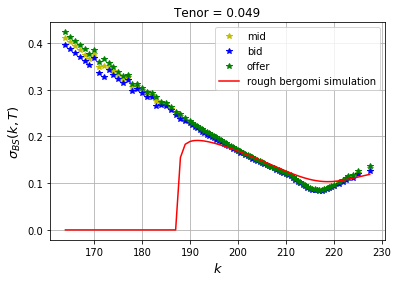

[ 0.09999942 -0.70001081  2.00000788]
0.0019716277755199236


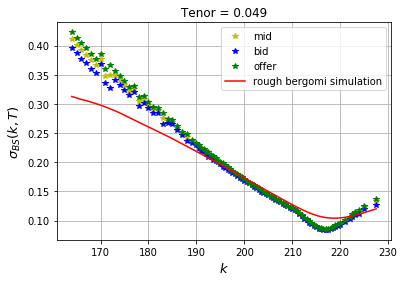

[ 0.09999942 -0.70001082  2.0000079 ]
0.0016090141830808063


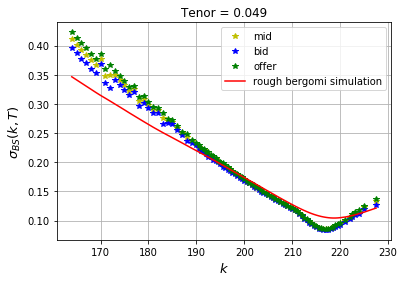

[ 0.09999942 -0.70001092  2.00000795]
0.0011506761220099826


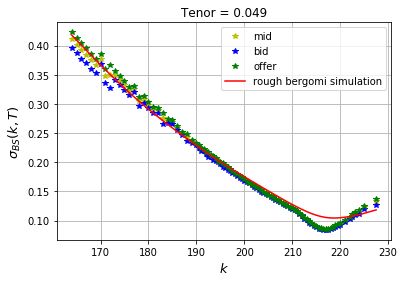

[ 0.09999942 -0.70001092  2.00000795]
0.001155337127937469


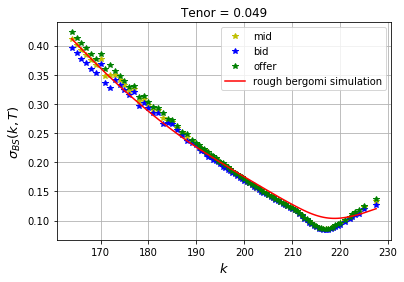

[ 0.09999943 -0.70001092  2.00000795]
0.001695622848153095


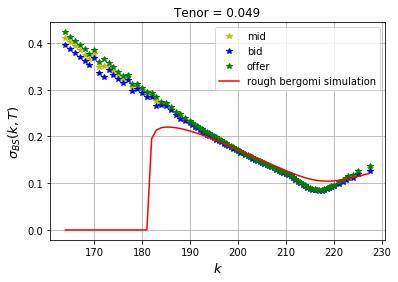

[ 0.09999942 -0.7000109   2.00000795]
0.0012698906282123164


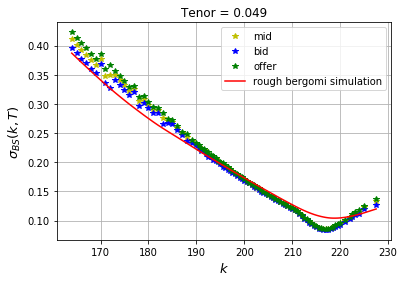

[ 0.09999942 -0.70001092  2.00000797]
0.0016514525716635395


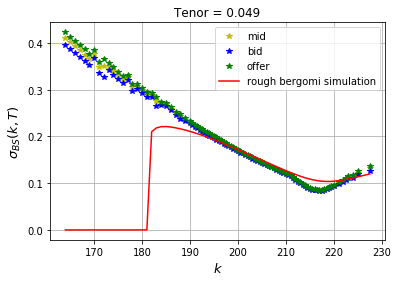

[ 0.09999942 -0.70001086  2.00000791]
0.0017484581582844758


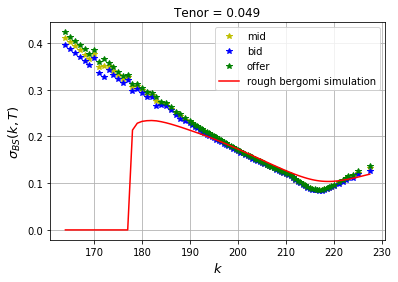

[ 0.09999942 -0.70001086  2.00000791]
0.0017053463122050669


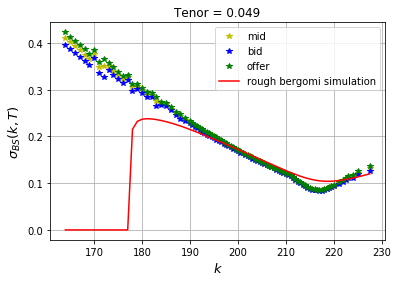

[ 0.09999944 -0.70001086  2.00000791]
0.001491421316495426


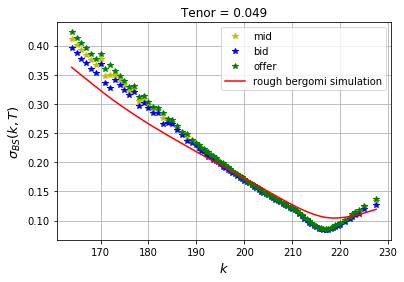

[ 0.09999942 -0.70001085  2.00000791]
0.0017479618018860594


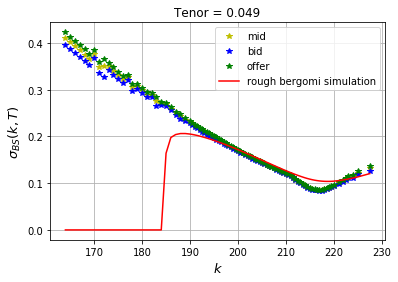

[ 0.09999942 -0.70001086  2.00000793]
0.0012555570569549909


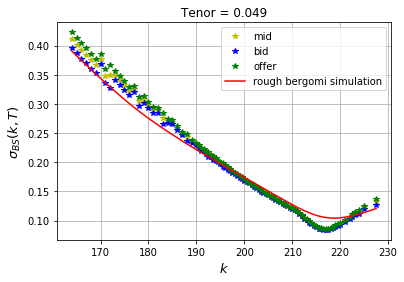

[ 0.09999942 -0.70001091  2.00000794]
0.0012031217177486356


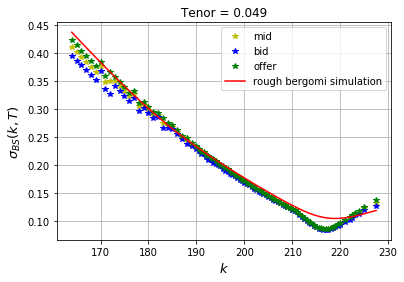

[ 0.09999942 -0.70001091  2.00000794]
0.0016430859955567586


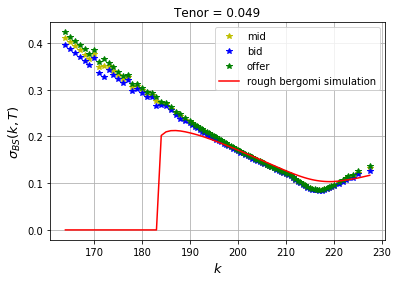

[ 0.09999943 -0.70001091  2.00000794]
0.0013216760532189695


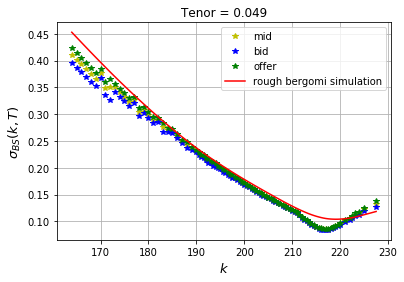

[ 0.09999942 -0.70001089  2.00000794]
0.0017405947984806627


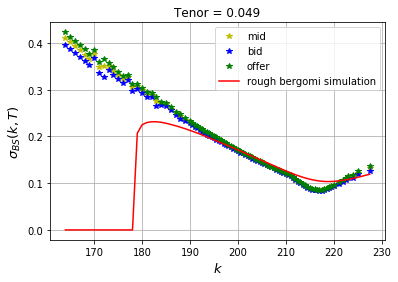

[ 0.09999942 -0.70001091  2.00000796]
0.0011568716971810695


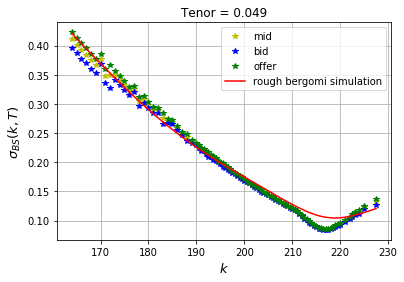

[ 0.09999942 -0.70001091  2.00000795]
0.0016819861045263033


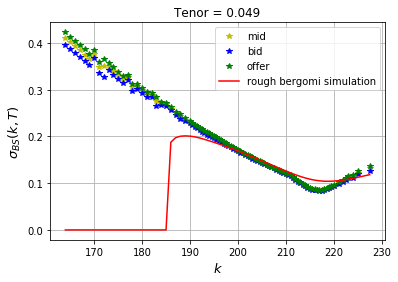

[ 0.09999942 -0.70001091  2.00000795]
0.0017239018735076132


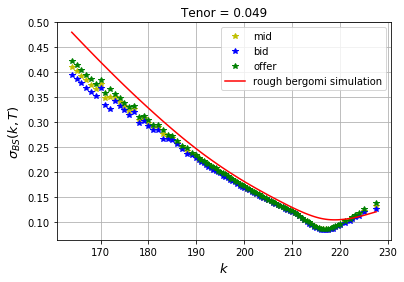

[ 0.09999943 -0.70001091  2.00000795]
0.0019053812293566641


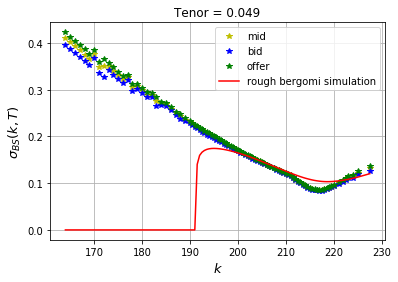

[ 0.09999942 -0.7000109   2.00000795]
0.0014755612982738995


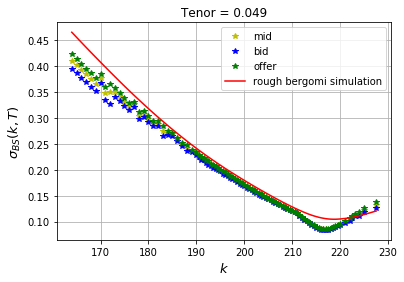

[ 0.09999942 -0.70001091  2.00000796]
0.001673764394178653


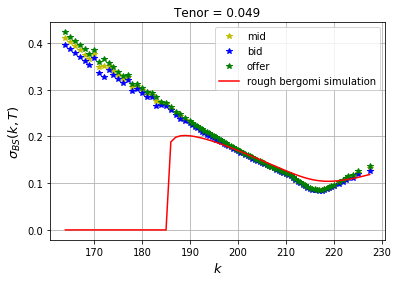

[ 0.09999942 -0.70001092  2.00000795]
0.0016746667151132351


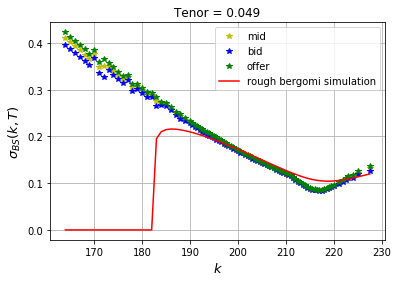

[ 0.09999942 -0.70001092  2.00000795]
0.001731744516212298


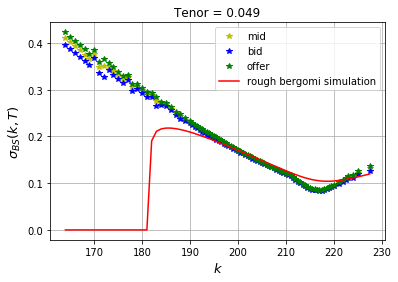

[ 0.09999943 -0.70001092  2.00000795]
0.0017199509803515552


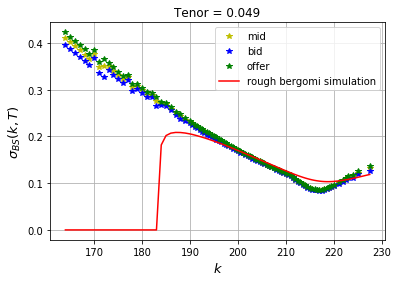

[ 0.09999942 -0.7000109   2.00000795]
0.0017265049156347842


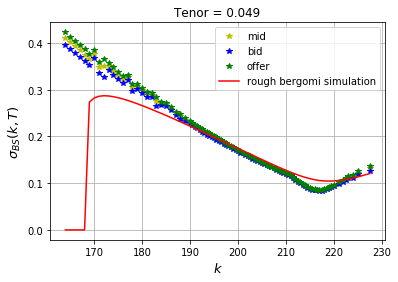

[ 0.09999942 -0.70001092  2.00000797]
0.0017116076826859839


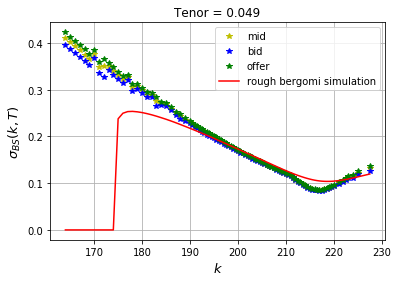

[ 0.09999942 -0.70001092  2.00000795]
0.0016672270203077458


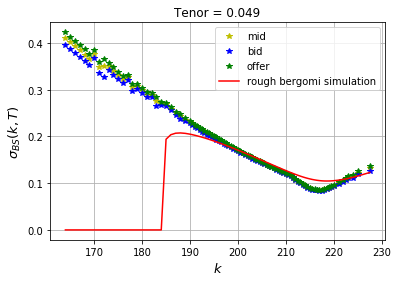

[ 0.09999942 -0.70001092  2.00000795]
0.0017301169959869464


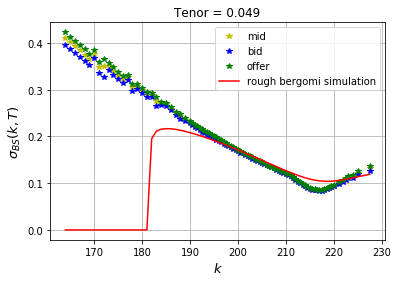

[ 0.09999943 -0.70001092  2.00000795]
0.0017618125824232324


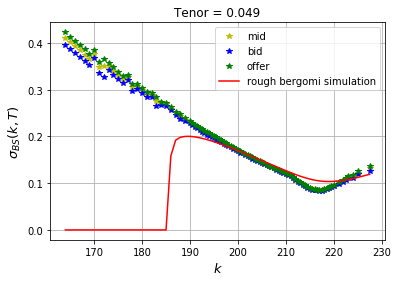

[ 0.09999942 -0.7000109   2.00000795]
0.001892952998386237


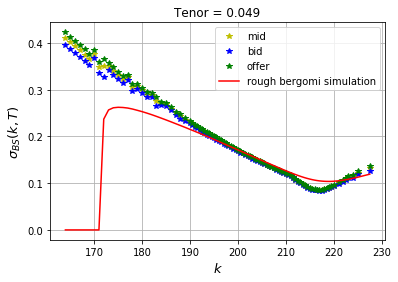

[ 0.09999942 -0.70001092  2.00000797]
0.0017163507095156478


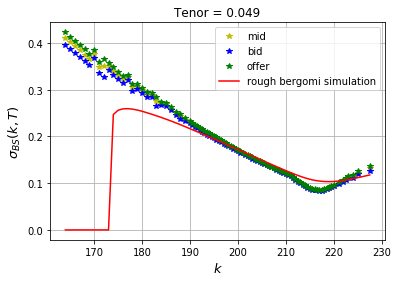

[ 0.09999942 -0.70001092  2.00000795]
0.001345720932433803


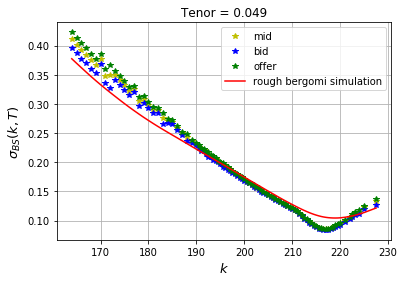

[ 0.09999942 -0.70001092  2.00000795]
0.0016675404091038653


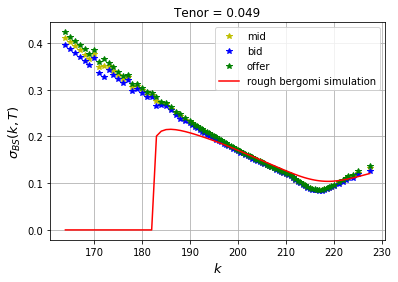

[ 0.09999943 -0.70001092  2.00000795]
0.001702484999910301


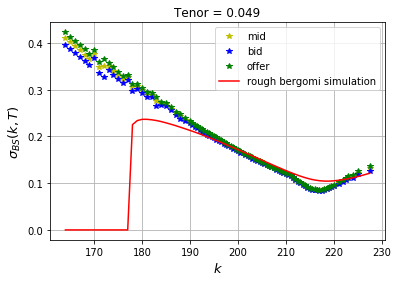

[ 0.09999942 -0.7000109   2.00000795]
0.0014283637565071432


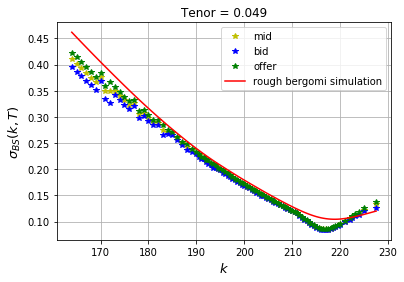

[ 0.09999942 -0.70001092  2.00000797]
0.001361329598352779


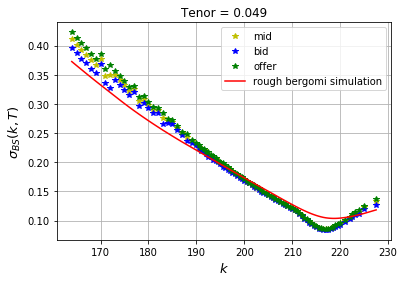

[ 0.09999942 -0.70001092  2.00000796]
0.001383349958696234


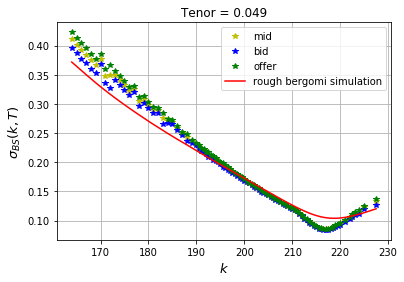

[ 0.09999942 -0.70001092  2.00000796]
0.001880305648621731


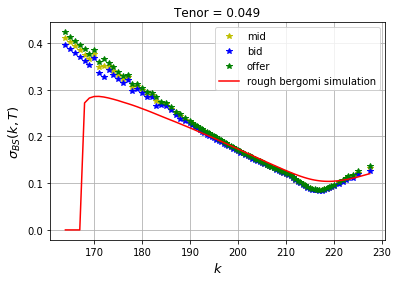

[ 0.09999943 -0.70001092  2.00000796]
0.0016725136667019391


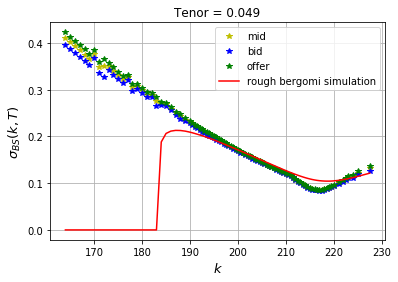

[ 0.09999942 -0.70001091  2.00000796]
0.0016475053241936785


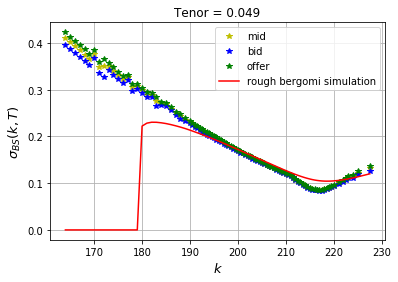

[ 0.09999942 -0.70001092  2.00000797]
0.0017042558313054741


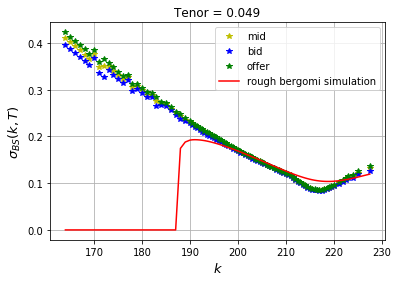

[ 0.09999942 -0.70001092  2.00000795]
0.0011510304802676162


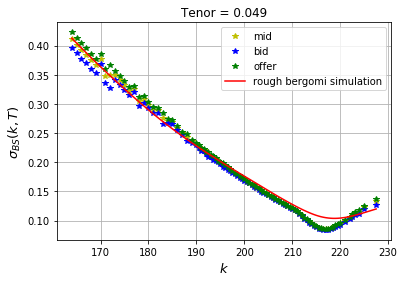

[ 0.09999942 -0.70001092  2.00000795]
0.0011817838102311591


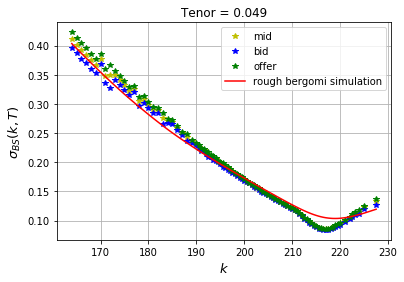

[ 0.09999943 -0.70001092  2.00000795]
0.0012311880004245335


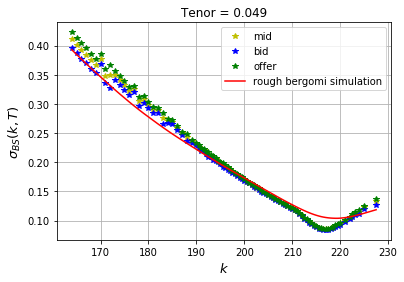

[ 0.09999942 -0.7000109   2.00000795]
0.001157390790745476


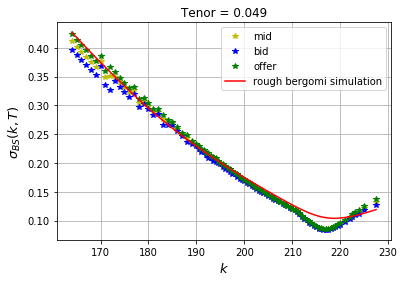

[ 0.09999942 -0.70001092  2.00000797]
0.0017180479332898303


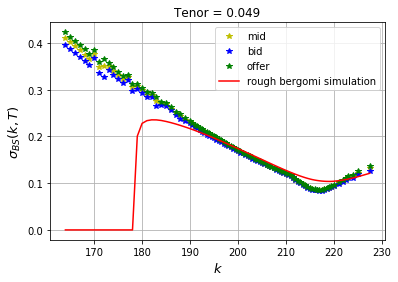

[ 0.09999942 -0.70001092  2.00000795]
0.0016986130510063943


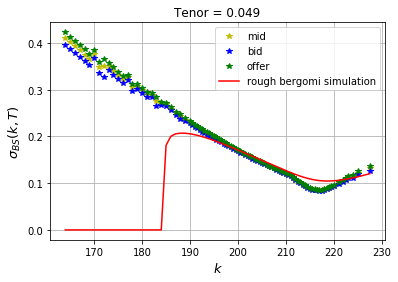

[ 0.09999942 -0.70001092  2.00000795]
0.0011716610759450355


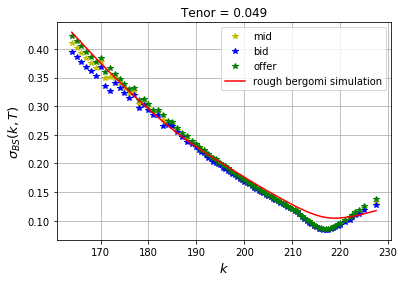

[ 0.09999943 -0.70001092  2.00000795]
0.0012714372205937347


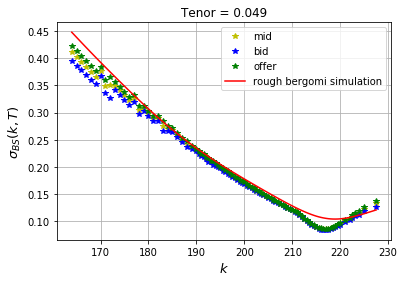

[ 0.09999942 -0.7000109   2.00000795]
0.0011687046710242546


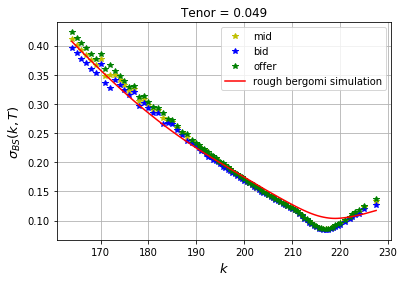

[ 0.09999942 -0.70001092  2.00000797]
0.001159458028843317


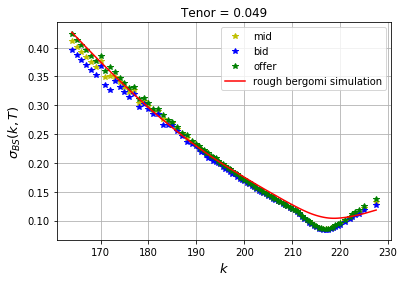

[ 0.09999942 -0.70001092  2.00000795]
0.0012512519233588452


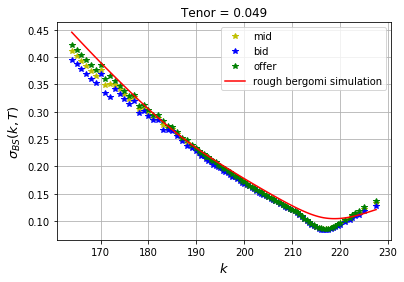

[ 0.09999942 -0.70001092  2.00000795]
0.0017100569771759688


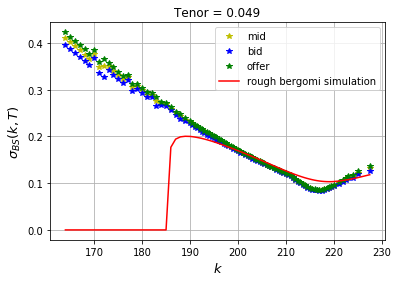

[ 0.09999943 -0.70001092  2.00000795]
0.0012824731851096267


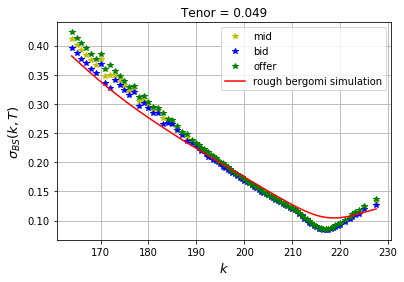

[ 0.09999942 -0.7000109   2.00000795]
0.0012005335640141632


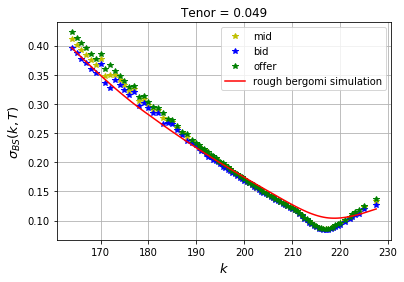

[ 0.09999942 -0.70001092  2.00000797]
0.0012394853954345586


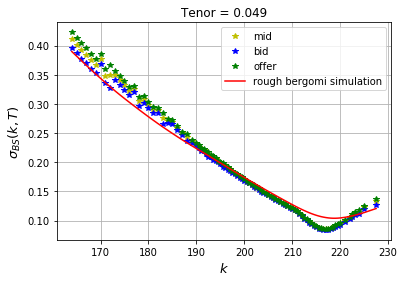

[ 0.09999942 -0.70001094  2.00000798]
0.0016831204276831998


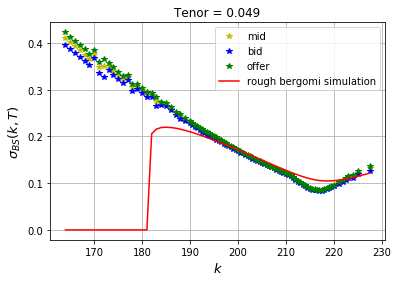

[ 0.09999942 -0.70001094  2.00000798]
0.0011872800464985168


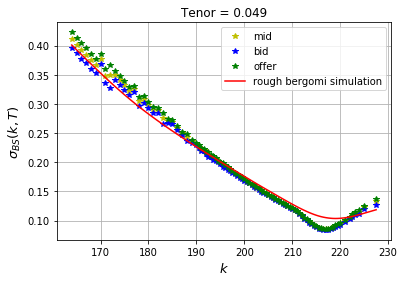

[ 0.09999944 -0.70001094  2.00000798]
0.0016576807051125351


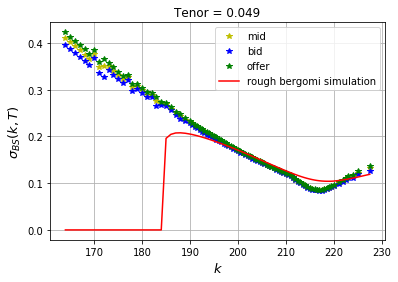

[ 0.09999942 -0.70001093  2.00000798]
0.001453854660903687


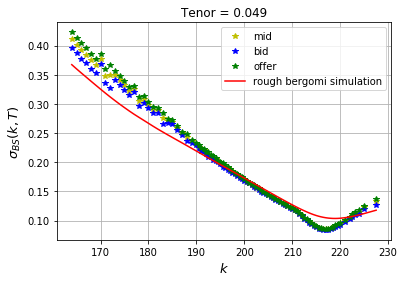

[ 0.09999942 -0.70001094  2.000008  ]
0.001258163056527064


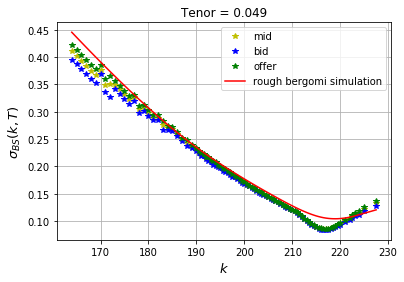

[ 0.09999942 -0.70001092  2.00000795]
0.001212257897832626


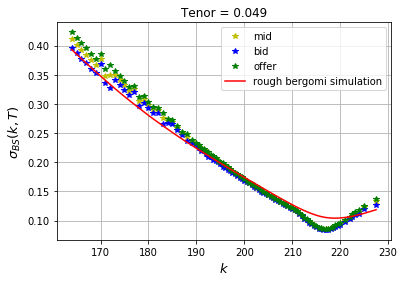

[ 0.09999942 -0.70001092  2.00000795]
0.0017337112819669246


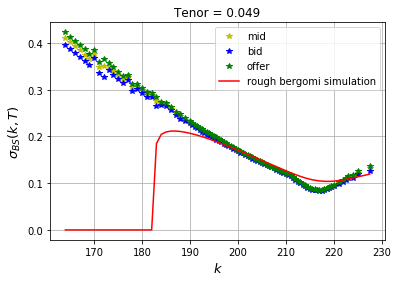

[ 0.09999943 -0.70001092  2.00000795]
0.0011617758103403045


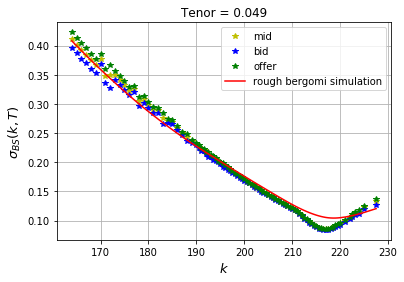

[ 0.09999942 -0.7000109   2.00000795]
0.0011536565091579487


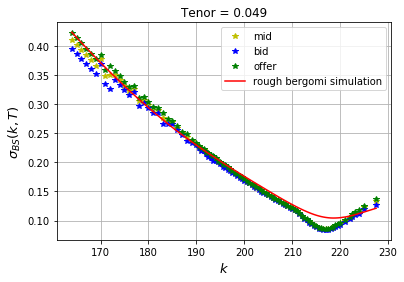

[ 0.09999942 -0.70001092  2.00000797]
0.0016652776567634506


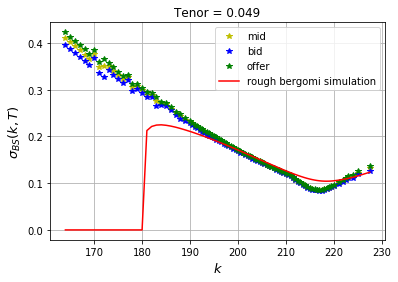

[ 0.09999942 -0.70001092  2.00000795]
0.0017567193584001584


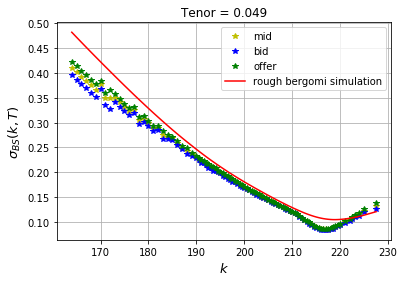

[ 0.09999942 -0.70001092  2.00000795]
0.0016463628628523427


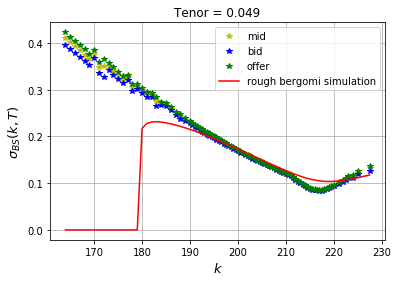

[ 0.09999943 -0.70001092  2.00000795]
0.0017621384779519247


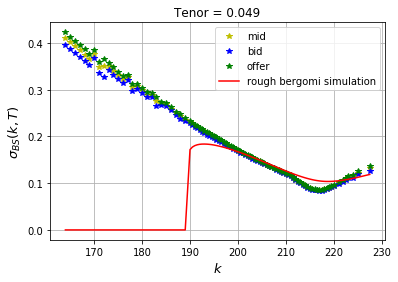

[ 0.09999942 -0.7000109   2.00000795]
0.0011721931432820535


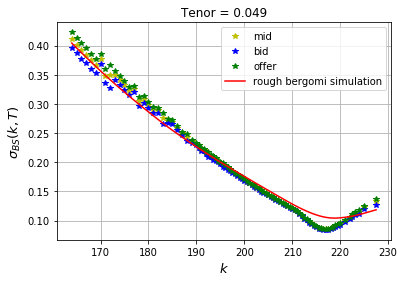

[ 0.09999942 -0.70001092  2.00000797]
0.001165454753068628


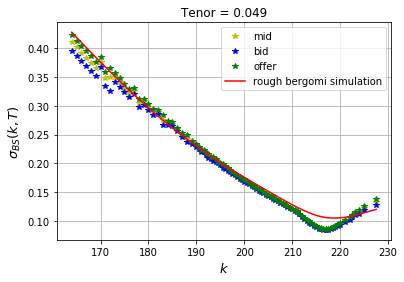

[ 0.09999942 -0.70001092  2.00000795]
0.0012337182906926767


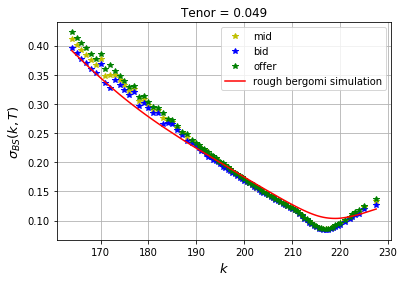

[ 0.09999942 -0.70001092  2.00000795]
0.0011833567365704283


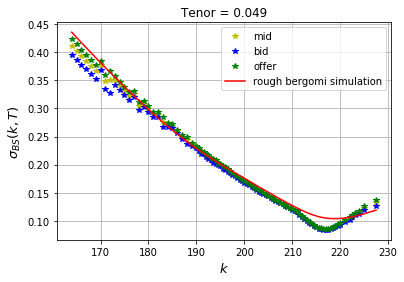

[ 0.09999943 -0.70001092  2.00000795]
0.001154538128016207


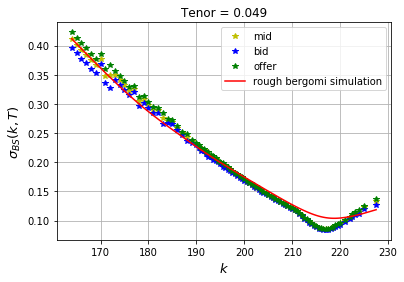

[ 0.09999942 -0.7000109   2.00000795]
0.00117844476280766


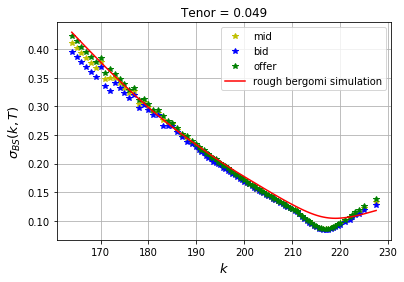

[ 0.09999942 -0.70001092  2.00000797]
0.0012096142667557999


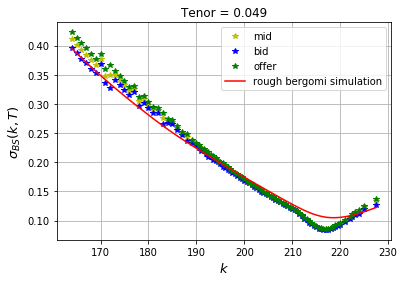

[ 0.09999941 -0.70001089  2.00000793]
0.0011921387587479593


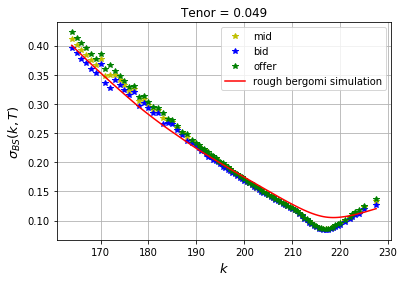

[ 0.09999941 -0.70001089  2.00000793]
0.0018315975761698947


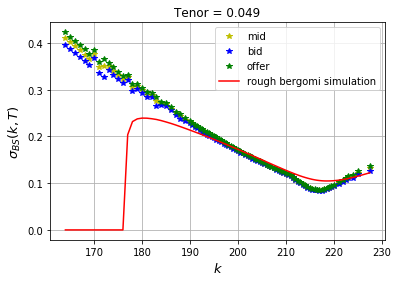

[ 0.09999942 -0.70001089  2.00000793]
0.001178840181249512


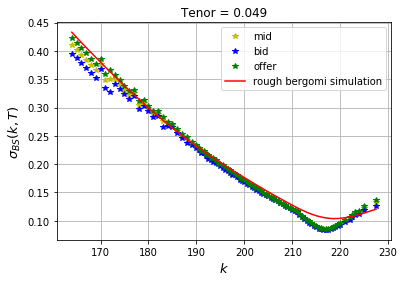

[ 0.09999941 -0.70001087  2.00000793]
0.0016434522335353283


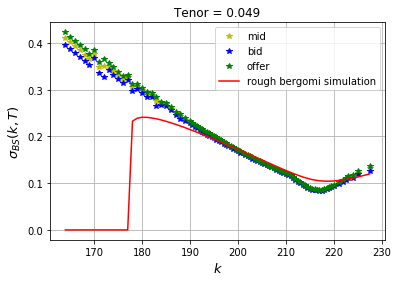

[ 0.09999941 -0.70001089  2.00000794]
0.0011481653337853026


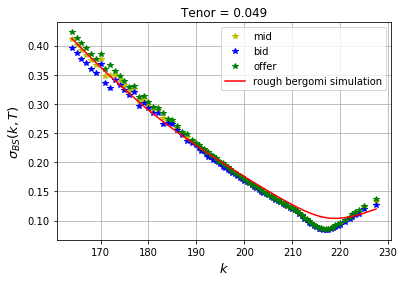

[ 0.09999942 -0.70001092  2.00000795]
0.0011593165769917724


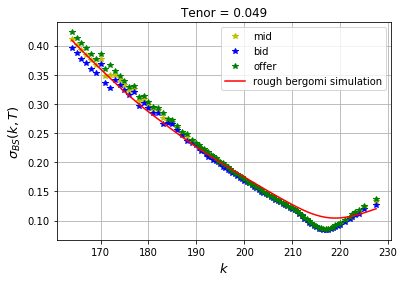

[ 0.09999942 -0.70001092  2.00000795]
0.001157268218639478


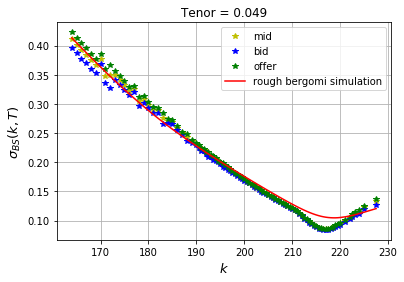

[ 0.09999943 -0.70001092  2.00000795]
0.001668763091690491


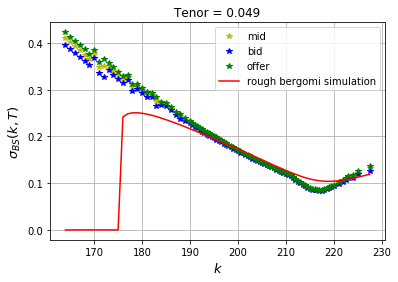

[ 0.09999942 -0.7000109   2.00000795]
0.001618213897441494


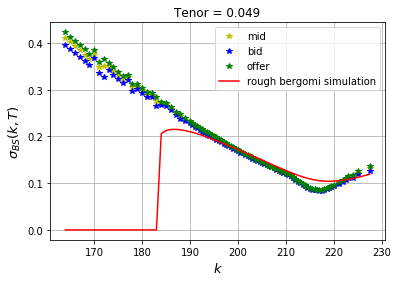

[ 0.09999942 -0.70001092  2.00000797]
0.0017037012843130381


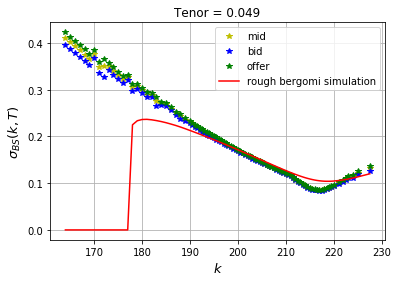

[ 0.09999941 -0.7000109   2.00000794]
0.0017093470130312757


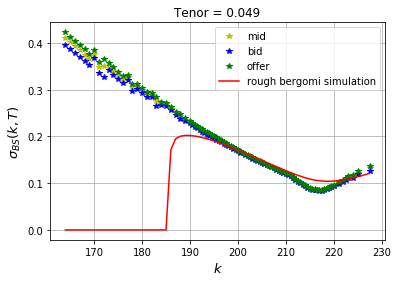

[ 0.09999941 -0.7000109   2.00000794]
0.0011722530636206975


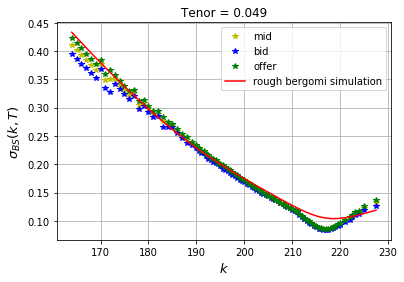

[ 0.09999943 -0.7000109   2.00000794]
0.001157726363485199


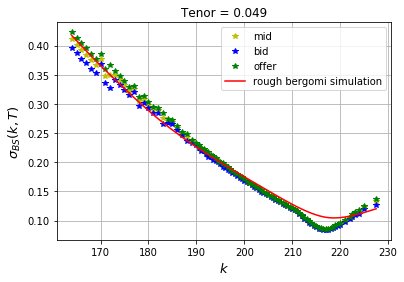

[ 0.09999941 -0.70001088  2.00000794]
0.0012360137814241786


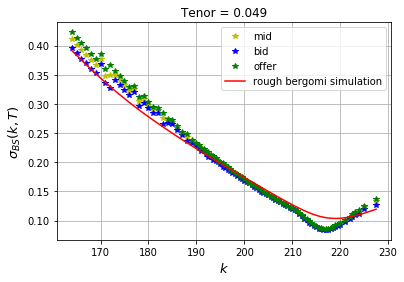

[ 0.09999941 -0.7000109   2.00000795]
0.0018124551820503315


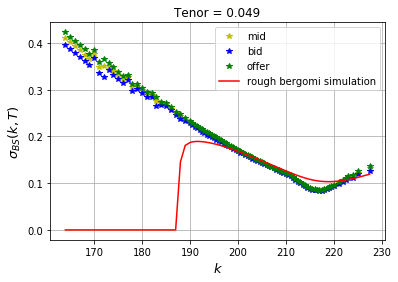

[ 0.09999942 -0.70001092  2.00000795]
0.0011910562293905528


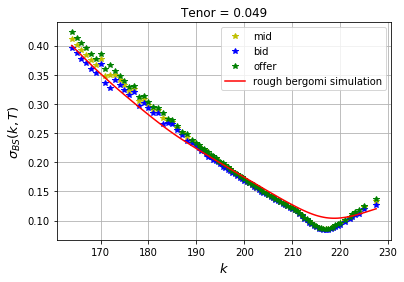

[ 0.09999942 -0.70001092  2.00000795]
0.0016511162510617127


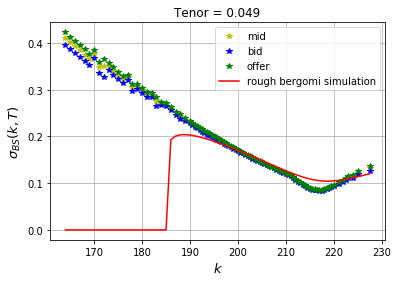

[ 0.09999943 -0.70001092  2.00000795]
0.0017329681701042663


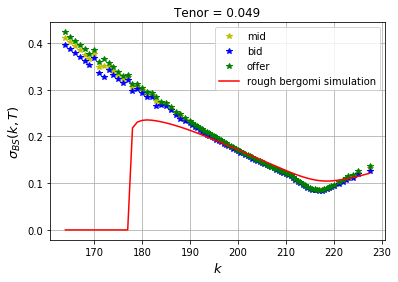

[ 0.09999942 -0.7000109   2.00000795]
0.0011536304734245828


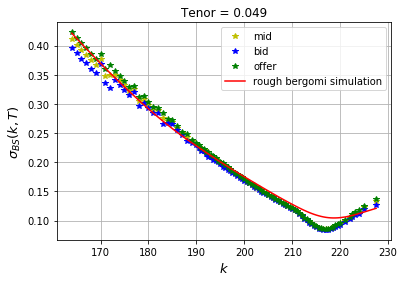

[ 0.09999942 -0.70001092  2.00000797]
0.0017589786120118618


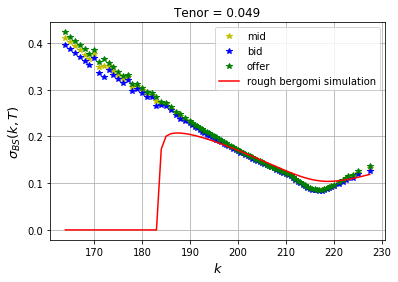

[ 0.09999942 -0.70001092  2.00000795]
0.0013498917680435914


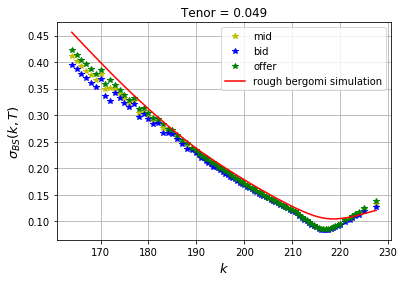

[ 0.09999942 -0.70001092  2.00000795]
0.0017066344598780966


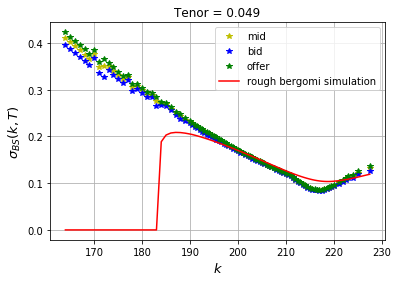

[ 0.09999943 -0.70001092  2.00000795]
0.0016445032107501175


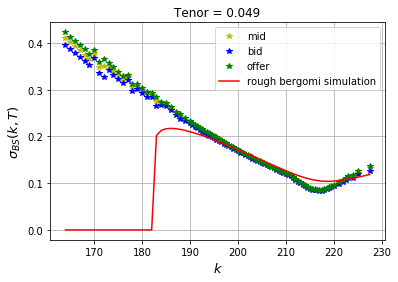

[ 0.09999942 -0.7000109   2.00000795]
0.0012987125488537396


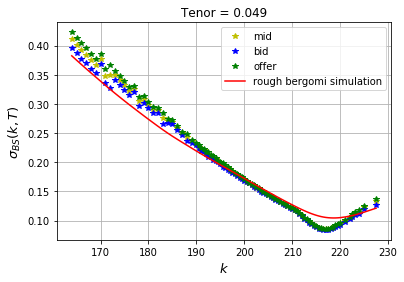

[ 0.09999942 -0.70001092  2.00000797]
0.0011663144492727914


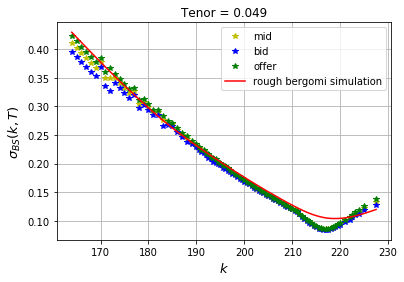

[ 0.09999942 -0.70001092  2.00000795]
0.0011459309328357085


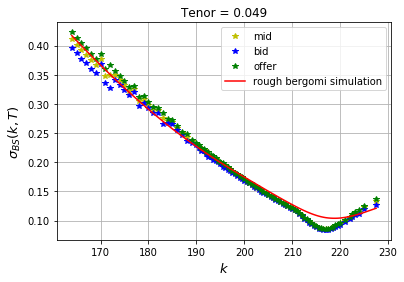

[ 0.09999942 -0.70001092  2.00000795]
0.0017238975624394473


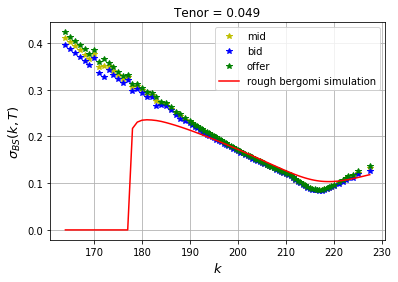

[ 0.09999943 -0.70001092  2.00000795]
0.0012314001801240454


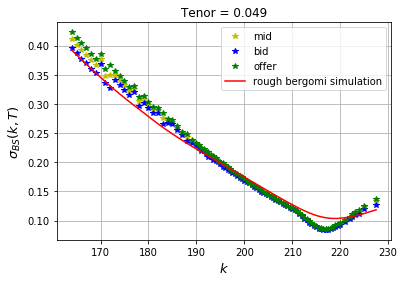

[ 0.09999942 -0.7000109   2.00000795]
0.001930417760656054


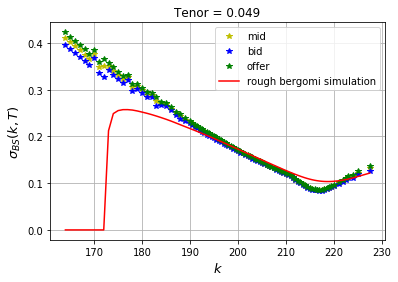

[ 0.09999942 -0.70001092  2.00000797]
0.0013965603031710426


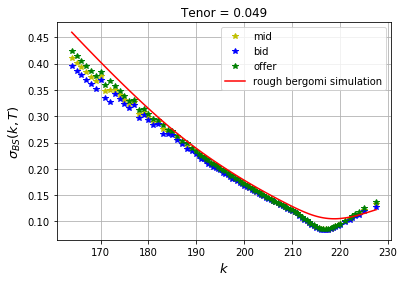

[ 0.09999942 -0.70001092  2.00000795]
0.0012967403080841767


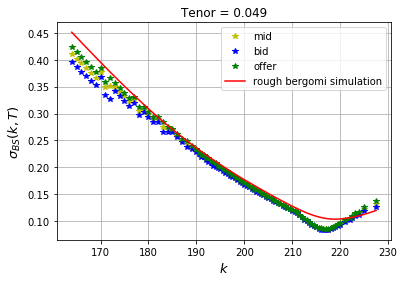

[ 0.09999942 -0.70001092  2.00000795]
0.001363393472930363


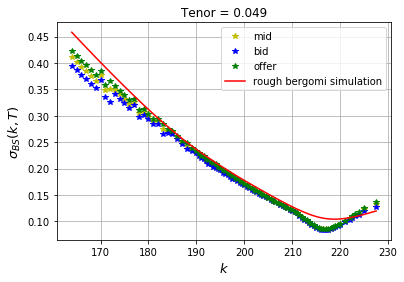

[ 0.09999943 -0.70001092  2.00000795]
0.0011575615670990946


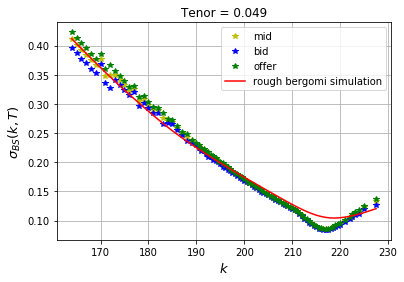

[ 0.09999942 -0.7000109   2.00000795]
0.001730089286236182


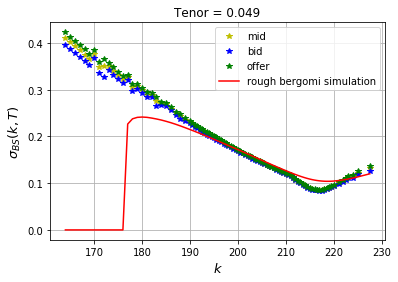

[ 0.09999942 -0.70001092  2.00000797]
0.001740360260896229


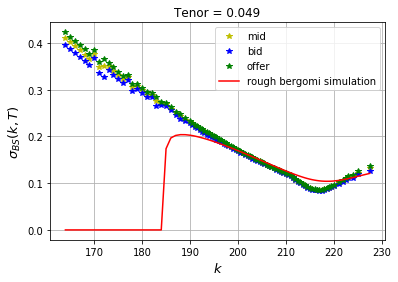

[ 0.09999942 -0.70001092  2.00000795]
0.001183940000561872


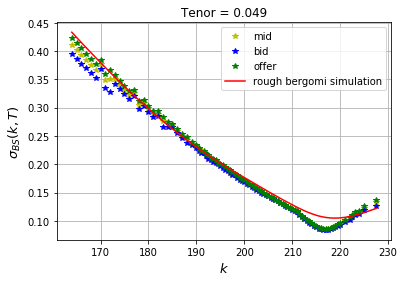

[ 0.09999942 -0.70001092  2.00000795]
0.0017183570075805274


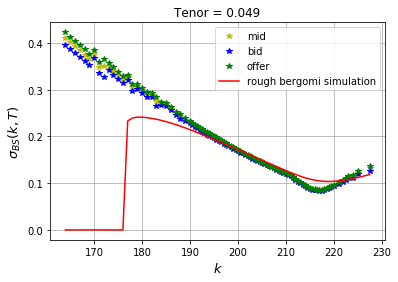

[ 0.09999943 -0.70001092  2.00000795]
0.001667614806152792


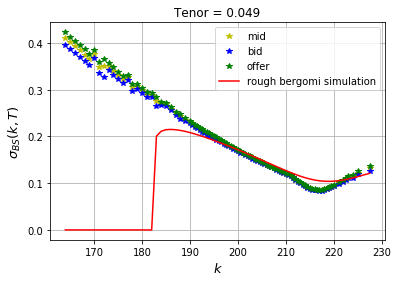

[ 0.09999942 -0.7000109   2.00000795]
0.0014775372381616479


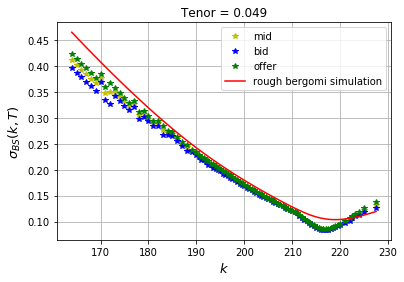

[ 0.09999942 -0.70001092  2.00000797]
0.0018463697121784033


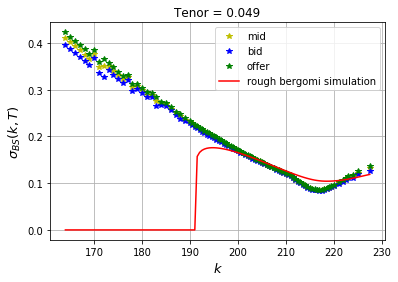

[ 0.09999942 -0.70001092  2.00000795]
0.0012213445007707494


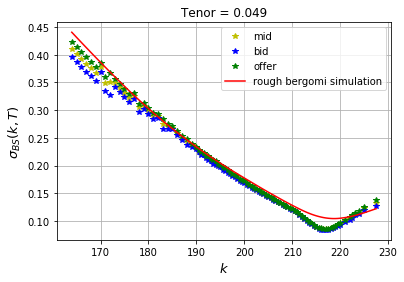

[ 0.09999942 -0.70001092  2.00000795]
0.0017242448419256796


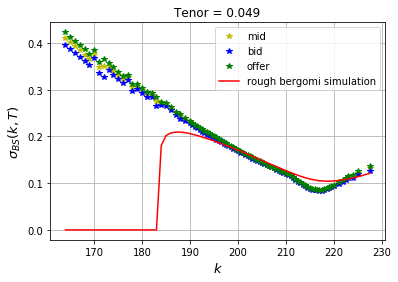

[ 0.09999943 -0.70001092  2.00000795]
0.0016958619893544442


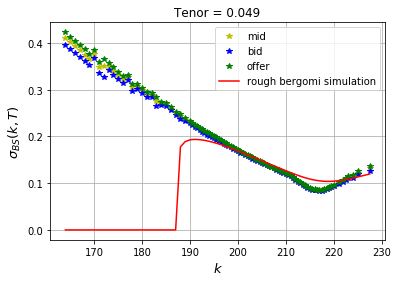

[ 0.09999942 -0.7000109   2.00000795]
0.001740564014106578


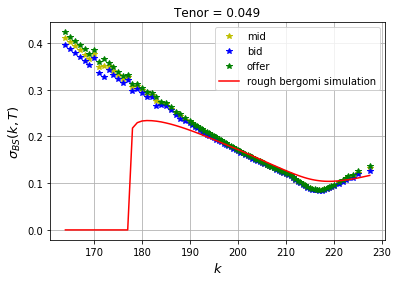

[ 0.09999942 -0.70001092  2.00000797]
0.0016643354707163167


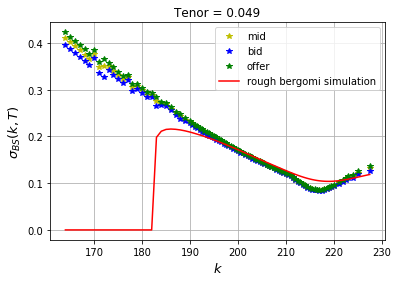

[ 0.09999941 -0.70001089  2.00000793]
0.0011676711248737902


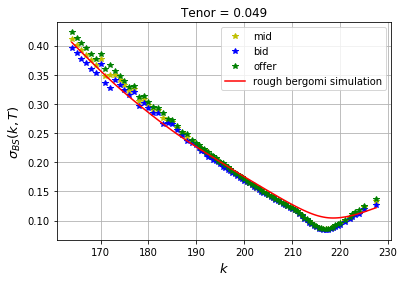

[ 0.09999941 -0.70001089  2.00000793]
0.0013245064806982334


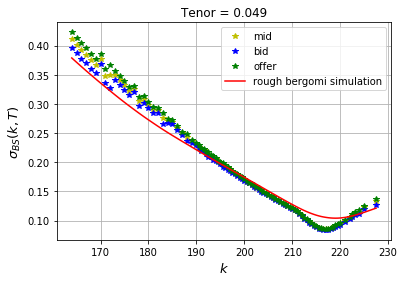

[ 0.09999942 -0.70001089  2.00000793]
0.0020347293866556392


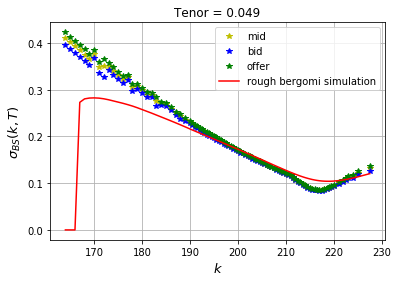

[ 0.09999941 -0.70001087  2.00000793]
0.0014971410470515166


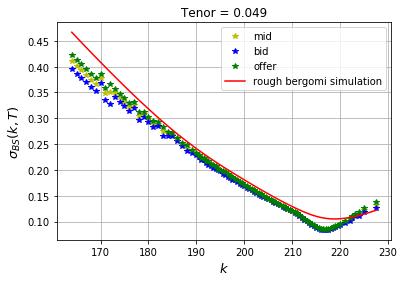

[ 0.09999941 -0.70001089  2.00000794]
0.001297487486267397


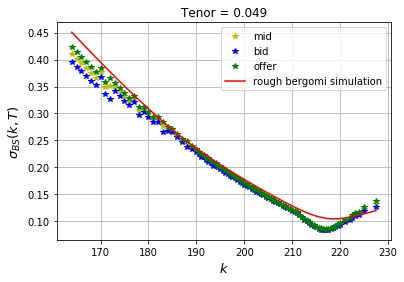

[ 0.0999994  -0.70001085  2.0000079 ]
0.00166366961153449


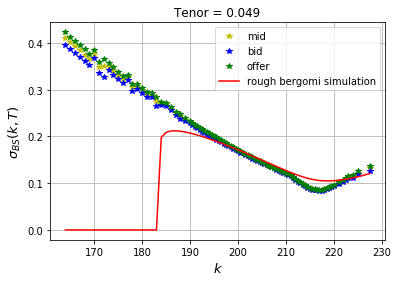

[ 0.0999994  -0.70001087  2.00000792]
0.0017428939467599555


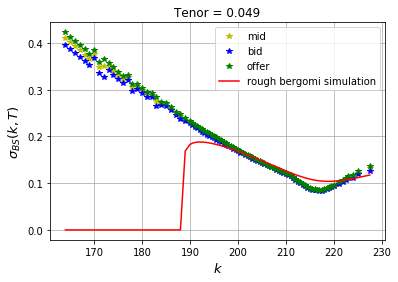

[ 0.09999941 -0.70001088  2.00000792]
0.0012463351233448431


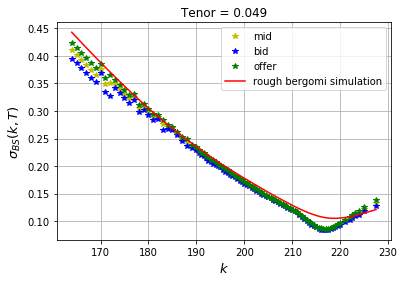

[ 0.09999941 -0.70001088  2.00000793]
0.0016483578785393077


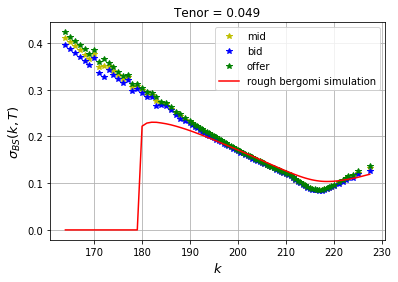

[ 0.09999941 -0.70001088  2.00000793]
0.0012286557765234106


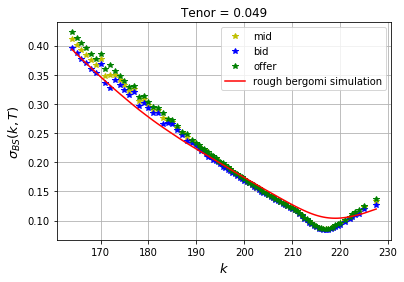

[ 0.09999941 -0.70001089  2.00000793]
0.0012726021088991222


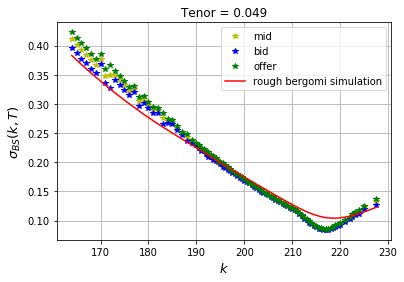

[ 0.09999941 -0.70001089  2.00000793]
0.0016898392783040546


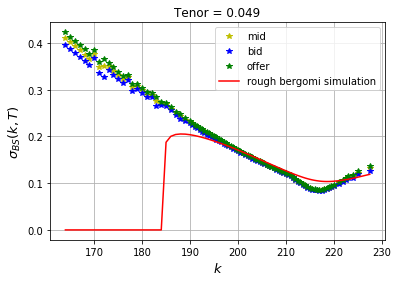

[ 0.09999941 -0.70001089  2.00000793]
0.0012594066682445914


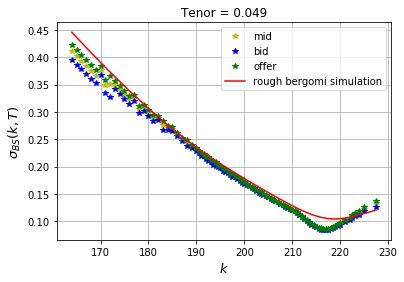

[ 0.09999941 -0.70001089  2.00000793]
0.0012172631228395436


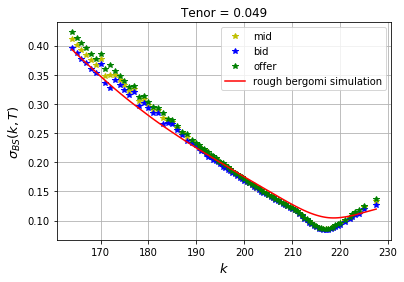

[ 0.09999941 -0.70001089  2.00000793]
0.0012529433468420003


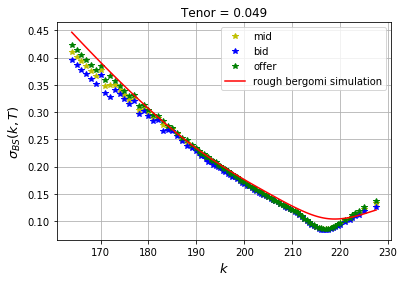

[ 0.09999941 -0.70001089  2.00000793]
0.0011534498356184756


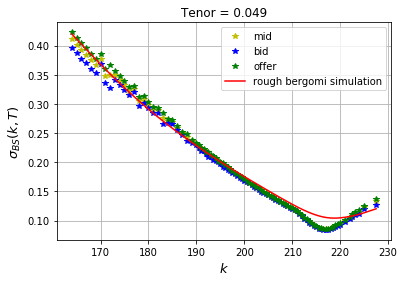

[ 0.09999941 -0.70001089  2.00000793]
0.0016341171712827291


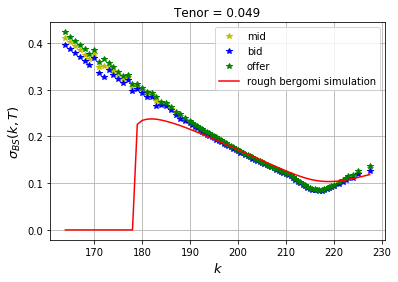

[ 0.09999942 -0.70001089  2.00000793]
0.0018618029825109121


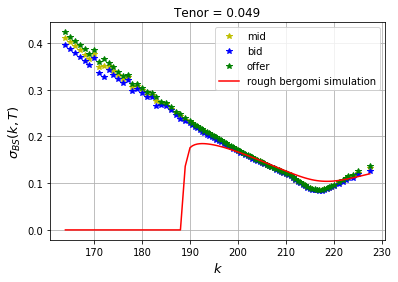

[ 0.09999941 -0.70001087  2.00000793]
0.00183349473062844


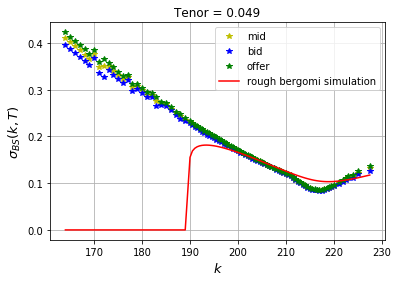

[ 0.09999941 -0.70001089  2.00000794]
0.001177366458009786


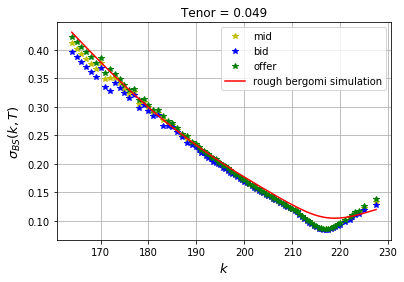

[ 0.09999941 -0.70001089  2.00000793]
0.0012102631624178993


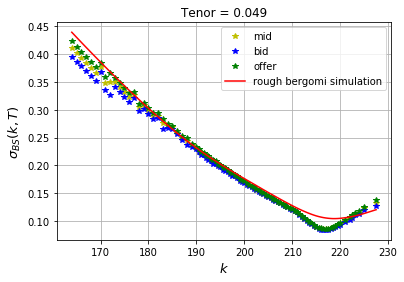

[ 10.51701836 -47.71330339  82.86850214]


/Users/maalej_ach/Desktop/PROJET OMA 3A/rBergomi/rbergomi.py:78: RuntimeWarning:

invalid value encountered in sqrt



100


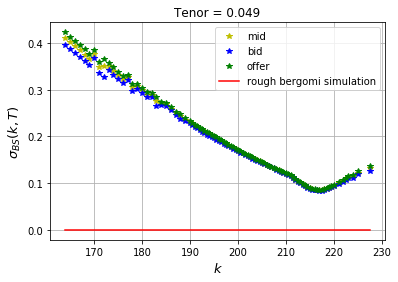

[ 10.51701838 -47.71330339  82.86850214]
100


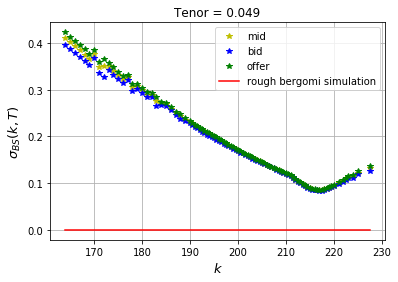

[ 10.51701836 -47.71330337  82.86850214]
100


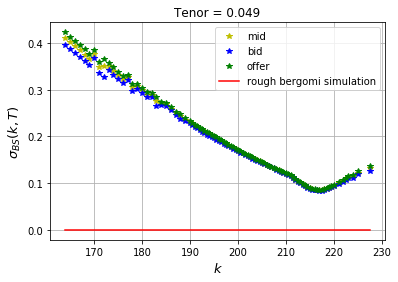

[ 10.51701836 -47.71330339  82.86850216]
100


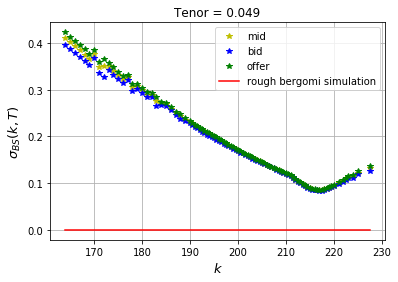

[ 10.51701836 -47.71330339  82.86850214]
100


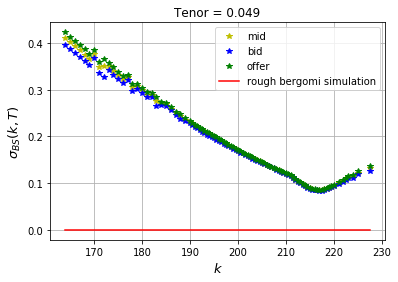

[-57.36362031 -99.05975419 -92.80380672]


/Users/maalej_ach/Desktop/PROJET OMA 3A/rBergomi/rbergomi.py:31: RuntimeWarning:

covariance is not positive-semidefinite.

/Users/maalej_ach/Desktop/PROJET OMA 3A/rBergomi/rbergomi.py:64: RuntimeWarning:

invalid value encountered in sqrt

/Users/maalej_ach/Desktop/PROJET OMA 3A/rBergomi/rbergomi.py:89: RuntimeWarning:

divide by zero encountered in power



100


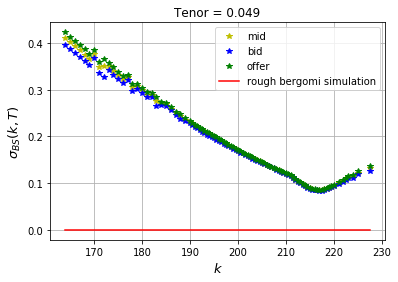

[-57.36362029 -99.05975419 -92.80380672]
100


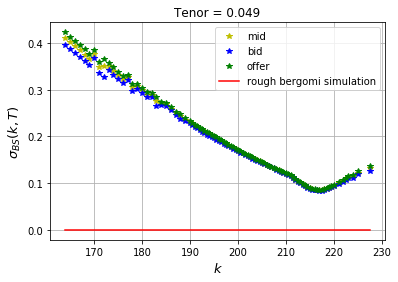

[-57.36362031 -99.05975417 -92.80380672]
100


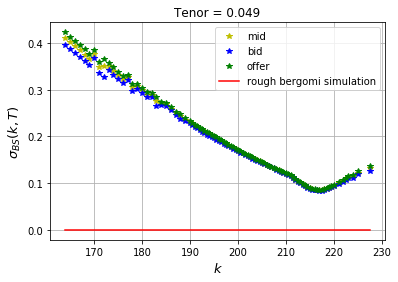

[-57.36362031 -99.05975419 -92.80380671]
100


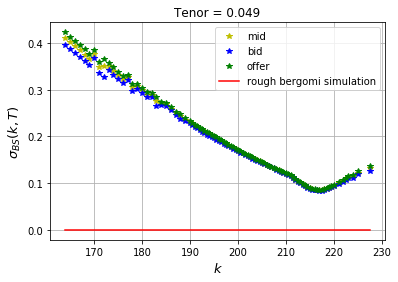

[-57.36362031 -99.05975419 -92.80380672]
100


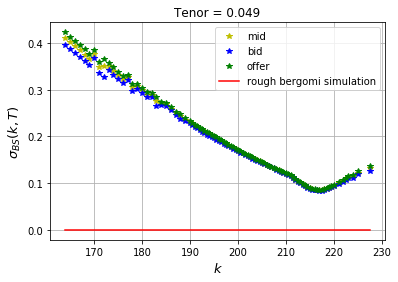

[-72.86130013 -11.29226299  -6.75217211]


/Users/maalej_ach/Desktop/PROJET OMA 3A/rBergomi/utils.py:25: RuntimeWarning:

divide by zero encountered in double_scalars



ValueError: array must not contain infs or NaNs

In [53]:
from scipy.optimize import basinhopping

res = basinhopping(func_to_minimize_fixedTenor, x0=[0.1, -0.7 , 2], interval = 5, stepsize=100, T=1,
    minimizer_kwargs = { "args": (real_imp_vols, spot, sigma0+0.01, tenor, strike_list, 252, 100000, 0.1, True)})

## Calibration all the surface :

In [35]:
def func_to_minimize_all_surface(x, df_iv_groupBy, spot, tenor_list_unique, sigma0=0.13, tenor_min=0, tenor_max=1, 
                                 n=252, N=10000, c=0.1):
    print(x)
    H,rho,eta = x[0],x[1],x[2]
    S = generate_rBergomi_paths(S0=spot, n=n, N=N, T = 1.0, H = H, rho=rho, sigma0 = sigma0, eta = eta)
    L2_error_surface = 0
    nb_tenors = 0
    for tenor in tenor_list_unique:
        if (tenor>=tenor_min) and (tenor<=tenor_max):
            nb_tenors += 1
            mat_days = int(tenor*n)+1
            strike_list = np.array([df_iv_groupBy.loc[tenor].index])
            real_imp_vols = np.array(df_iv_groupBy.loc[tenor]["midImpliedV"])
            implied_vols = np.array(find_imp_vols(S[:,:mat_days], strike_list, T=tenor)).squeeze(1)
            pts = np.where(implied_vols>0.001)[0]
            if len(pts)>5:
                #L1_error_surface += np.mean(np.abs(implied_vols[pts]-real_imp_vols[pts]))
                L2_error_surface += ((implied_vols[pts] - real_imp_vols[pts])**2).mean() + c*(1/len(pts))
            else:
                L2_error_surface += 100
        elif tenor>=tenor_max:
            break;
            
    L2_error_surface = L2_error_surface/nb_tenors
    print(L2_error_surface)
    return L2_error_surface

### Differential evolution :

In [424]:
import time
## Date 2013-08-14
start_time = time.time()
spot = df_iv_groupBy["spot"].values[0]
tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
res = differential_evolution(func_to_minimize_all_surface, disp = True, workers=-1, maxiter=20,
                              args=(df_iv_groupBy, spot, tenor_list_unique, 0.12, 0,1, 252, 10000, 0.01), popsize=15,
                              bounds=((0.03,0.3),(-0.9,-0.6),(1.5,3.5)))

print("--- %s seconds ---" % (time.time() - start_time))

[ 0.10287038 -0.74344314  2.17058204]
[ 0.22298772 -0.78269861  3.1862191 ]
[ 0.07638493 -0.61479537  2.56253786]
[ 0.14299133 -0.73517264  2.38650136]
0.0025808246890676816
[ 0.10041684 -0.87550315  2.39947466]
0.0019149600486383907
[ 0.2016087  -0.81896074  1.78034599]
0.0019666814274795054
[ 0.1496105  -0.86099117  3.0774306 ]
0.002040104035289132
[ 0.05746687 -0.82820967  2.81015701]
0.0024636665115653
[ 0.11465665 -0.88070084  2.67231265]
0.0025694816939150506
[ 0.11337249 -0.69532569  3.22942833]
0.0028751632507194227
[ 0.16917234 -0.67996919  2.73148973]
0.0023621561019290496
[ 0.04439369 -0.8228542   1.71205774]
0.0022444671134118567
[ 0.25590975 -0.85138521  2.59681113]
0.0023957127109726253
[ 0.27963692 -0.80268561  2.75630153]
0.0023354794331384944
[ 0.18889187 -0.84258441  3.1262635 ]
0.002286564958233985
[ 0.28845342 -0.64188855  2.94966318]
0.0019392129210110585
[ 0.22901443 -0.72468961  1.76571155]
0.0019239517666734104
[ 0.07817268 -0.64905424  2.21113139]
0.00228689362

[ 0.1030721  -0.73517264  2.38650136]
differential_evolution step 2: f(x)= 0.0017467
0.0023581666770524025
[ 0.1341286  -0.7931924   3.21732441]
0.002043676594731022
[ 0.07168241 -0.70438429  2.86544605]
0.0028965078114667015
[ 0.05234279 -0.60741381  2.95569724]
0.0022180940623905345
[ 0.17869025 -0.62136708  2.87165086]
0.002536454162746271
[ 0.19428434 -0.73301957  2.96137039]
0.0019080026302825534
[ 0.08449014 -0.6668762   2.68072628]
0.0025962989467631357
[ 0.09475066 -0.70019816  3.31153593]
0.0022629181186527474
[ 0.05246035 -0.61192799  3.0057327 ]
0.001959081623310334
[ 0.10784951 -0.68915818  3.32788337]
0.0022448512164583126
[ 0.20822701 -0.63902447  2.53611704]
0.0021389714167269597
[ 0.17180217 -0.6552692   3.1262635 ]
0.0019767370094820077
[ 0.09614927 -0.64544617  3.28390798]
0.0019032822485137795
[ 0.03514614 -0.69497932  2.21113139]
0.0030996674332413265
[ 0.03514614 -0.88060542  2.93822487]
0.001981734786124334
[ 0.08632883 -0.66955426  2.8260144 ]
0.00245357664425263

differential_evolution step 5: f(x)= 0.00162379
0.0024905833130865777
[ 0.14906453 -0.60182558  2.3006592 ]
0.00229359293780259
[ 0.09222867 -0.81896074  2.4279511 ]
0.001666674850509811
[ 0.12876876 -0.63225572  2.33714075]
0.0025551834387339063
[ 0.16910569 -0.72955968  1.60870906]
0.0024381741652218635
[ 0.18490469 -0.6725659   1.54953046]
0.0021992155649407435
[ 0.11539446 -0.6668762   2.12609498]
0.002556682392238902
[ 0.1040471  -0.6784993   2.47501648]
0.0025294447667299973
[ 0.08263939 -0.73911559  1.77131687]
0.0019174084783630948
[ 0.1661658  -0.62113254  1.56743564]
0.0016622407834410993
[ 0.20822701 -0.62031257  2.28755167]
0.0016703532534818898
[ 0.15872153 -0.65989443  2.83942117]
0.0017725815527905966
[ 0.14855353 -0.61825165  2.50934063]
0.002374163285078958
[ 0.11802946 -0.71732188  2.41477588]
0.002276035983681601
[ 0.18810024 -0.61624745  2.81945911]
0.0020766879790896117
[ 0.14681281 -0.74791819  3.03011894]
0.0018074808067073992
[ 0.07835988 -0.68824779  2.35021779

differential_evolution step 8: f(x)= 0.00162379
0.0025657769839785467
[ 0.13002559 -0.69075325  2.44662406]
0.002516589458252356
[ 0.17027833 -0.81489046  2.33714075]
0.0022529043679319796
[ 0.16967374 -0.62080147  2.59629135]
0.0020587429523166926
[ 0.14058183 -0.62136708  1.76328148]
0.002221743994326936
[ 0.13428404 -0.69372401  1.93967728]
0.002358106405309622
[ 0.11539446 -0.65253834  2.04439229]
0.0018841815247526957
[ 0.08263939 -0.8335952   1.52084206]
0.0026504672821227363
[ 0.1069872  -0.67429785  2.50990861]
0.0021747098146126364
[ 0.13422149 -0.71593827  2.54869846]
0.0024147511697925196
[ 0.10458225 -0.61225796  1.85873043]
0.0026511079094239443
[ 0.20906239 -0.78705818  2.18049234]
0.0021951549701581165
[ 0.14855353 -0.63005714  2.04333013]
0.0020524538161286517
[ 0.15880965 -0.61206206  1.95412256]
0.0018431207881937804
[ 0.11666457 -0.62300446  1.75574338]
0.002431711287910424
[ 0.13537746 -0.62560803  2.17069989]
0.0019489349875945446
[ 0.07618846 -0.71969056  2.490149

0.002405550947735993
[ 0.11582308 -0.73559092  2.33714075]
0.0023697445304426846
[ 0.24779617 -0.62278736  1.9089211 ]
0.002047626627323665
[ 0.15559389 -0.75695021  2.683713  ]
0.0016194610991673265
[ 0.23904412 -0.82283455  2.15356207]
0.0018976890551295478
[ 0.07138832 -0.66216064  1.51257651]
0.0018735370195569214
[ 0.09475066 -0.7101491   1.54953046]
0.0026037771162210083
[ 0.16060074 -0.61726186  2.47501648]
0.002370669215024461
[ 0.06437823 -0.60820445  2.02059604]
0.0023445810978176555
[ 0.11229366 -0.7481631   1.79166278]
0.0023912626326728246
[ 0.12217029 -0.6166625   2.36659264]
0.0023778055512648816
[ 0.17180217 -0.6979786   2.83311478]
0.0024825225272731267
[ 0.14564113 -0.83059245  2.99212475]
0.0020395722605794416
[ 0.08887739 -0.64837934  2.23587918]
0.0022178379280412388
[ 0.17988803 -0.68345815  1.57265112]
0.0025024018964766664
[ 0.08632883 -0.83147892  2.09110204]
0.0021282145784610796
[ 0.16559796 -0.65418035  2.47167907]
0.0022461580186231467
[ 0.08758064 -0.71973

[ 0.14427781 -0.75421801  2.29060375]
0.002607906129801719
[ 0.03677922 -0.61404901  2.43258072]
0.002488636228360842
[ 0.08302674 -0.62278736  2.09455115]
0.0020948332503675604
[ 0.14693278 -0.68552856  2.44662406]
0.0023973468935175202
[ 0.03259588 -0.75390376  1.7108663 ]
0.0020828996308812973
[ 0.10378744 -0.73428776  2.47083575]
0.0018600278973264202
[ 0.11539446 -0.84060016  1.60378877]
0.0015507797917807056
[ 0.09475066 -0.74006445  1.59876111]
0.0022207056785435598
[ 0.07202309 -0.66307752  2.73531409]
0.002403086600154981
[ 0.19779263 -0.81156179  3.10483964]
0.0022907987146849793
[ 0.04919371 -0.75584796  1.82322088]
0.00192218012590938
[ 0.16882866 -0.66745354  2.10796407]
0.001771677387447842
[ 0.18799026 -0.85055665  2.34782966]
0.0020987533624944993
[ 0.11832283 -0.69018723  1.55913596]
0.0022453981804035125
[ 0.17137876 -0.60011071  3.24187393]
0.0024354627229790054
[ 0.08976613 -0.70467007  3.20061997]
0.0026421633954644623
[ 0.03905007 -0.74857771  2.04785634]
0.002396

0.002362990201482411
[ 0.09449204 -0.71533977  2.9844939 ]
0.001836234617243981
[ 0.15763029 -0.64384816  2.44662406]
0.002004936568657712
[ 0.03722288 -0.66662762  3.43770503]
0.0023118633770143992
[ 0.13547905 -0.7743536   1.77131687]
0.0018082453200791828
[ 0.27831744 -0.6293403   1.64138572]
0.003028885314858641
[ 0.12829391 -0.71875801  2.40037572]
0.0016947729075271168
[ 0.03598047 -0.66901777  1.68822743]
0.0020305335440096413
[ 0.03006162 -0.63500975  1.6539046 ]
0.0019961540776909197
[ 0.06818283 -0.64554353  2.20497615]
0.0022510491324030505
[ 0.16279223 -0.7085707   2.31963097]
0.002132269953947725
[ 0.12162021 -0.62918365  3.22920488]
0.002196032457563703
[ 0.14787987 -0.6994039   2.15590263]
0.0025873331453538885
[ 0.1312377  -0.83147892  2.9801117 ]
0.0023548298525186205
[ 0.11832283 -0.77700732  1.51419636]
0.0018887107323639065
[ 0.11994935 -0.8614346   2.33851638]
0.0020284381263662
[ 0.15439642 -0.61981273  2.39029572]
0.003448378292421261
[ 0.09954748 -0.70402918  1.

0.0021316040326723605
[ 0.03 -0.9   1.5 ]
0.0024334214195759463
[ 0.03000001 -0.9         1.5       ]
0.002261562852089216
[ 0.03       -0.89999999  1.5       ]
0.002203791649822848
[ 0.03       -0.9         1.50000001]
0.002407168415215105
[ 0.05927494 -0.74695675  1.82823914]
0.0019037671177009267
[ 0.05927495 -0.74695675  1.82823914]
0.0020833242536962707
[ 0.05927494 -0.74695674  1.82823914]
0.0019233826735797393
[ 0.05927494 -0.74695675  1.82823915]
0.0023082270653983733
[ 0.07931189 -0.6422078   2.05289921]
0.002382064229097438
[ 0.0793119  -0.6422078   2.05289921]
0.0023171210893380726
[ 0.07931189 -0.64220779  2.05289921]
0.0018950274798476955
[ 0.07931189 -0.6422078   2.05289922]
0.0017024575019608734
[ 0.08094193 -0.63368629  2.07117568]
0.0020846852547674916
[ 0.08094194 -0.63368629  2.07117568]
0.0022662380289363592
[ 0.08094193 -0.63368628  2.07117568]
0.0023264167063906356
[ 0.08094193 -0.63368629  2.07117569]
0.0019231970934165748
[ 0.08228103 -0.62668577  2.08619003]
0.

In [425]:
## Date 2016-04-22
res 

     fun: 0.0015507797917807056
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1037
     nit: 20
 success: False
       x: array([ 0.08302674, -0.62278736,  2.09455115])

In [406]:
## Date 2014-01-15
res 

     fun: 0.0009143889794972427
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1069
     nit: 20
 success: False
       x: array([ 0.09057721, -0.77871421,  1.98934386])

In [369]:
## Date 2013-08-14
res 

     fun: 0.0009717326243568926
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1013
     nit: 20
 success: False
       x: array([ 0.08930132, -0.79512602,  2.14441384])

In [250]:
## Date 2013-08-14
res 

     fun: 0.01843686516423352
 message: 'Optimization terminated successfully.'
    nfev: 1519
     nit: 30
 success: True
       x: array([ 0.06490549, -0.80778963,  2.16979096])

In [379]:
## Date 2015-03-02
res

     fun: 0.0009554735932678391
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1029
     nit: 20
 success: False
       x: array([ 0.12408347, -0.77516331,  2.58549533])

### Cobyla :

In [365]:
from scipy.optimize import fmin_cobyla


def constr1(x):
    return x[0] - 0.03

def constr2(x):
    return 0.3 - x[0]
    
def constr3(x):
    return x[1]+0.9

def constr4(x):
    return -0.6 - x[1]

def constr5(x):
    return x[2] - 1.5

def constr6(x):
    return 3.5 - x[2]


res = fmin_cobyla(func_to_minimize_all_surface, x0=[0.08, -0.8 , 2], 
                  cons = [constr1, constr2,constr3,constr4,constr5,constr6], 
                            args=(df_iv_groupBy, 0.12, 0,1, 252, 10000, 0.01), consargs=(),
                 rhobeg = 0.5, rhoend=0.0001, disp=3)


[ 0.08 -0.8   2.  ]
0.0019222225364409855
[ 0.58 -0.8   2.  ]
0.0017660561396880433
[ 0.58 -0.3   2.  ]
0.0018049141460171776
[ 0.58 -0.8   2.5 ]
0.0013955062517526794
[ 0.3        -0.84320336  2.91198722]
0.00187721891883902
[ 0.3        -0.86927684  3.16062385]
0.0019349086789727879
[ 0.3        -0.71888505  2.92502396]
0.0016877885341138477
[ 0.3        -0.6         2.70510046]
0.002193351851503158
[ 0.3        -0.6713881   3.04064852]
0.00212577288158664
[ 0.2375     -0.71888505  2.92502396]
0.001846332917255486
[ 0.3        -0.6690031   2.81040812]
0.0014928850024729322
[ 0.3        -0.6         2.70617966]
0.00178825343148525
[ 0.3        -0.61563373  2.77788181]
0.0013789783411358907
[ 0.3       -0.6        2.7173687]
0.001331209153679422
[ 0.3       -0.6        2.6548687]
0.0016350555490021214
[ 0.33125   -0.6        2.7173687]
0.00197688468643515
[ 0.23916142 -0.6         2.73168362]
0.001280203211453259
[ 0.24112135 -0.6         2.7628721 ]
0.0016357950455180542
[ 0.23916142 

In [366]:
res

array([ 0.23480272, -0.6       ,  2.72539278])